In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline

import seaborn as sns
from sklearn.neighbors import NearestNeighbors as nn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score

#from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from lightgbm import LGBMClassifier
#from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score


In [2]:
random_state = 123*987*4-1
models_to_average = 50

In [3]:
real_dataset = pd.read_csv("./datasets/real_ds_shortincome.csv")
synt_data_distilgpt2 = pd.read_csv('./datasets/synt_ds_distillgpt2_shortincome_3epochs_temp0.3.csv')
synt_data_gpt2xl = pd.read_csv("./datasets/synt_ds_gpt2xl_shortincome_3epochs_temp0.3.csv")
synt_data_cerebras = pd.read_csv("./datasets/synt_ds_cerebras13_shortincome_3epochs_temp0.3.csv")
synt_data_phi = pd.read_csv("./datasets/synt_ds_phi15_shortincome_3epochs_temp0.3.csv")
control_dataset = pd.read_csv("./datasets/real_ds_shortincome_control.csv")

In [4]:
real_dataset.drop(columns="Unnamed: 0",inplace=True)
synt_data_distilgpt2.drop(columns="Unnamed: 0",inplace=True)
synt_data_gpt2xl.drop(columns="Unnamed: 0",inplace=True)
synt_data_cerebras.drop(columns="Unnamed: 0",inplace=True)
synt_data_phi.drop(columns="Unnamed: 0",inplace=True)
control_dataset.drop(columns="Unnamed: 0",inplace=True)


In [5]:
cols = real_dataset.columns

In [6]:
def strip (x) :
    if isinstance(x,str):
        return x.lstrip()
    else :
        return x

In [7]:
for col in cols :
    real_dataset[col] = real_dataset[col].map(strip) 

In [8]:
for col in cols :
    synt_data_distilgpt2[col] = synt_data_distilgpt2[col].map(strip) 

In [9]:
for col in cols :
    synt_data_gpt2xl[col] = synt_data_gpt2xl[col].map(strip) 

In [10]:
for col in cols :
    synt_data_cerebras[col] = synt_data_cerebras[col].map(strip) 

In [11]:
for col in cols :
    synt_data_phi[col] = synt_data_phi[col].map(strip) 

In [12]:
for col in cols :
    control_dataset[col] = control_dataset[col].map(strip) 

In [13]:
categs = list()
numeric = list()
for col in cols :
    print ('----------------------------------------------------')
    print (col, ':', real_dataset[col].dtype)
    print (len(real_dataset[col].unique()),'uniques values : ' ,real_dataset[col].unique())
    if real_dataset[col].dtype == 'object' :
        if col != 'target' :
            categs.append(col)
    else :
         numeric.append(col)
    

----------------------------------------------------
age : int64
91 uniques values :  [52 39 29 30 15  6 50 21 42 32  8 87 47 45  7  4 17 14 82 19 40 71 49 22
 74 25  2 36 35 18 58 54 24 37 80 73 55  0 62 28 78 41 75 60 69 13 12 61
 44 64  3 43 27 31 46 76 33 23 84 48  1  5 70 16 51 38 72  9 20 56 90 11
 67 26 34 10 57 53 66 77 85 89 68 79 81 65 59 83 88 63 86]
----------------------------------------------------
class_of_worker : object
9 uniques values :  ['Private' 'Self-employed-not incorporated' 'Not in universe'
 'Self-employed-incorporated' 'Local government' 'State government'
 'Federal government' 'Never worked' 'Without pay']
----------------------------------------------------
education : object
17 uniques values :  ['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate

In [14]:
# these features are categorical by definition
numeric.remove('own_business_or_self_employed')
categs.append('own_business_or_self_employed')


In [15]:
numeric

['age',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

In [16]:
categs

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [17]:
target_encoder= {'50000+.': 1, 
                '- 50000.': 0} 

# Data analysis

### Real data 

In [18]:
real_dataset.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      34.438300             188.126267                         1.964933   
std       22.350409            2007.247607                         2.375379   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       33.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.171133             23.182433  
std                         0.548383             24.424737  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              8.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [19]:
print(real_dataset.isna().sum().sum())

0


In [20]:
real_dataset['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

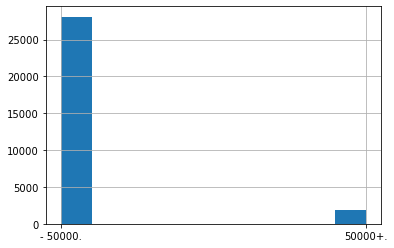

In [21]:
real_dataset['target'].hist()

In [22]:
print(f" Real data for binary classification is imbalanced: {len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}% and {100-len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}%")


 Real data for binary classification is imbalanced: 6.30% and 93.70%


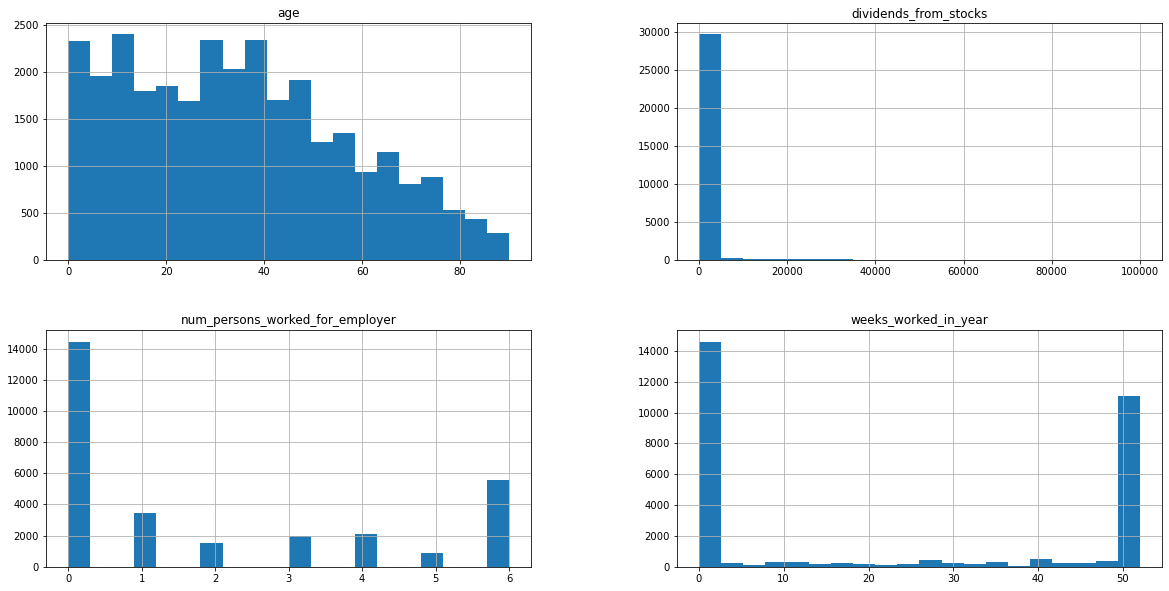

In [23]:
real_dataset[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

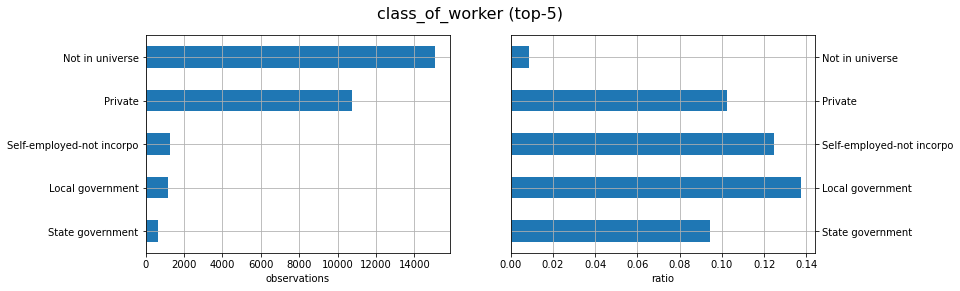

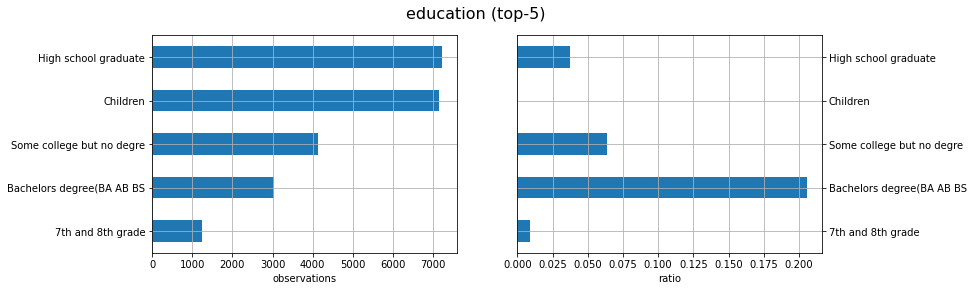

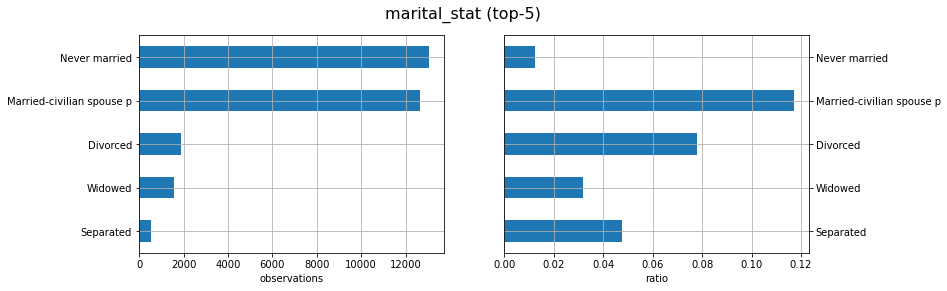

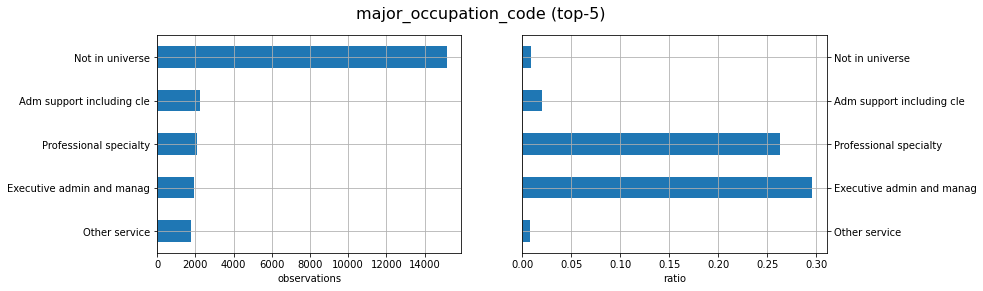

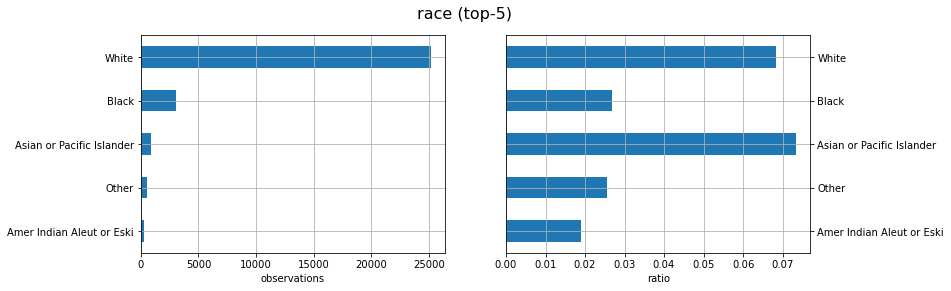

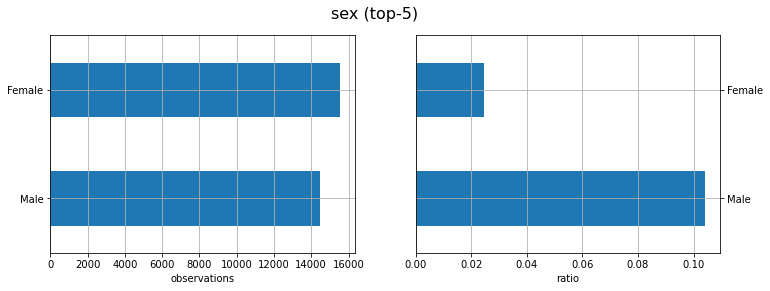

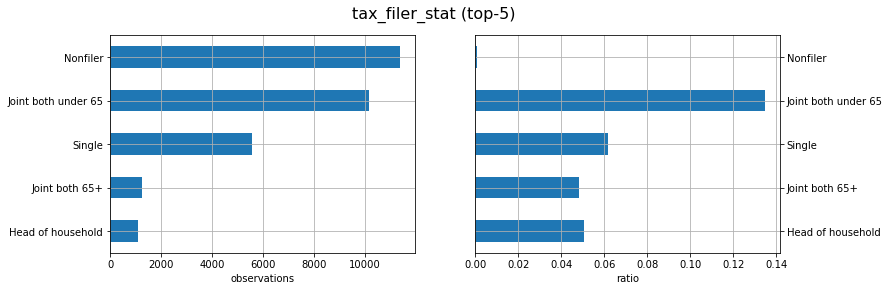

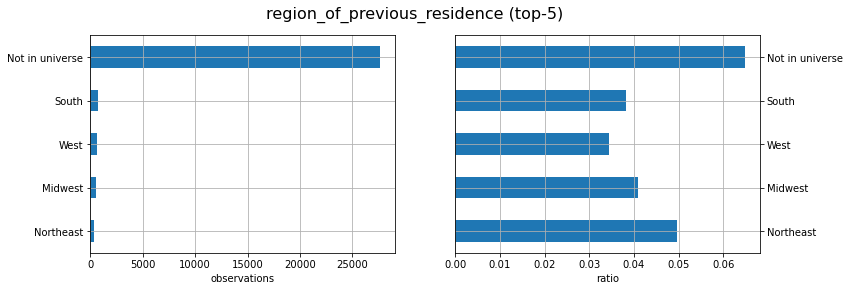

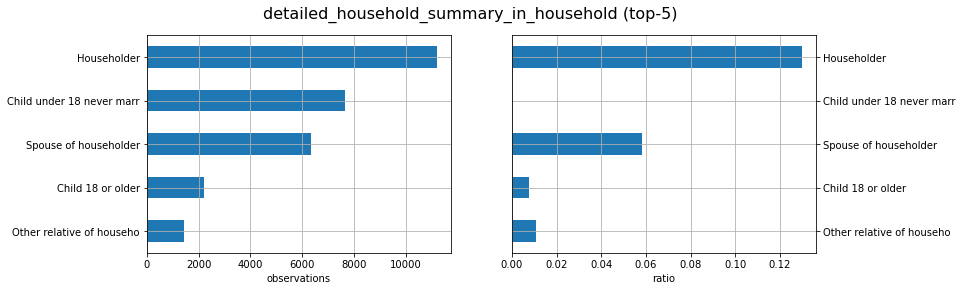

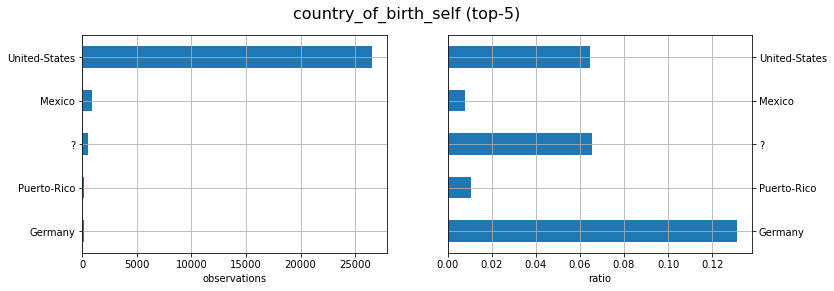

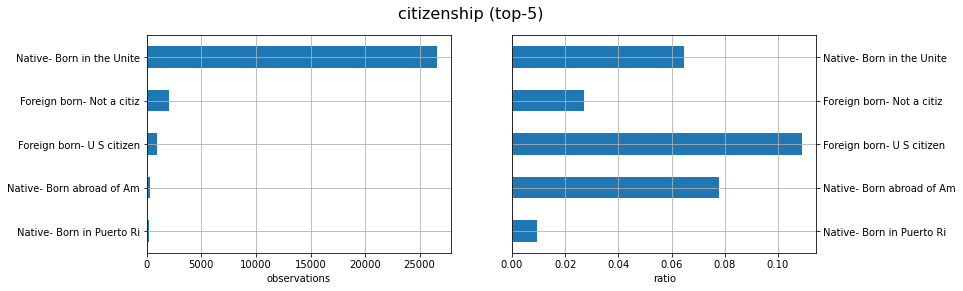

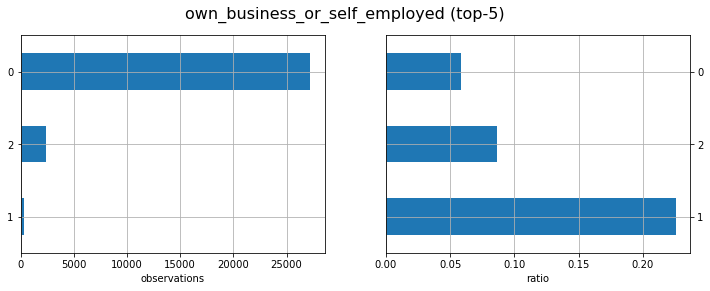

In [24]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = real_dataset.drop(['target'], axis=1).assign(cnt=1, target=real_dataset['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### DistillGPT

In [25]:
synt_data_distilgpt2.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000                30000.0                     30000.000000   
mean      29.192933                    0.0                         1.725767   
std       22.305241                    0.0                         2.649981   
min        0.000000                    0.0                         0.000000   
25%        8.000000                    0.0                         0.000000   
50%       30.000000                    0.0                         0.000000   
75%       43.000000                    0.0                         6.000000   
max       90.000000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.001800             16.666567  
std                         0.059974             24.262561  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [26]:
print(synt_data_distilgpt2.isna().sum().sum())
print(synt_data_distilgpt2.isna().sum())

0
age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
target                                     0
dtype: int64


In [27]:
synt_data_distilgpt2['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

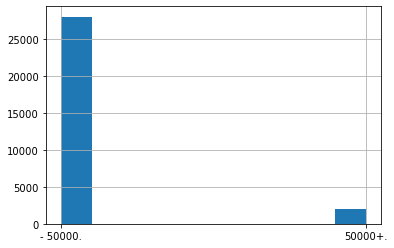

In [28]:
synt_data_distilgpt2['target'].hist()

In [29]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}% and {100-len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}%")


 Synthetic data for binary classification is imbalanced: 0.00% and 100.00%


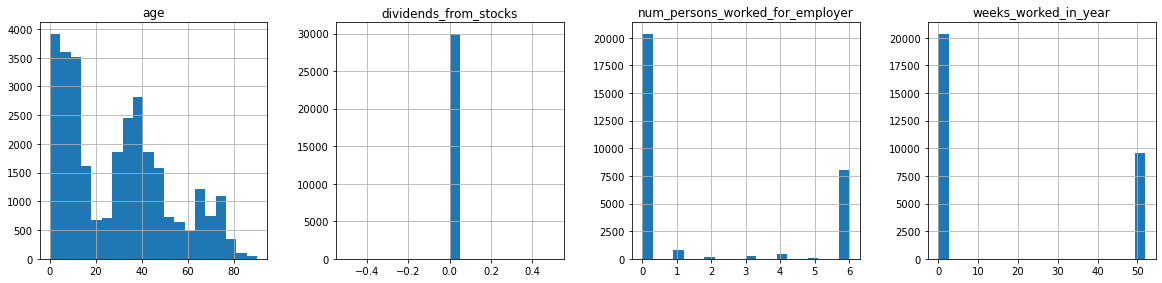

In [30]:
synt_data_distilgpt2[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 4))
plt.show()

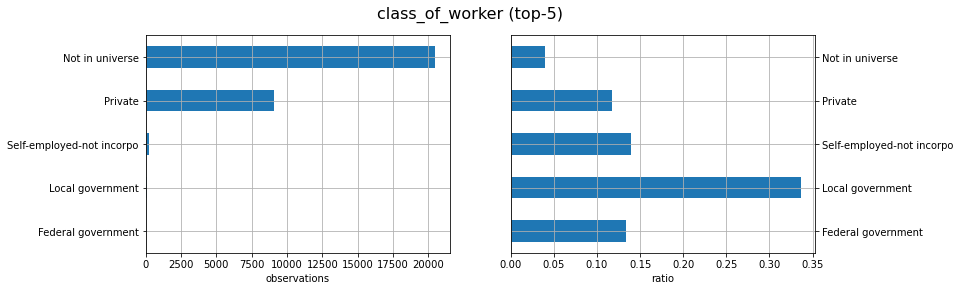

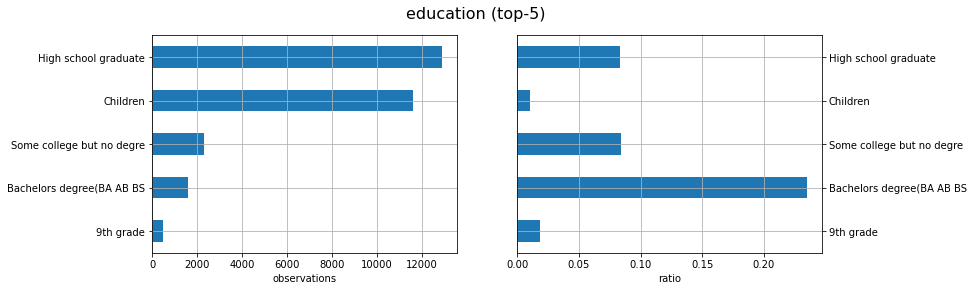

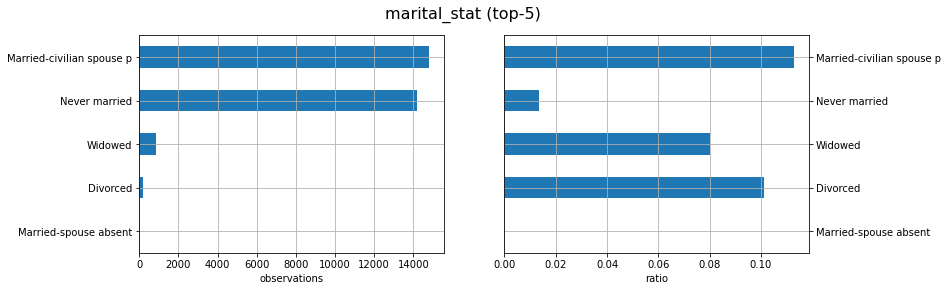

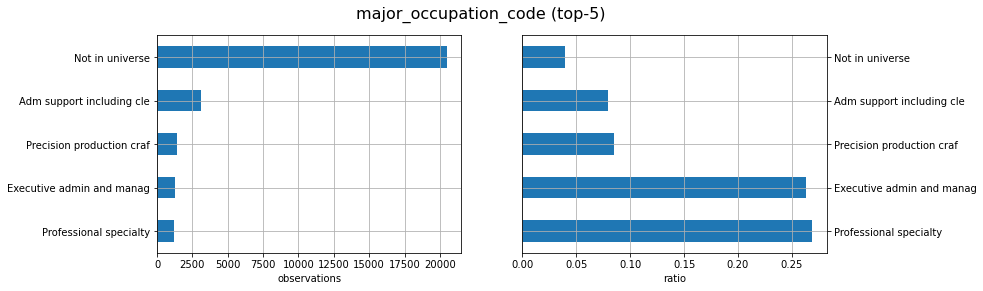

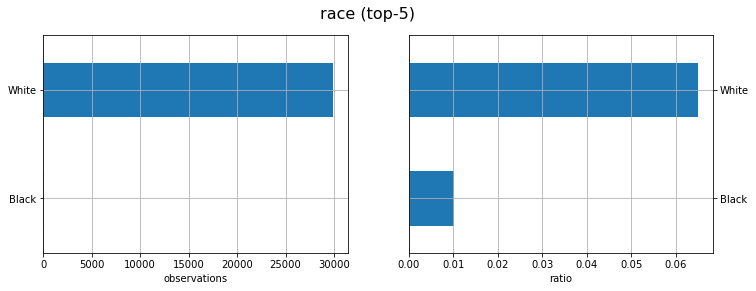

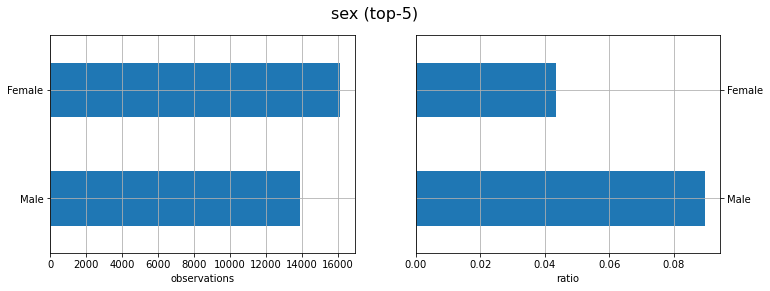

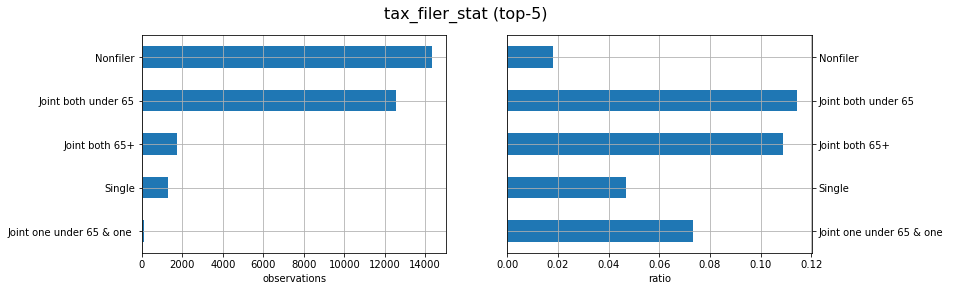

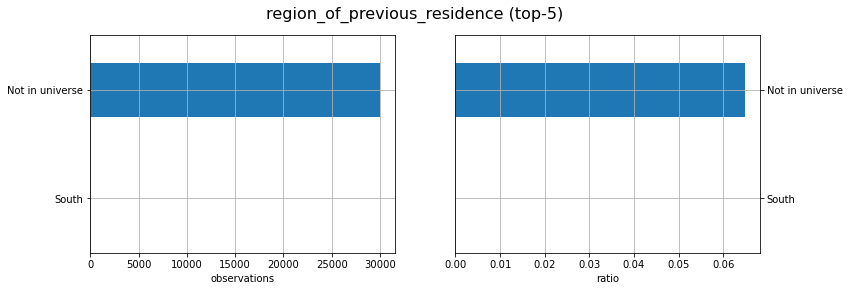

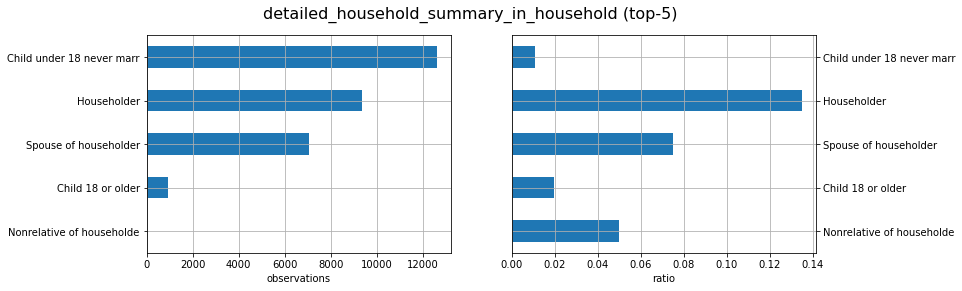

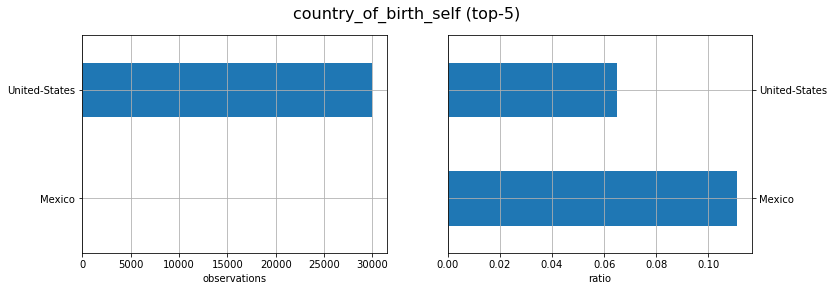

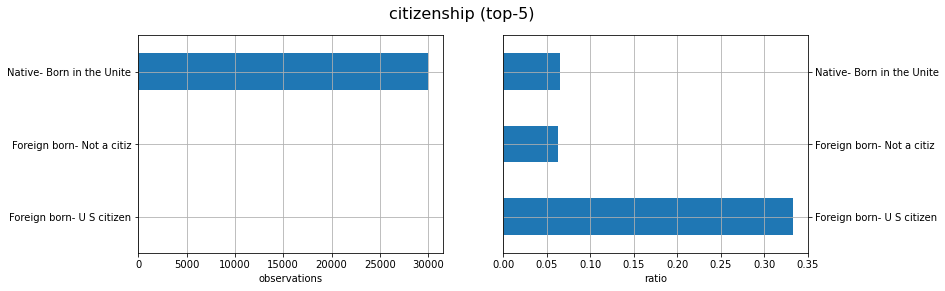

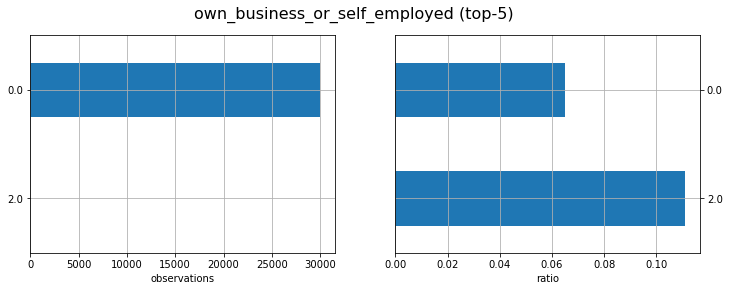

In [31]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_distilgpt2.drop(['target'], axis=1).assign(cnt=1, target=synt_data_distilgpt2['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### GPT2XL 

In [32]:
synt_data_gpt2xl.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000                30000.0                     30000.000000   
mean      21.690933                    0.0                         1.640133   
std       19.562249                    0.0                         2.616370   
min        0.000000                    0.0                         0.000000   
25%        6.000000                    0.0                         0.000000   
50%       13.000000                    0.0                         0.000000   
75%       36.000000                    0.0                         6.000000   
max       90.000000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.001200             15.705567  
std                         0.048976             23.872951  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [33]:
print(synt_data_gpt2xl.isna().sum().sum())

0


In [34]:
synt_data_gpt2xl['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

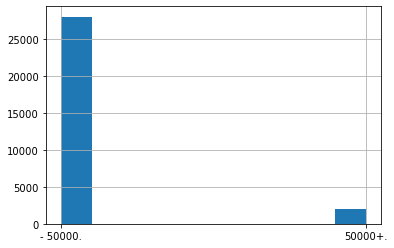

In [35]:
synt_data_gpt2xl['target'].hist()

In [36]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}% and {100-len(synt_data_gpt2xl[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.47% and 93.53%


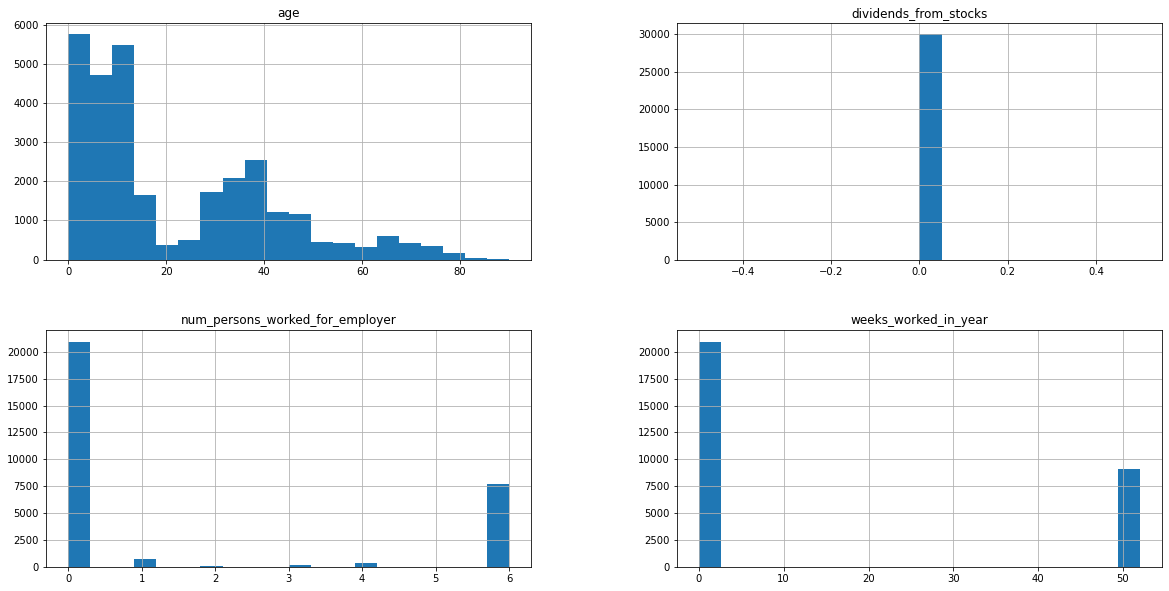

In [37]:
synt_data_gpt2xl[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

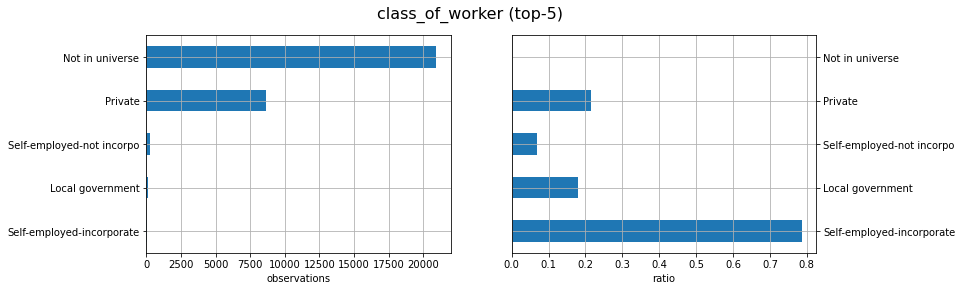

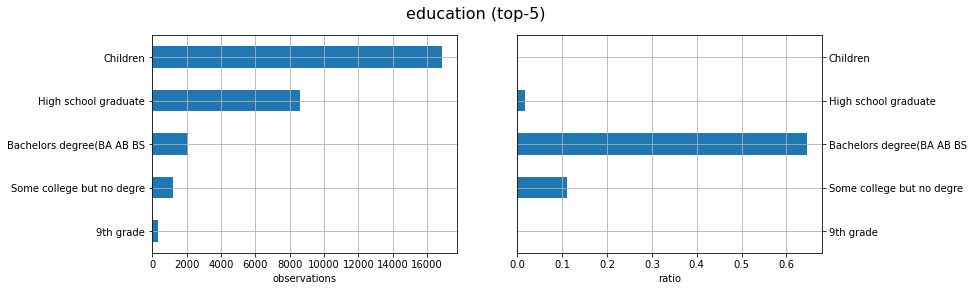

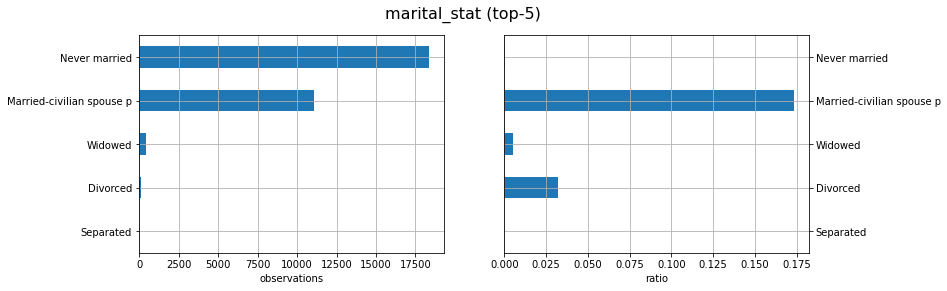

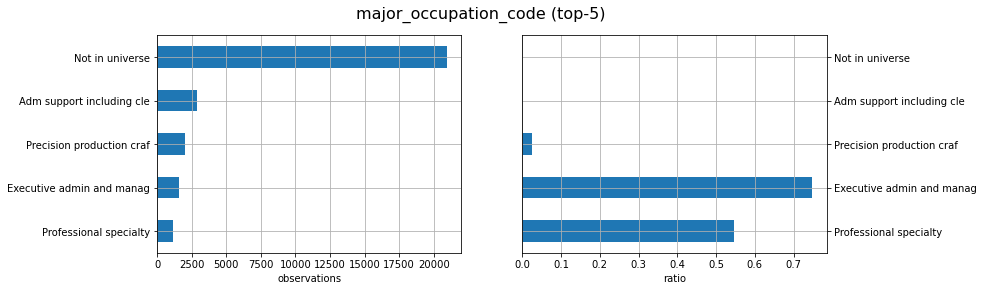

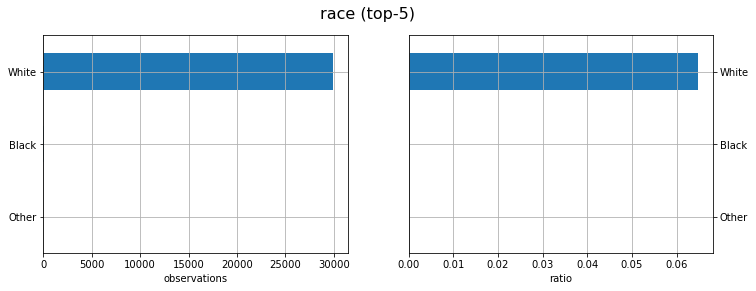

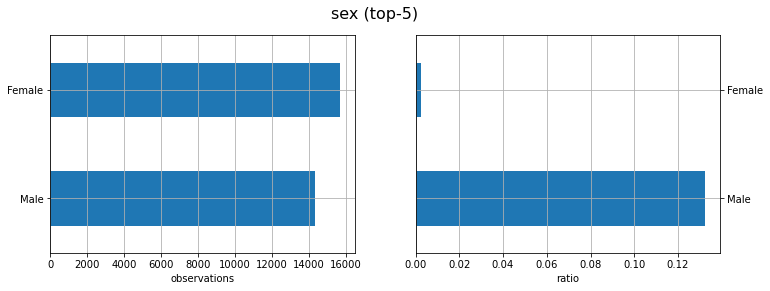

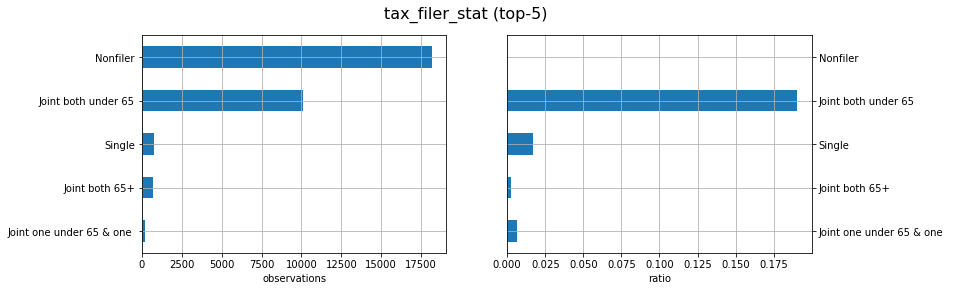

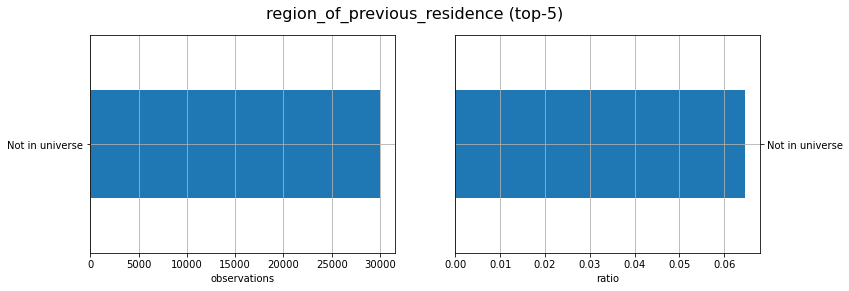

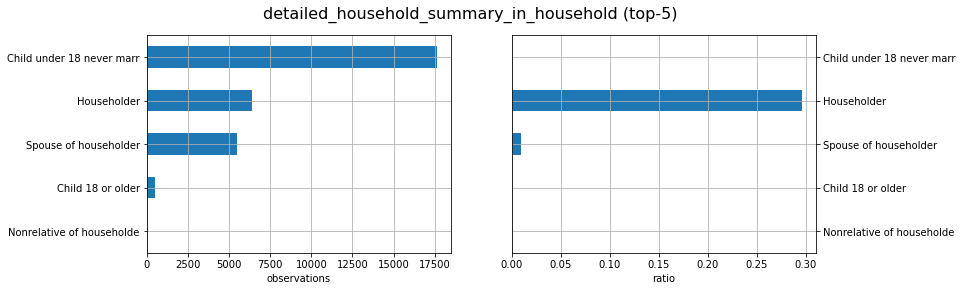

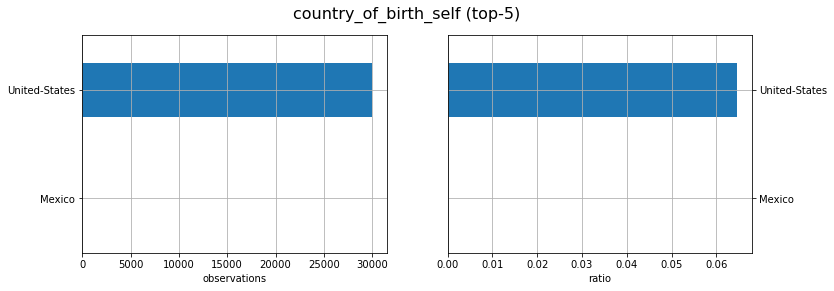

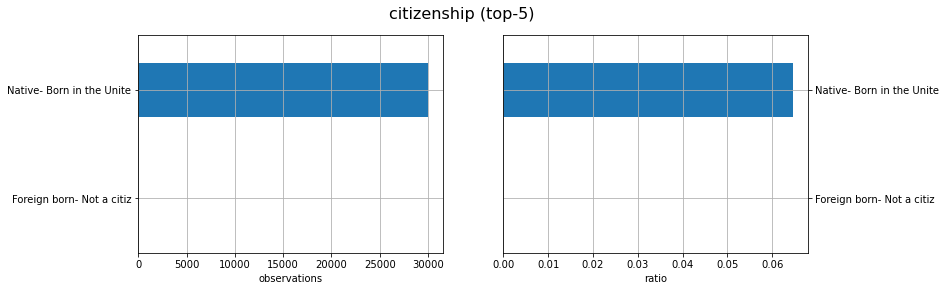

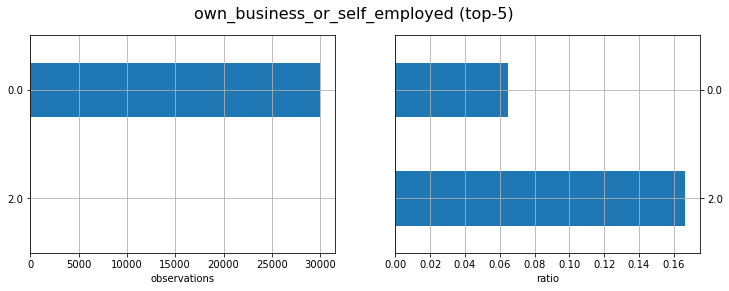

In [38]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_gpt2xl.drop(['target'], axis=1).assign(cnt=1, target=synt_data_gpt2xl['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Cerebras 

In [39]:
synt_data_cerebras.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000                30000.0                     30000.000000   
mean      21.343900                    0.0                         1.665833   
std       19.303842                    0.0                         2.626201   
min        0.000000                    0.0                         0.000000   
25%        6.000000                    0.0                         0.000000   
50%       12.000000                    0.0                         0.000000   
75%       36.000000                    0.0                         6.000000   
max       90.000000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.001800             16.013000  
std                         0.059974             24.002899  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [40]:
print(synt_data_cerebras.isna().sum().sum())

0


In [41]:
synt_data_cerebras['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

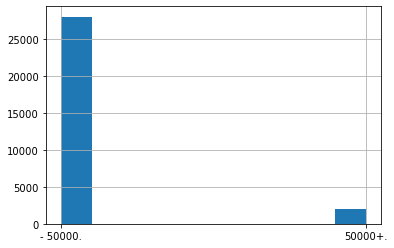

In [42]:
synt_data_cerebras['target'].hist()

In [43]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}% and {100-len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.49% and 93.51%


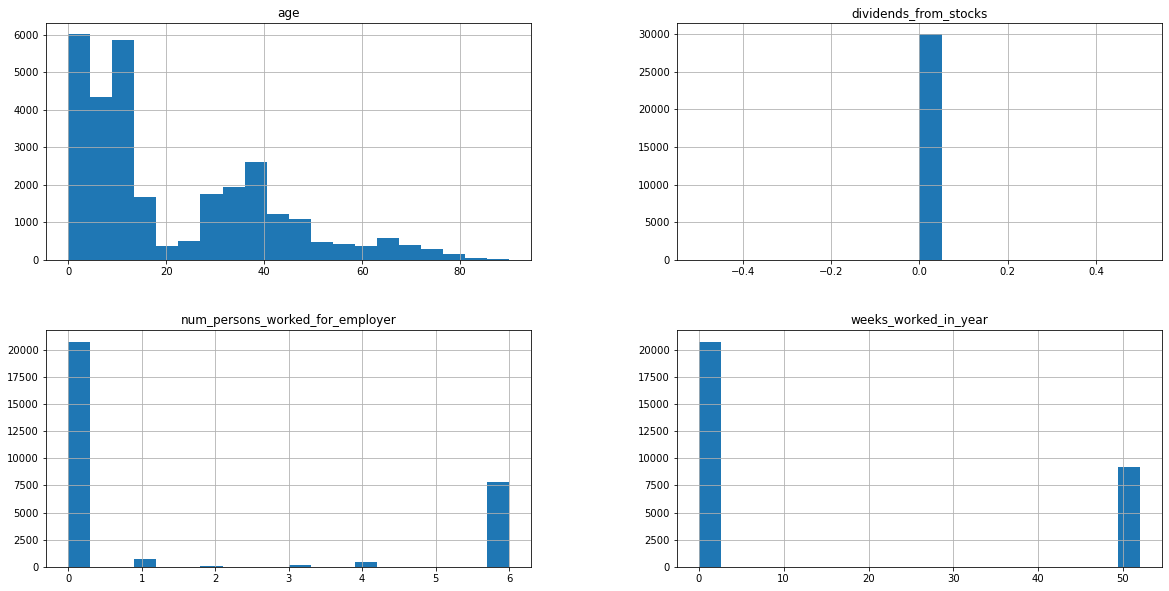

In [44]:
synt_data_cerebras[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

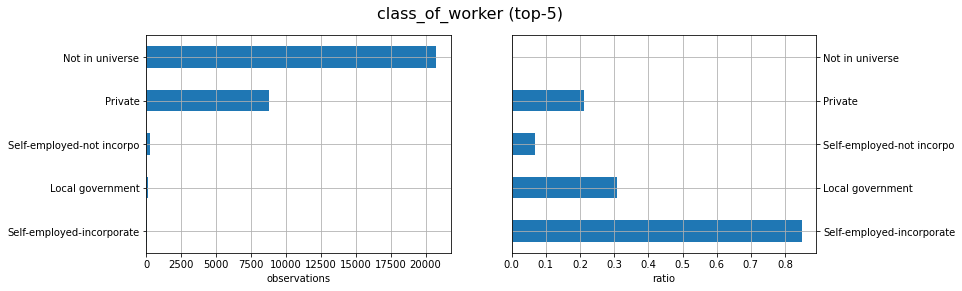

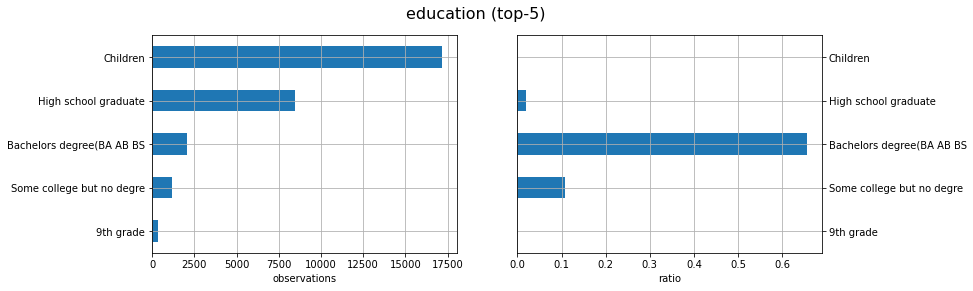

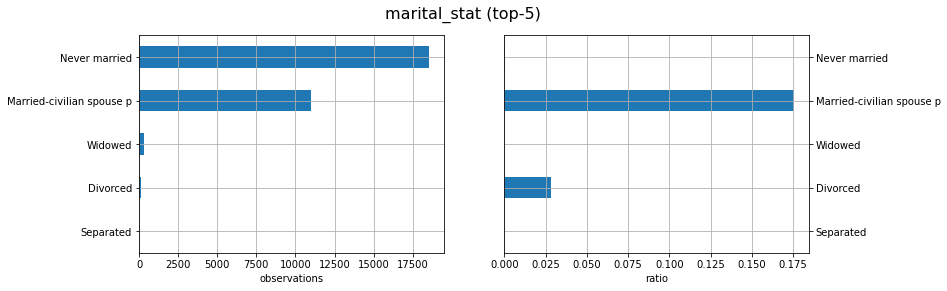

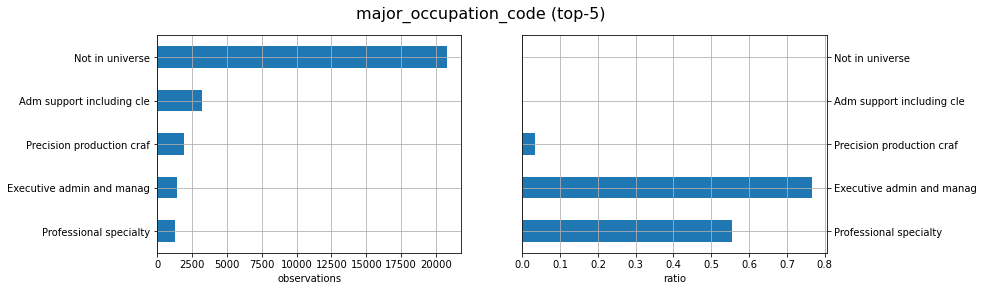

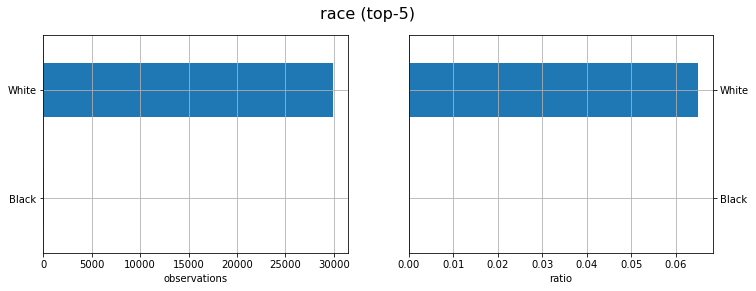

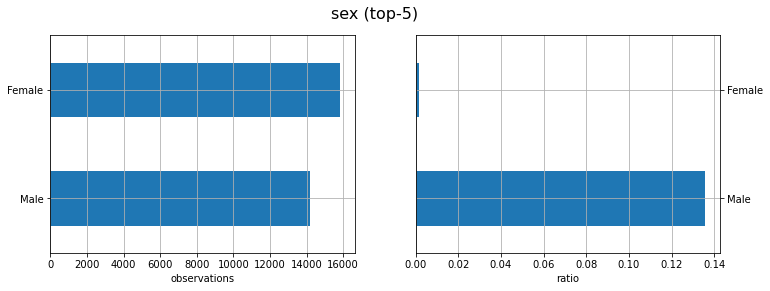

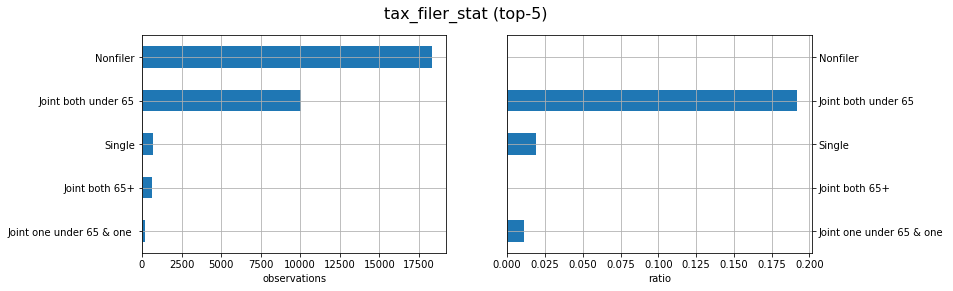

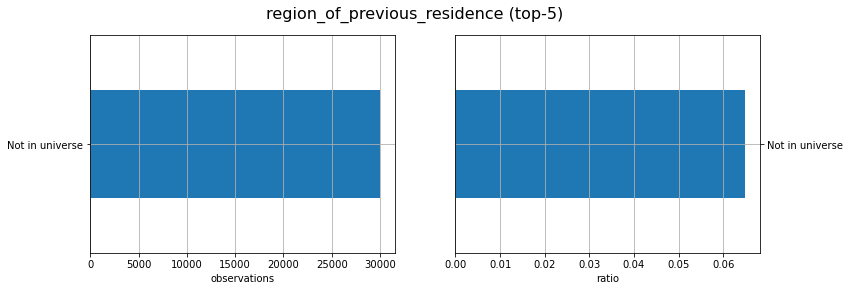

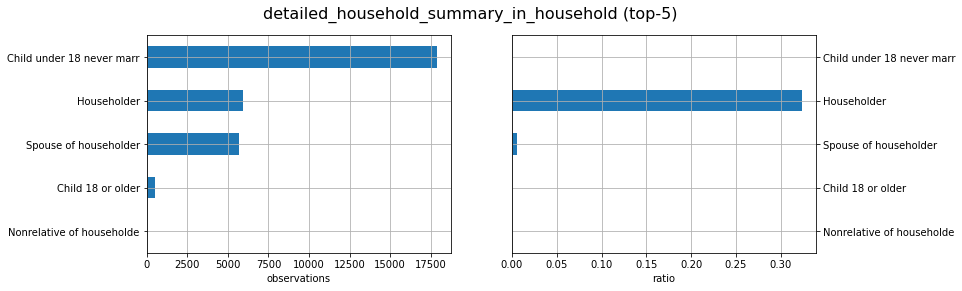

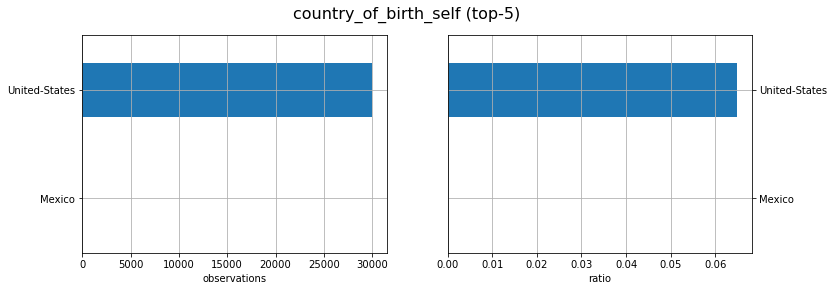

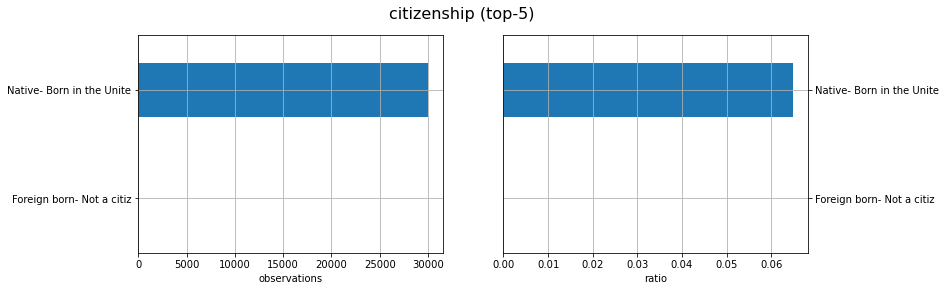

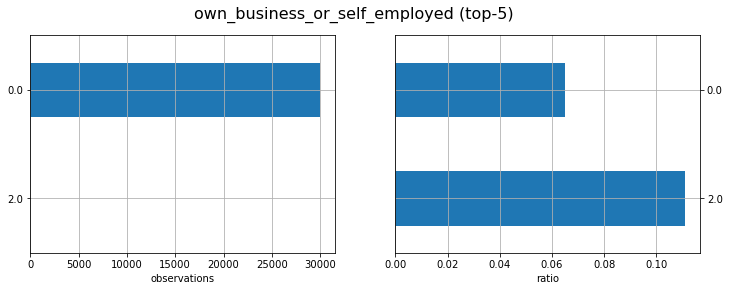

In [45]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_cerebras.drop(['target'], axis=1).assign(cnt=1, target=synt_data_cerebras['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Phi1.5 

In [46]:
synt_data_phi.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000                30000.0                     30000.000000   
mean      21.537867                    0.0                         1.693467   
std       19.629273                    0.0                         2.635565   
min        0.000000                    0.0                         0.000000   
25%        6.000000                    0.0                         0.000000   
50%       13.000000                    0.0                         0.000000   
75%       36.000000                    0.0                         6.000000   
max       90.000000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.001667             16.369933  
std                         0.057712             24.147614  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [47]:
print(synt_data_phi.isna().sum().sum())

0


In [48]:
synt_data_phi['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

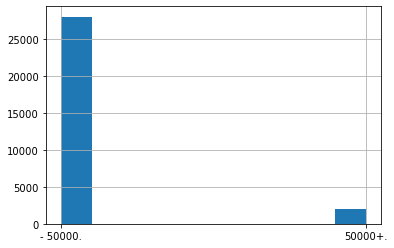

In [49]:
synt_data_phi['target'].hist()

In [50]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}% and {100-len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.49% and 93.51%


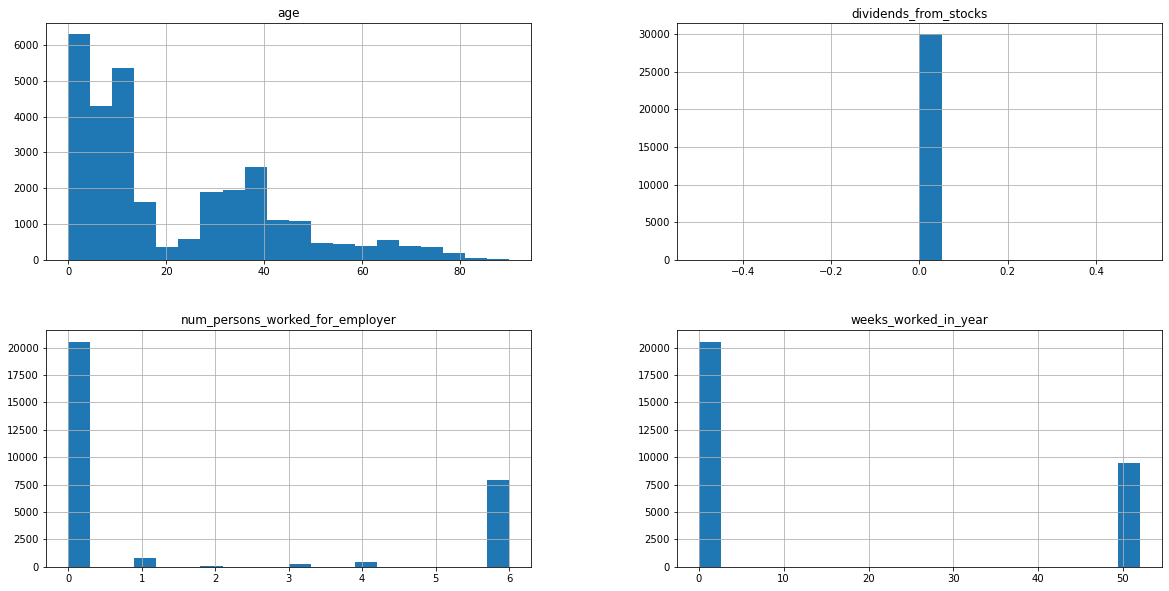

In [51]:
synt_data_phi[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

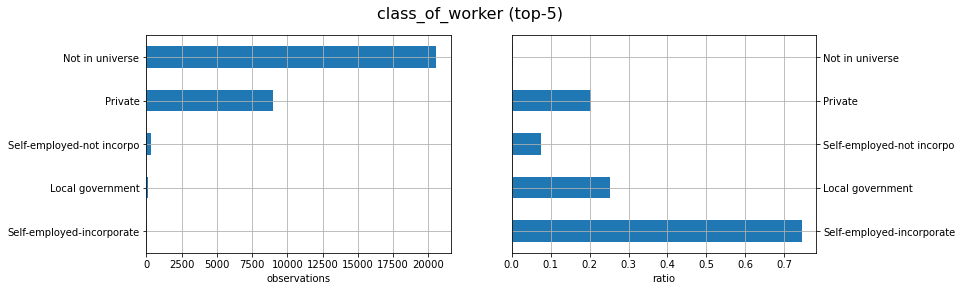

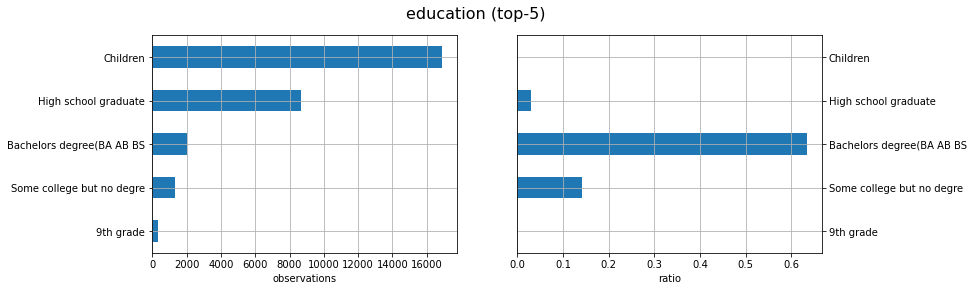

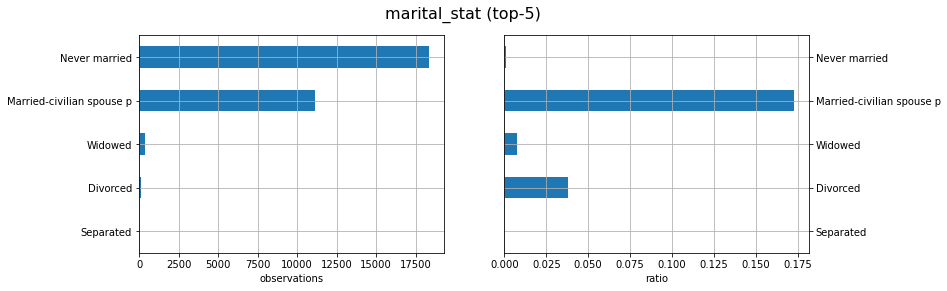

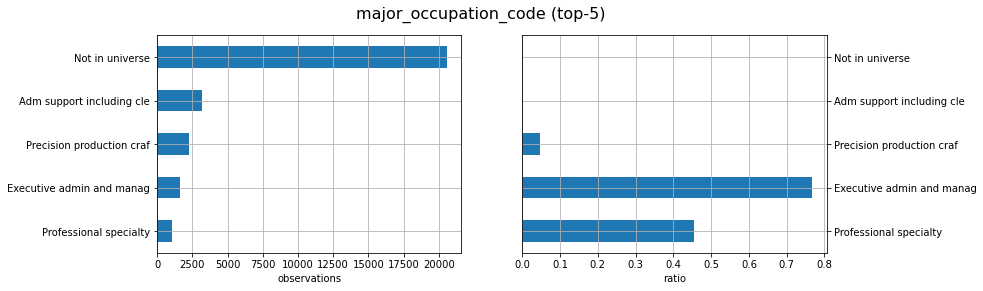

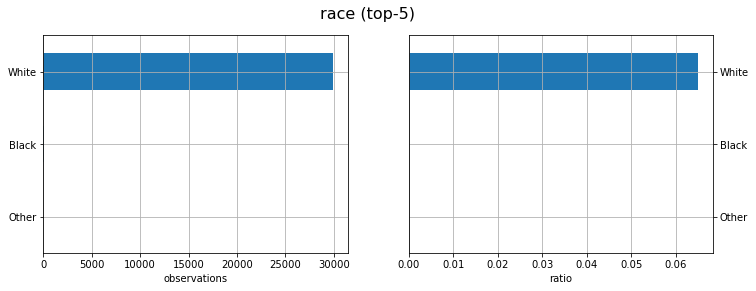

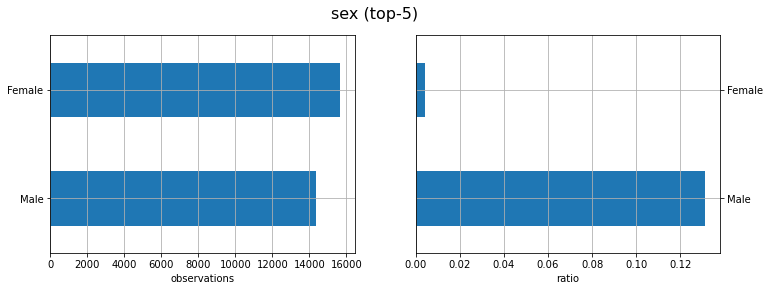

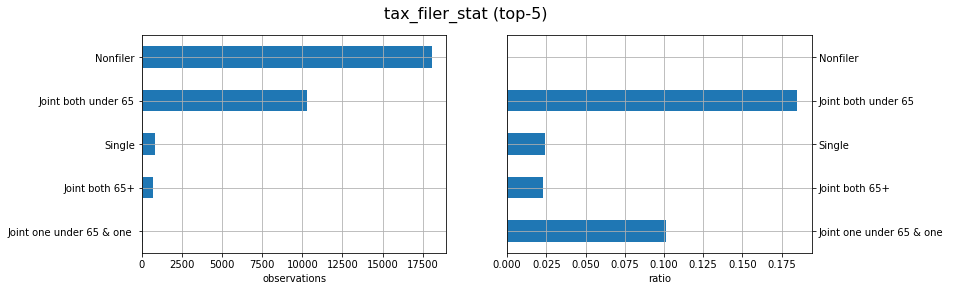

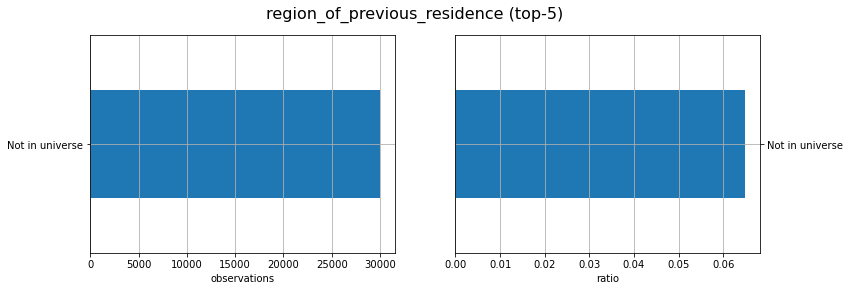

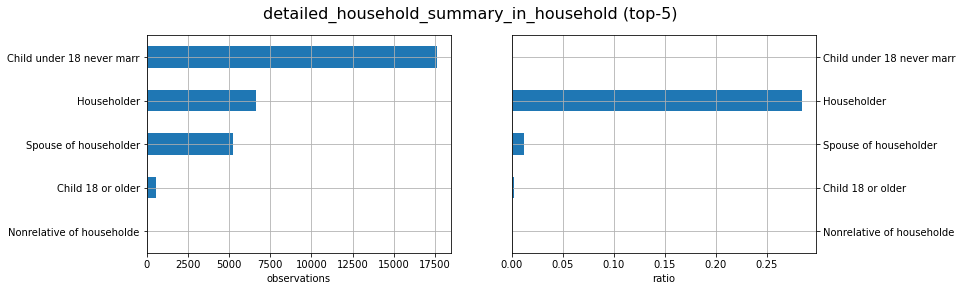

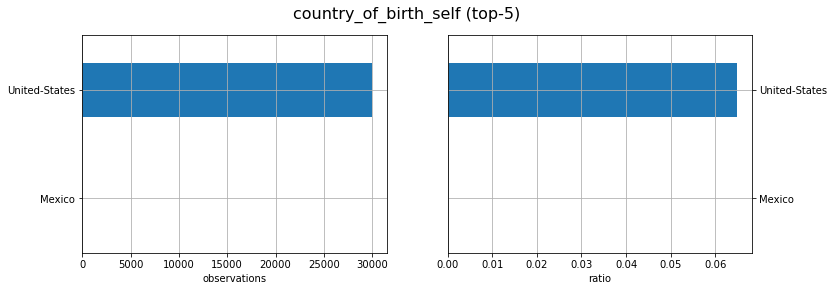

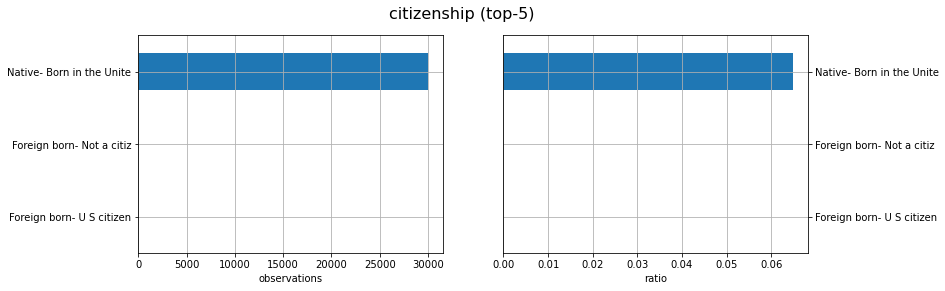

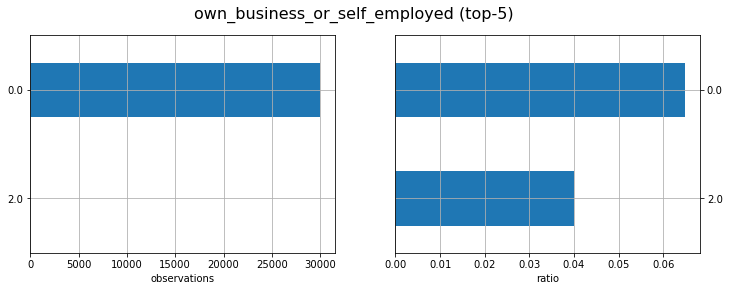

In [52]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_phi.drop(['target'], axis=1).assign(cnt=1, target=synt_data_phi['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Dataset comparsion

In [53]:
synt_datasets = dict()
synt_datasets['distilgpt2'] = synt_data_distilgpt2
synt_datasets['gpt2xl'] = synt_data_gpt2xl
synt_datasets['cerebras'] = synt_data_cerebras
synt_datasets['phi'] = synt_data_phi

In [54]:
cols_compare = dict()
for col in cols:
    cols_compare[col] = {}
    cols_compare[col]['real'] = real_dataset[col].to_numpy()
    for synt in synt_datasets:
        cols_compare[col][synt] = synt_datasets[synt][col].to_numpy()


In [55]:
all_data = list()
for col in cols :
    all_data.append((col,[x for x in [(i,cols_compare[col][i]) for i in cols_compare[col]]]))

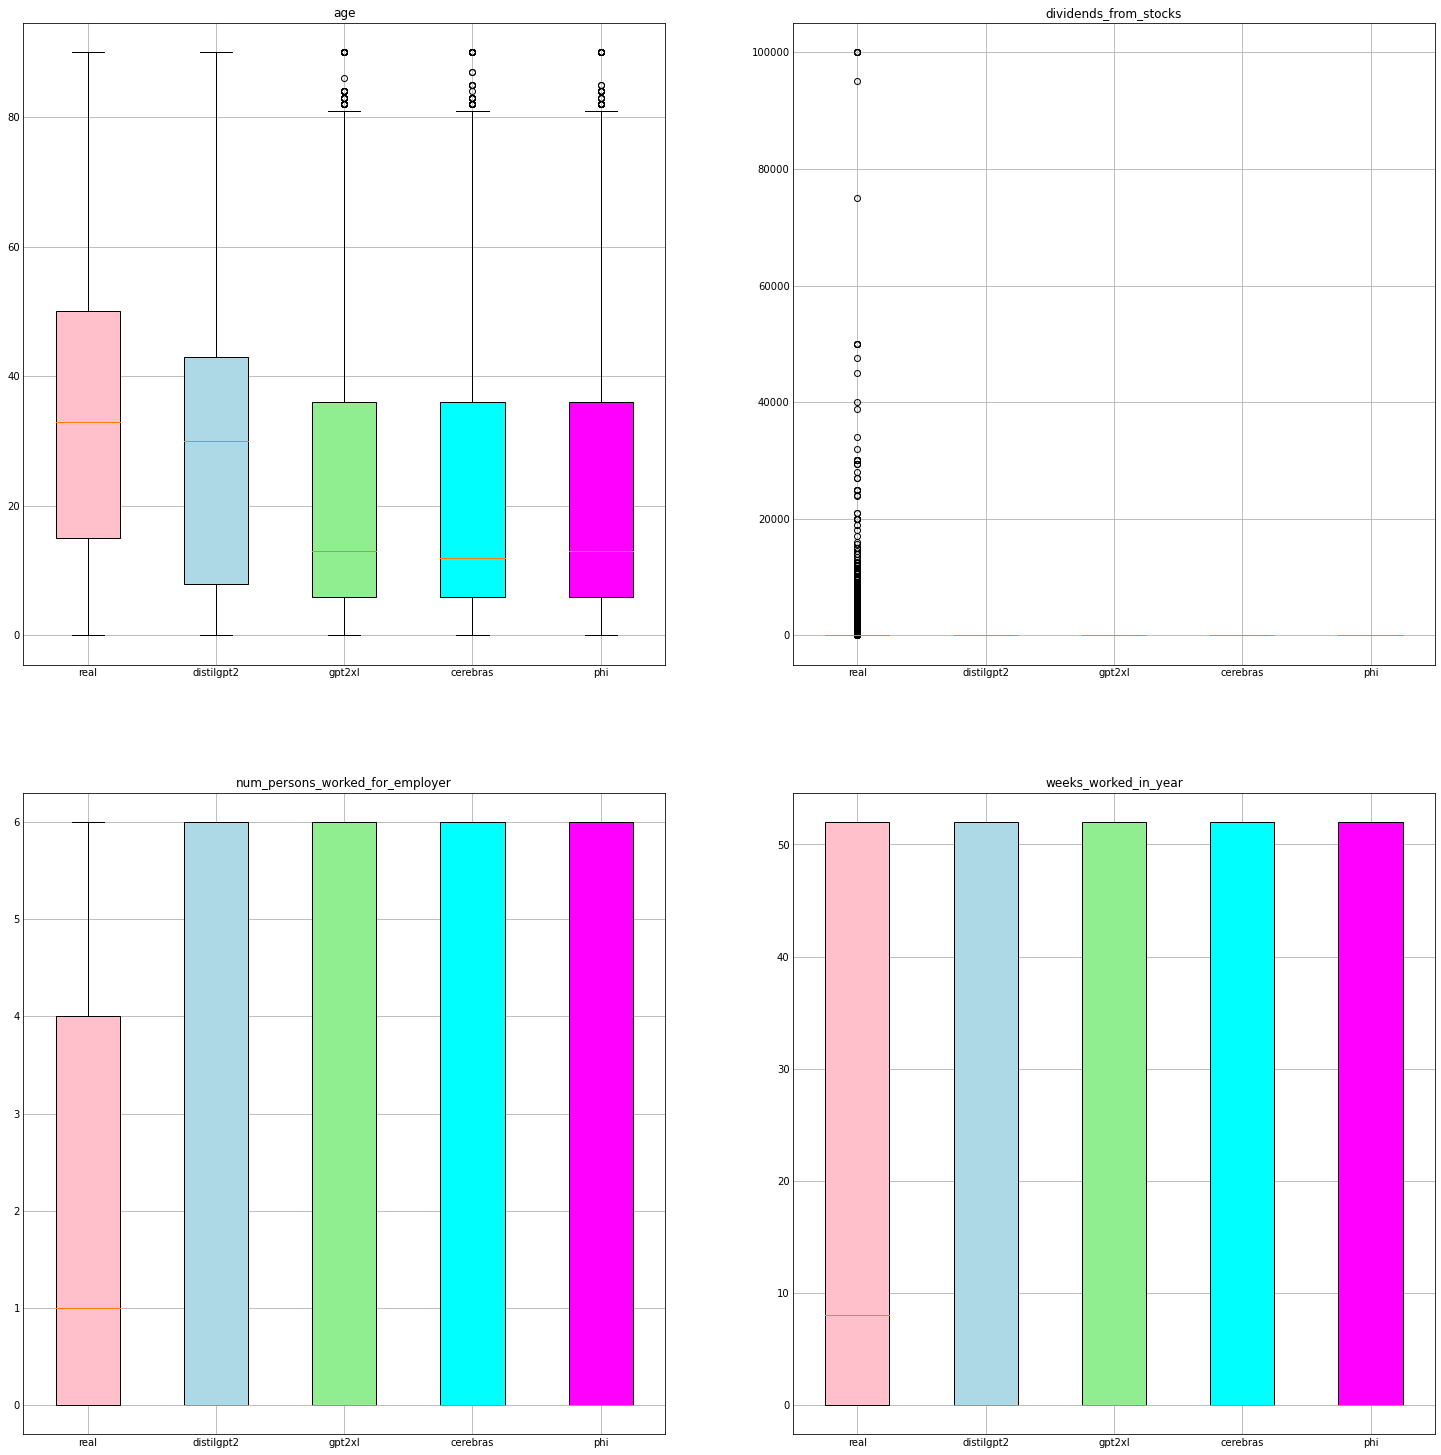

In [56]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
ncols=2
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
bplots = list()

i=0
for _, col in enumerate(all_data) :
    col_name = col[0]
    if not(col_name in numeric):
        continue
    col_data = col[1]
    rw = i//ncols
    cl = i%ncols
    i+=1
    axs[rw,cl].set_title(col_name)
     
    bplots.append(axs[rw,cl].boxplot([x[1] for x in col_data],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=[x[0] for x in col_data]))  # will be used to label x-ticks
           
#fill with colors
colors = ['pink', 'lightblue', 'lightgreen','cyan','magenta','yellow',]
for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

# Binary classification task on rough data

## General data preprocessing

In [57]:
to_encode = [i for i in categs]

In [58]:
to_encode

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [59]:
target_encoder= {' 50000+.': 1, 
                ' - 50000.': 0,
                '50000+.': 1, 
                '- 50000.': 0} 

In [60]:
edu_encoder= {' Children': 1, 
            ' Less than 1st grade': 2, 
            ' 1st 2nd 3rd or 4th grade': 3, 
            ' 5th or 6th grade': 4,
            ' 7th and 8th grade': 5, 
            ' 9th grade': 6, 
            ' 10th grade': 7, 
            ' 11th grade': 8 , 
            ' 12th grade no diploma': 9,
            ' High school graduate': 10, 
            ' Some college but no degree': 11, 
            ' Associates degree-occup /vocational': 12,
            ' Associates degree-academic program': 13, 
            ' Bachelors degree(BA AB BS)' : 14,
            ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
            ' Doctorate degree(PhD EdD)': 16,
            ' Prof school degree (MD DDS DVM LLB JD)': 17,
            'Children': 1, 
            'Less than 1st grade': 2, 
            '1st 2nd 3rd or 4th grade': 3, 
            '5th or 6th grade': 4,
            '7th and 8th grade': 5, 
            '9th grade': 6, 
            '10th grade': 7, 
            '11th grade': 8 , 
            '12th grade no diploma': 9,
            'High school graduate': 10, 
            'Some college but no degree': 11, 
            'Associates degree-occup /vocational': 12,
            'Associates degree-academic program': 13, 
            'Bachelors degree(BA AB BS)' : 14,
            'Masters degree(MA MS MEng MEd MSW MBA)': 15,
            'Doctorate degree(PhD EdD)': 16,
            'Prof school degree (MD DDS DVM LLB JD)': 17}
to_encode.remove('education')

## Real data preprocessing and classification modeling

### Data preprocessing

In [61]:
real_data = real_dataset.copy()

In [62]:
X_tr, X_te, y_tr, y_te = train_test_split(real_data.drop(columns = ['target']),real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [63]:
X_te_real_validate = X_te.copy()
y_te_real_validate = y_te.copy()

In [64]:
print(real_data['target'].unique(), len(real_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [65]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)

In [66]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [67]:
print(real_data['education'].unique(), len(real_data['education'].unique()))

['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate degree(PhD EdD)' '1st 2nd 3rd or 4th grade'
 'Associates degree-academic program' 'Less than 1st grade'
 '12th grade no diploma' 'Prof school degree (MD DDS DVM LLB JD)'] 17


In [68]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)

In [69]:
print(X_tr['education'].unique(), len(X_tr['education'].unique()))

[ 5 11  1 15 10 14  9 12  6  2 13  7  3  8  4 17 16] 17


In [70]:
to_encode_real = to_encode.copy() 

In [71]:
# mean target encoding
for i in to_encode_real.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes[x])
        to_encode_real.remove(i)

+ marital_stat
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ citizenship
+ own_business_or_self_employed


In [72]:
#frequency encoding 
for i in to_encode_real.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    to_encode_real.remove(i)

+ class_of_worker
+ major_occupation_code
+ detailed_household_summary_in_household
+ country_of_birth_self


In [73]:
to_encode_real

[]

In [74]:
print(X_tr.isna().sum().sum())
print(X_te.isna().sum().sum())

0
0


In [75]:
X_tr.dtypes

age                                          int64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                        int64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer              int64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                         int64
dtype: object

### Features selection

In [76]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.273832   0.554347   
class_of_worker                         -0.273832         1.000000  -0.586404   
education                                0.554347        -0.586404   1.000000   
marital_stat                             0.680123        -0.380808   0.535738   
major_occupation_code                   -0.235530         0.860999  -0.485680   
race                                     0.068959        -0.053021   0.100718   
sex                                     -0.038577        -0.094046   0.005064   
dividends_from_stocks                    0.256355        -0.134686   0.309286   
tax_filer_stat                           0.471370        -0.632230   0.660937   
region_of_previous_residence             0.090736         0.014371   0.001013   
detailed_household_summary_in_household  0.252836        -0.083663   0.108197   
num_persons_worked_for_employer          0.245655        -0.764200   0.587607   
country_of_birth_self                   -0.072291         0.035267  -0.025496   
citizenship                              0.046291        -0.014168   0.065853   
own_business_or_self_employed            0.030568        -0.269053   0.216898   
weeks_worked_in_year                     0.286815        -0.835988   0.604476   
target                                   0.169496        -0.241753   0.304604   

                                         marital_stat  major_occupation_code  \
age                                          0.680123              -0.235530   
class_of_worker                             -0.380808               0.860999   
education                                    0.535738              -0.485680   
marital_stat                                 1.000000              -0.337805   
major_occupation_code                       -0.337805               1.000000   
race                                         0.109519              -0.045462   
sex                                         -0.007314              -0.175800   
dividends_from_stocks                        0.230006              -0.079366   
tax_filer_stat                               0.760664              -0.601035   
region_of_previous_residence                 0.049349               0.022531   
detailed_household_summary_in_household      0.178682              -0.087470   
num_persons_worked_for_employer              0.359423              -0.736346   
country_of_birth_self                       -0.078488               0.064963   
citizenship                                  0.017042               0.017550   
own_business_or_self_employed                0.084303              -0.258446   
weeks_worked_in_year                         0.413837              -0.807133   
target                                       0.200576              -0.180488   

                                             race       sex  \
age                                      0.068959 -0.038577   
class_of_worker                         -0.053021 -0.094046   
education                                0.100718  0.005064   
marital_stat                             0.109519 -0.007314   
major_occupation_code                   -0.045462 -0.175800   
race                                     1.000000  0.022378   
sex                                      0.022378  1.000000   
dividends_from_stocks                    0.081465  0.031495   
tax_filer_stat                           0.114606  0.037119   
region_of_previous_residence             0.022446  0.001121   
detailed_household_summary_in_household  0.012262  0.242139   
num_persons_worked_for_employer          0.036247  0.072372   
country_of_birth_self                   -0.120298  0.014380   
citizenship                              0.001725  0.010086   
own_business_or_self_employed            0.030773  0.036088   
weeks_worked_in_year                     0.062989  0.110199   
target                                   0.056979  0.168318   

           

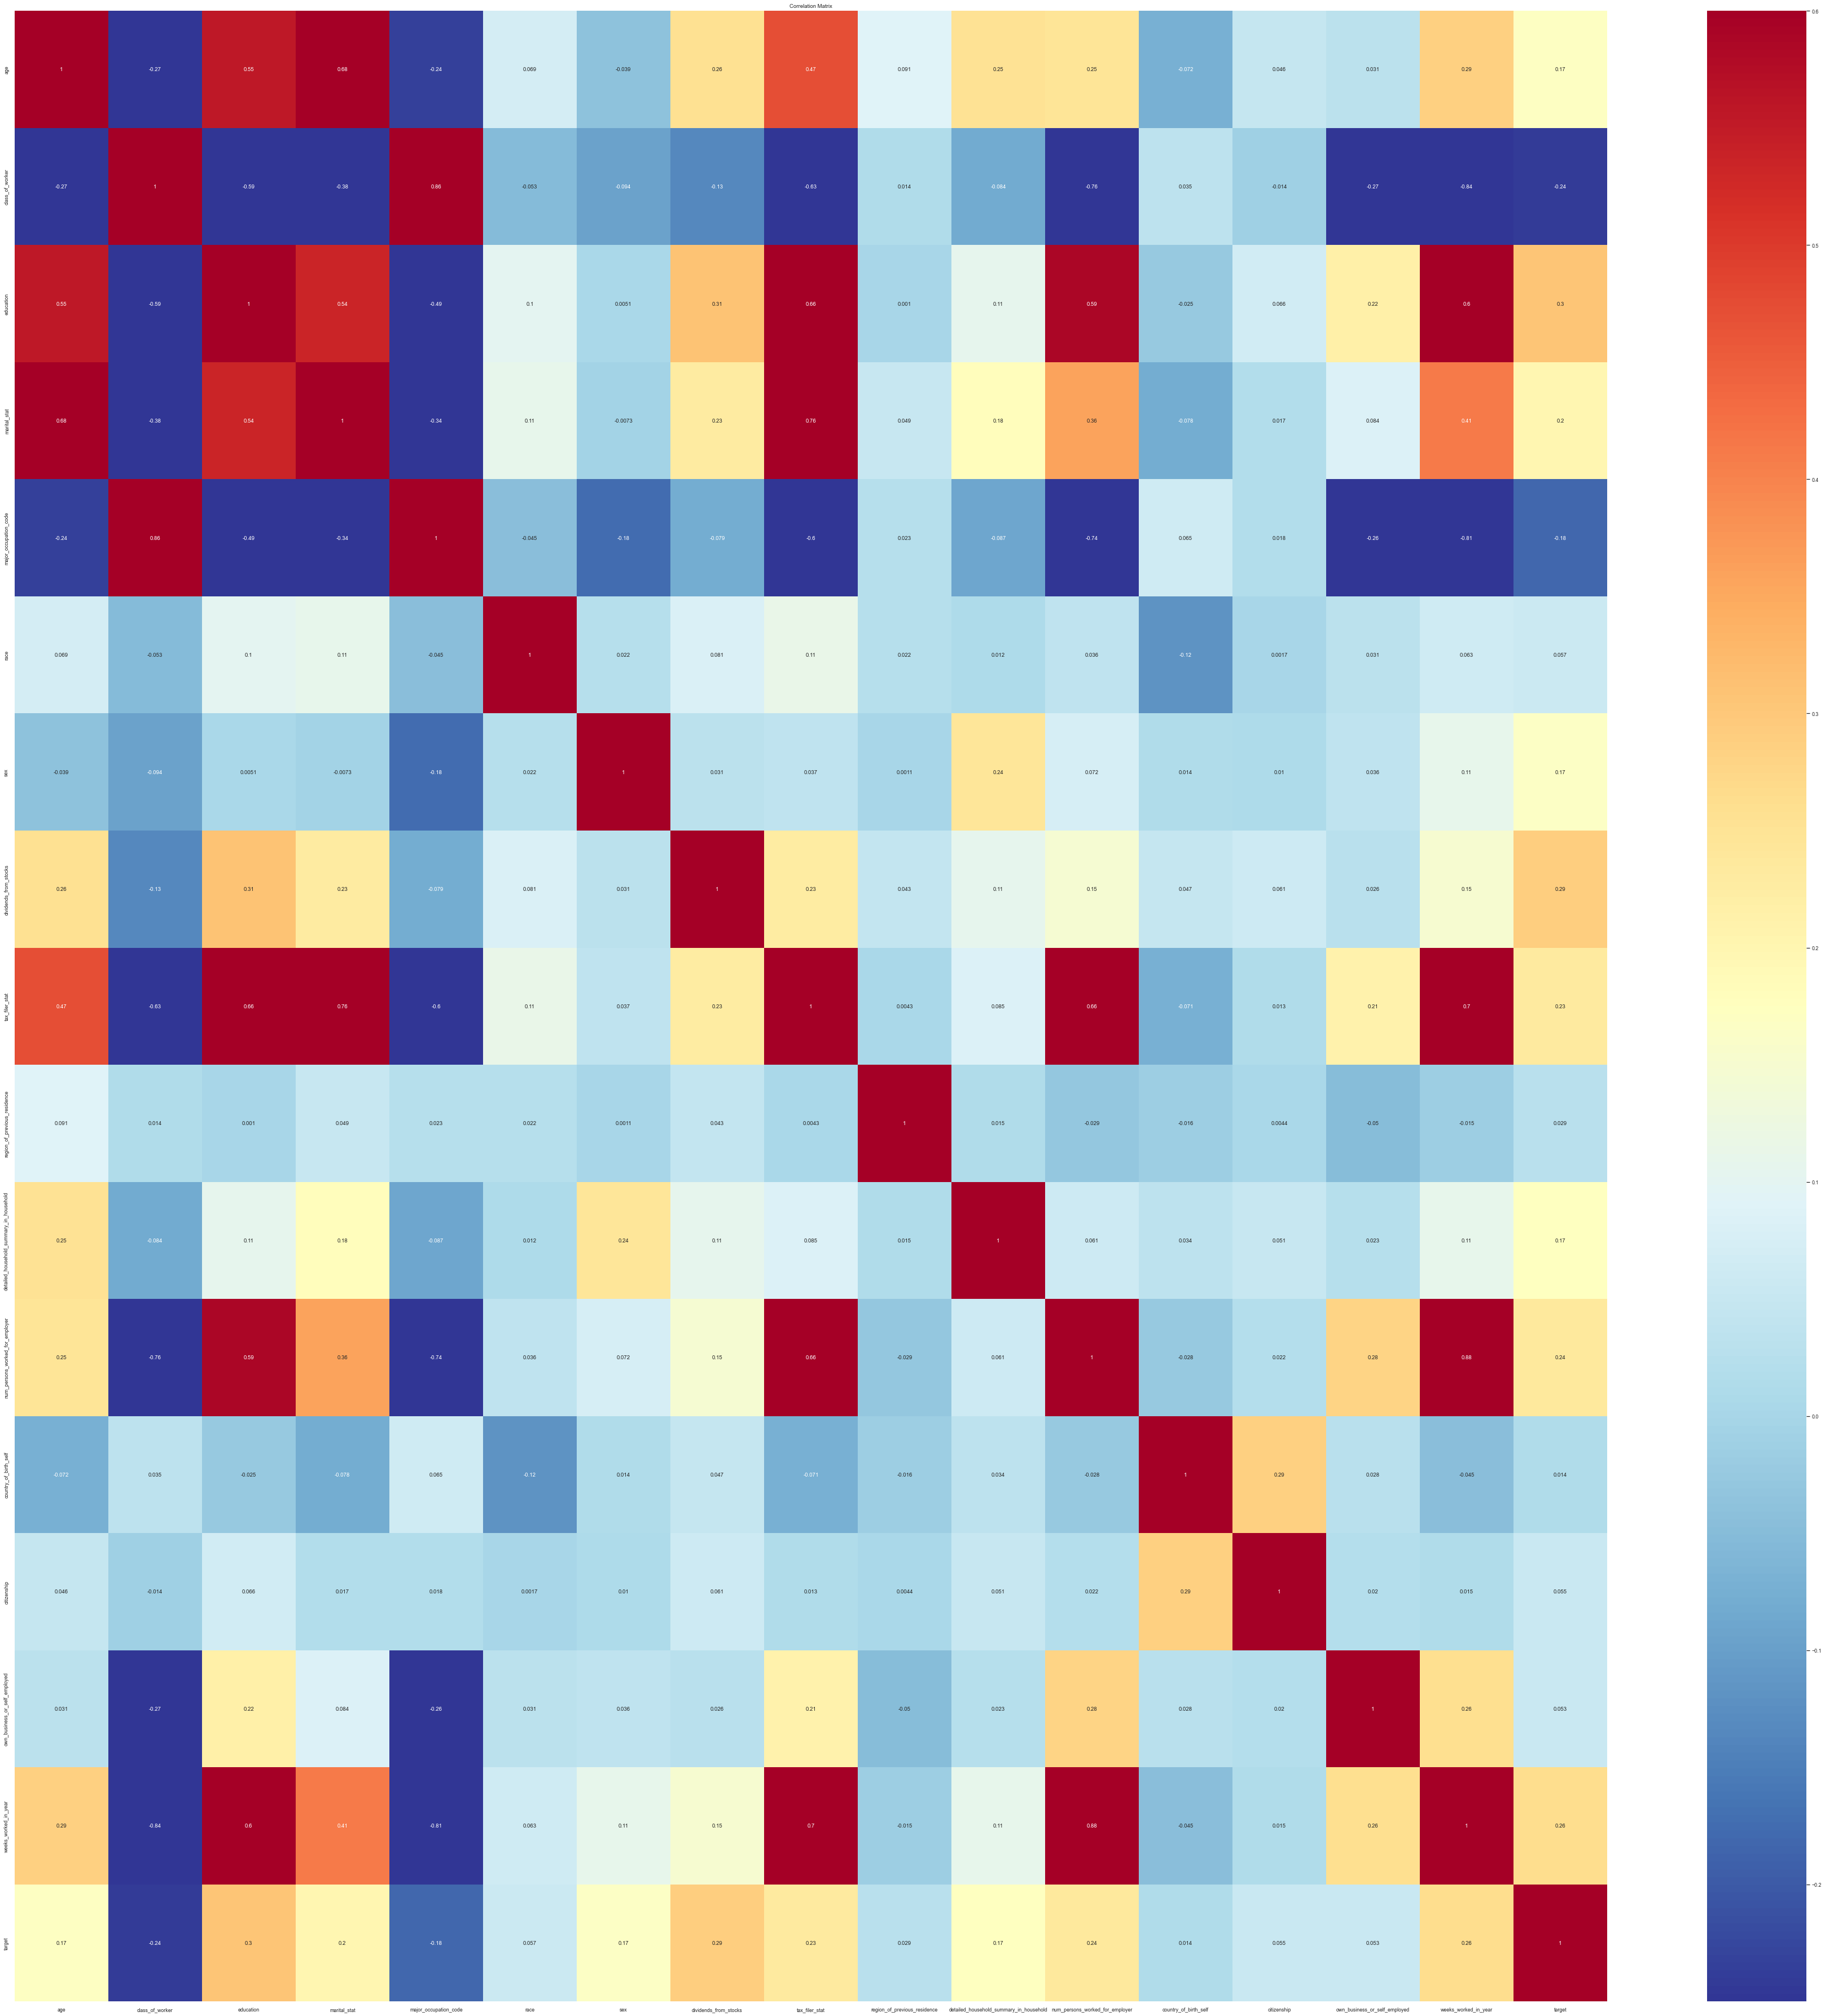

In [77]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [78]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 3
The number of features remaining: 13


In [79]:
del_features

array(['class_of_worker', 'major_occupation_code',
       'num_persons_worked_for_employer'], dtype='<U31')

In [80]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 13


In [81]:
real_model_features = count_features.copy()
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic Regression

In [82]:
#X_tr, X_te_real, y_tr, y_te_real = train_test_split(real_data[count_features],real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [83]:
X_tr = X_tr[count_features]
X_te = X_te[count_features]

In [84]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr, y_tr)

CPU times: total: 438 ms
Wall time: 551 ms


In [85]:
log_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR', LogisticRegression())
])

log_parameters = {
    'LR__solver': ['saga'],
    'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}


In [86]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.838 total time=   0.4s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.823 total time=   0.5s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.830 total time=   0.5s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.839 total time=   0.4s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.825 total time=   0.4s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.848 total time=   0.4s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.845 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.840 total time=   0.4s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.835 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.852 total time=   0.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [87]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.8464060619430963
LogisticRegression(C=0.1, solver='saga')


In [88]:
y_pred_test = grid_pipe_log.best_estimator_.predict(X_te)

In [89]:
model_results = pd.DataFrame(columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test = pd.DataFrame([['LogRegression Real data','Real test',
                        balanced_accuracy_score(y_te, y_pred_test),
                        recall_score(y_te, y_pred_test),
                        precision_score(y_te, y_pred_test),
                        roc_auc_score(y_te, y_pred_test)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\616206078.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, res_test],axis=0)


In [90]:
res_test

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

In [91]:
model_results

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

## DistillGPT2 classification

### Data preprocessing 

In [92]:
synt_data = synt_data_distilgpt2.copy()

In [93]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [94]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [95]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [96]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [97]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [98]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Some college but no degree' 'High school graduate'
 'Bachelors degree(BA AB BS)' '7th and 8th grade' 'Children' '9th grade'
 '10th grade' '11th grade' 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-academic program'
 'Associates degree-occup /vocational' 'Doctorate degree(PhD EdD)'
 '5th or 6th grade' 'Prof school degree (MD DDS DVM LLB JD)'
 'Bachelors degree(BABABABABA)' '12th grade no diploma'] 16


In [99]:
for edu in synt_data['education'].unique():
    if edu in edu_encoder.keys() :
        continue
    else :
        edu_encoder[edu] = 0
        print (edu)
edu_encoder

Bachelors degree(BABABABABA)


{' Children': 1,
 ' Less than 1st grade': 2,
 ' 1st 2nd 3rd or 4th grade': 3,
 ' 5th or 6th grade': 4,
 ' 7th and 8th grade': 5,
 ' 9th grade': 6,
 ' 10th grade': 7,
 ' 11th grade': 8,
 ' 12th grade no diploma': 9,
 ' High school graduate': 10,
 ' Some college but no degree': 11,
 ' Associates degree-occup /vocational': 12,
 ' Associates degree-academic program': 13,
 ' Bachelors degree(BA AB BS)': 14,
 ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
 ' Doctorate degree(PhD EdD)': 16,
 ' Prof school degree (MD DDS DVM LLB JD)': 17,
 'Children': 1,
 'Less than 1st grade': 2,
 '1st 2nd 3rd or 4th grade': 3,
 '5th or 6th grade': 4,
 '7th and 8th grade': 5,
 '9th grade': 6,
 '10th grade': 7,
 '11th grade': 8,
 '12th grade no diploma': 9,
 'High school graduate': 10,
 'Some college but no degree': 11,
 'Associates degree-occup /vocational': 12,
 'Associates degree-academic program': 13,
 'Bachelors degree(BA AB BS)': 14,
 'Masters degree(MA MS MEng MEd MSW MBA)': 15,
 'Doctorate degree(PhD E

In [100]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [101]:
to_encode_synt = to_encode.copy() 

In [102]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ class_of_worker
+ major_occupation_code
+ race
+ sex
+ country_of_birth_self
+ own_business_or_self_employed


In [103]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ marital_stat
+ tax_filer_stat
+ region_of_previous_residence
+ detailed_household_summary_in_household
+ citizenship


In [104]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [105]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [106]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000         0.325810   0.766630   
class_of_worker                          0.325810         1.000000   0.624381   
education                                0.766630         0.624381   1.000000   
marital_stat                             0.662840         0.525333   0.719657   
major_occupation_code                    0.267039         0.759220   0.529169   
race                                     0.029849         0.018571   0.027681   
sex                                      0.016985         0.074768   0.035626   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.721253        -0.563996  -0.797282   
region_of_previous_residence             0.004343         0.004378   0.007374   
detailed_household_summary_in_household -0.735843        -0.507400  -0.830067   
num_persons_worked_for_employer          0.324602         0.970560   0.626585   
country_of_birth_self                    0.011167         0.001887   0.011544   
citizenship                             -0.012694        -0.004223  -0.012062   
own_business_or_self_employed            0.005474         0.042573   0.031210   
weeks_worked_in_year                     0.327963         0.984496   0.629064   
target                                   0.196824         0.155695   0.221279   

                                         marital_stat  major_occupation_code  \
age                                          0.662840               0.267039   
class_of_worker                              0.525333               0.759220   
education                                    0.719657               0.529169   
marital_stat                                 1.000000               0.439384   
major_occupation_code                        0.439384               1.000000   
race                                         0.035645               0.016507   
sex                                          0.019276               0.075189   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                              -0.731008              -0.409787   
region_of_previous_residence                 0.005823               0.003337   
detailed_household_summary_in_household     -0.708723              -0.372440   
num_persons_worked_for_employer              0.523055               0.749700   
country_of_birth_self                        0.007707               0.006073   
citizenship                                 -0.009110              -0.007927   
own_business_or_self_employed                0.004119               0.036446   
weeks_worked_in_year                         0.527910               0.752484   
target                                       0.179197               0.188495   

                                             race       sex  \
age                                      0.029849  0.016985   
class_of_worker                          0.018571  0.074768   
education                                0.027681  0.035626   
marital_stat                             0.035645  0.019276   
major_occupation_code                    0.016507  0.075189   
race                                     1.000000  0.003218   
sex                                      0.003218  1.000000   
dividends_from_stocks                         NaN       NaN   
tax_filer_stat                          -0.033330 -0.019950   
region_of_previous_residence            -0.000369 -0.006938   
detailed_household_summary_in_household -0.032324  0.201505   
num_persons_worked_for_employer          0.018017  0.068788   
country_of_birth_self                    0.001380  0.008665   
citizenship                             -0.001428 -0.006819   
own_business_or_self_employed            0.001649  0.016562   
weeks_worked_in_year                     0.018798  0.071227   
target                                   0.012074  0.093964   

           

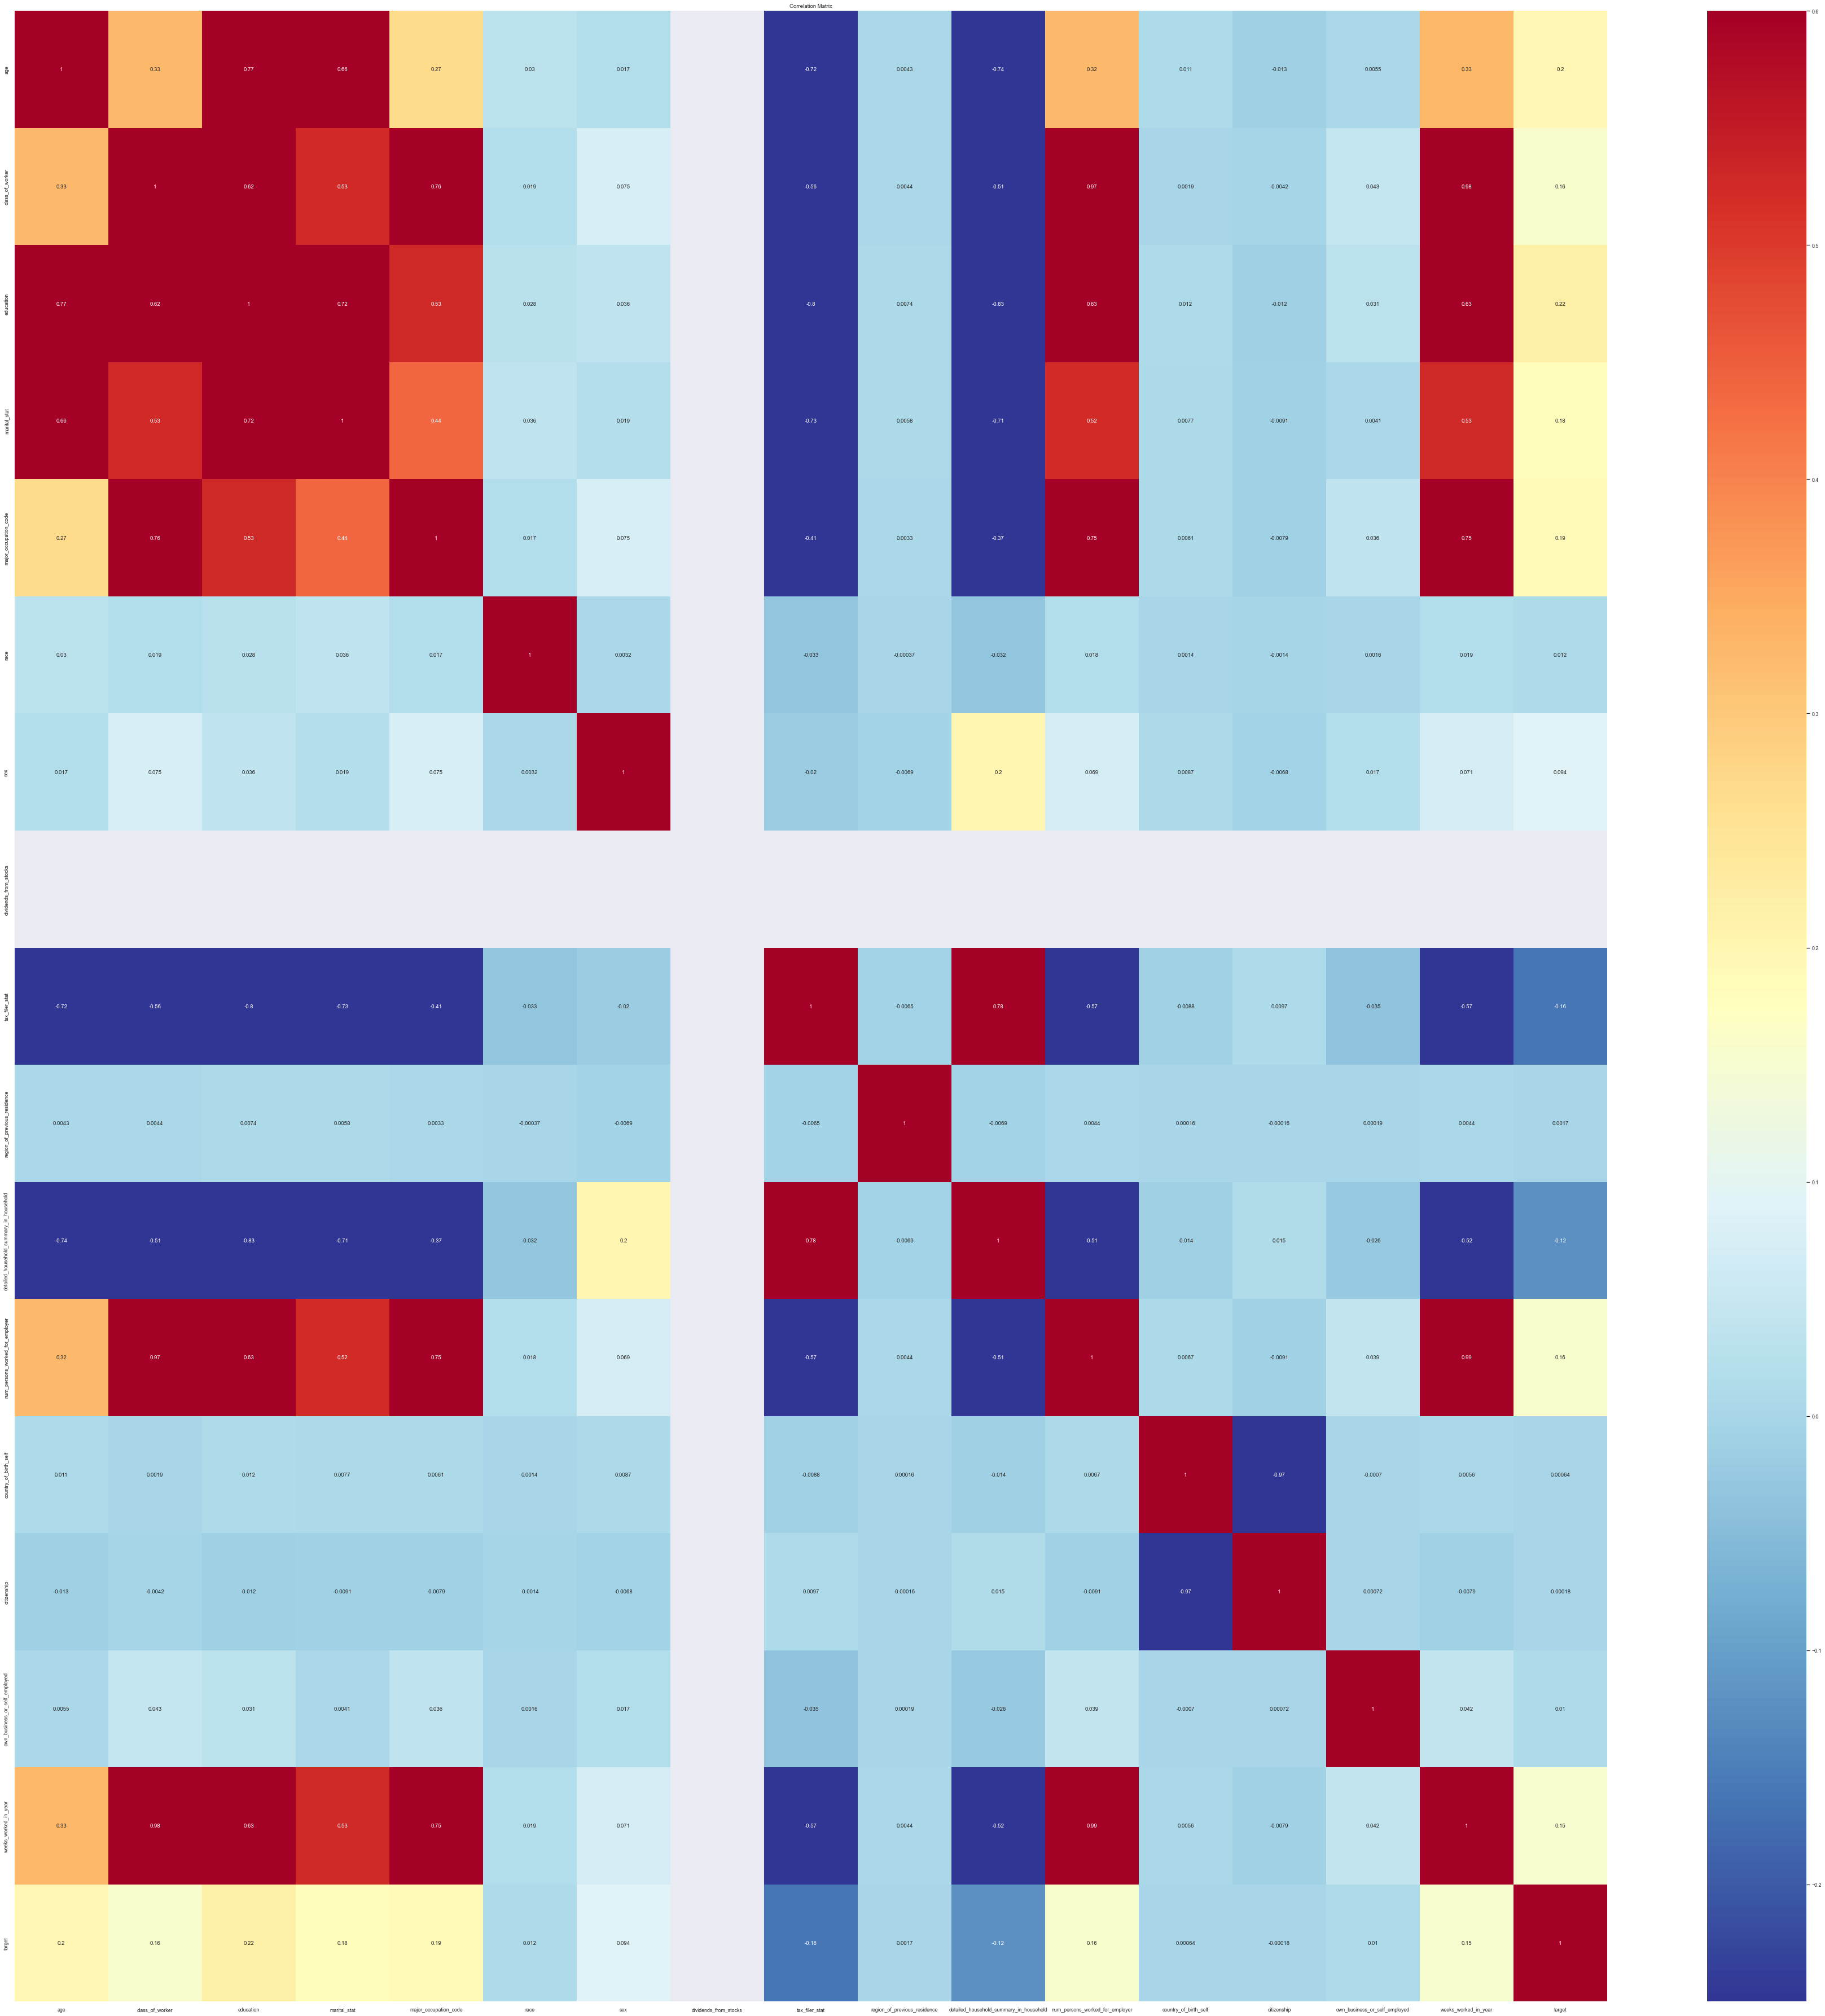

In [107]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [108]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 4
The number of features remaining: 12


In [109]:
del_features

array(['citizenship', 'class_of_worker',
       'detailed_household_summary_in_household', 'weeks_worked_in_year'],
      dtype='<U39')

In [110]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 12


In [111]:
sorted(count_features)

['age',
 'country_of_birth_self',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'marital_stat',
 'num_persons_worked_for_employer',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat']

In [112]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [113]:
#X_tr, X_te, y_tr, y_te = train_test_split(synt_data[real_model_features],synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [114]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [115]:
X_te1.isna().sum()

age                                0
education                          0
marital_stat                       0
major_occupation_code              0
race                               0
sex                                0
dividends_from_stocks              0
tax_filer_stat                     0
region_of_previous_residence       0
num_persons_worked_for_employer    0
country_of_birth_self              0
own_business_or_self_employed      0
dtype: int64

In [116]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [117]:
X_te_real1.isna().sum()

age                                  0
education                            0
marital_stat                        26
major_occupation_code                0
race                                 0
sex                                  0
dividends_from_stocks                0
tax_filer_stat                       0
region_of_previous_residence       299
num_persons_worked_for_employer      0
country_of_birth_self                0
own_business_or_self_employed        0
dtype: int64

In [118]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                26
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence               299
detailed_household_summary_in_household      5
country_of_birth_self                        0
citizenship                                511
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [119]:
sorted(synt_data['citizenship'].unique()) 


['Foreign born- Not a citizen of U S',
 'Foreign born- U S citizen by naturalization',
 'Native- Born in the United States']

In [120]:
sorted(real_data['citizenship'].unique())

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [121]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, inpl

In [122]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 250 ms
Wall time: 244 ms


In [123]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.723 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.701 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.691 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.698 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.719 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.732 total time=   1.5s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.715 total time=   1.3s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.695 total time=   0.3s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.704 total time=   1.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.731 total time=   1.3s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.735 total time=   2.4s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.718 total time=   2.4s
[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.692 total time=   0.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.705 total time=   2.3s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.729 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.736 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.718 total time=   2.3s
[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.692 total time=   0.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.705 total time=   2.3s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.729 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.736 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.718 total time=   2.1s
[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.692 total time=   0.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.705 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.729 total time=   2.0s
CPU times: total: 48.9 s
Wall time: 49.9 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [124]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7160423419211326
LogisticRegression(C=0.1, solver='saga')


In [125]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)


In [126]:
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [127]:
res_test11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test11, res_test_real11],axis=0)

In [128]:
res_test11

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Synth test           0.746531   

     Recall  Precision   ROC_AUC  
0  0.820513   0.148354  0.746531

In [129]:
res_test_real11

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Real test           0.737641   

     Recall  Precision   ROC_AUC  
0  0.791005   0.144166  0.737641

In [130]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 297 ms
Wall time: 302 ms


In [131]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.707 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.690 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.680 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.695 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.697 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.717 total time=   1.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.705 total time=   0.9s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.693 total time=   0.3s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.705 total time=   1.0s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.719 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.719 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.711 total time=   2.2s
[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.692 total time=   0.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.710 total time=   2.1s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.721 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.721 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.710 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.693 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.710 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.721 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.722 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.709 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.693 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.710 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.720 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.722 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.709 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.693 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.710 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.720 total time=   2.2s
CPU times: total: 53.3 s
Wall time: 53.7 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [132]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7110242175317902
LogisticRegression(C=0.1, solver='saga')


In [133]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)


In [134]:
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [135]:
res_test12 = pd.DataFrame([['LogRegression DistillGPT real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real12 = pd.DataFrame([['LogRegression DistillGPT real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test12, res_test_real12],axis=0)

In [136]:
res_test12

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Synth test           0.724572   

     Recall  Precision   ROC_AUC  
0  0.817949   0.133585  0.724572

In [137]:
res_test_real12

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Real test           0.742647   

     Recall  Precision   ROC_AUC  
0  0.743386    0.16224  0.742647

## GPT2XL classification

### Data preprocessing 

In [138]:
synt_data = synt_data_gpt2xl.copy()

In [139]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [140]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [141]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [142]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [143]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' '9th grade' 'High school graduate'
 'Bachelors degree(BA AB BS)' 'Masters degree(MA MS MEng MEd MSW MBA)'
 '11th grade' 'Some college but no degree' '10th grade'
 '7th and 8th grade' 'Associates degree-occup /vocational'
 'Associates degree-academic program'
 'Prof school degree (MD DDS DVM LLB JD)' 'Doctorate degree(PhD EdD)'
 '5th or 6th grade'] 14


In [144]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [145]:
to_encode_synt = to_encode.copy() 

In [146]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ sex
+ region_of_previous_residence
+ own_business_or_self_employed


In [147]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ tax_filer_stat
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship


In [148]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [149]:
X_tr.fillna(0,inplace=True)

In [150]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [151]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.598407   0.837311   
class_of_worker                         -0.598407         1.000000  -0.794787   
education                                0.837311        -0.794787   1.000000   
marital_stat                            -0.843094         0.716518  -0.895319   
major_occupation_code                   -0.588716         0.979414  -0.797509   
race                                     0.004866        -0.008942   0.010701   
sex                                      0.012111        -0.130026   0.054270   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.805225         0.760701  -0.906071   
region_of_previous_residence                  NaN              NaN        NaN   
detailed_household_summary_in_household -0.805452         0.720087  -0.905056   
num_persons_worked_for_employer          0.594314        -0.983293   0.795769   
country_of_birth_self                   -0.005800        -0.001465  -0.001924   
citizenship                             -0.005800        -0.001465  -0.001924   
own_business_or_self_employed            0.014057        -0.040796   0.036303   
weeks_worked_in_year                     0.598984        -0.995161   0.797456   
target                                   0.302117        -0.398985   0.449846   

                                         marital_stat  major_occupation_code  \
age                                         -0.843094              -0.588716   
class_of_worker                              0.716518               0.979414   
education                                   -0.895319              -0.797509   
marital_stat                                 1.000000               0.697019   
major_occupation_code                        0.697019               1.000000   
race                                        -0.016546              -0.006141   
sex                                          0.007646              -0.177520   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                               0.875393               0.749753   
region_of_previous_residence                      NaN                    NaN   
detailed_household_summary_in_household      0.883336               0.692594   
num_persons_worked_for_employer             -0.711592              -0.969720   
country_of_birth_self                        0.009279               0.000423   
citizenship                                  0.009279               0.000423   
own_business_or_self_employed               -0.018562              -0.047346   
weeks_worked_in_year                        -0.718206              -0.978184   
target                                      -0.319663              -0.455519   

                                             race       sex  \
age                                      0.004866  0.012111   
class_of_worker                         -0.008942 -0.130026   
education                                0.010701  0.054270   
marital_stat                            -0.016546  0.007646   
major_occupation_code                   -0.006141 -0.177520   
race                                     1.000000  0.010201   
sex                                      0.010201  1.000000   
dividends_from_stocks                         NaN       NaN   
tax_filer_stat                          -0.014592 -0.019987   
region_of_previous_residence                  NaN       NaN   
detailed_household_summary_in_household -0.003749  0.125920   
num_persons_worked_for_employer          0.008840  0.123112   
country_of_birth_self                   -0.000613  0.005885   
citizenship                             -0.000613  0.005885   
own_business_or_self_employed            0.001227  0.010850   
weeks_worked_in_year                     0.009874  0.128460   
target                                   0.012491  0.264543   

           

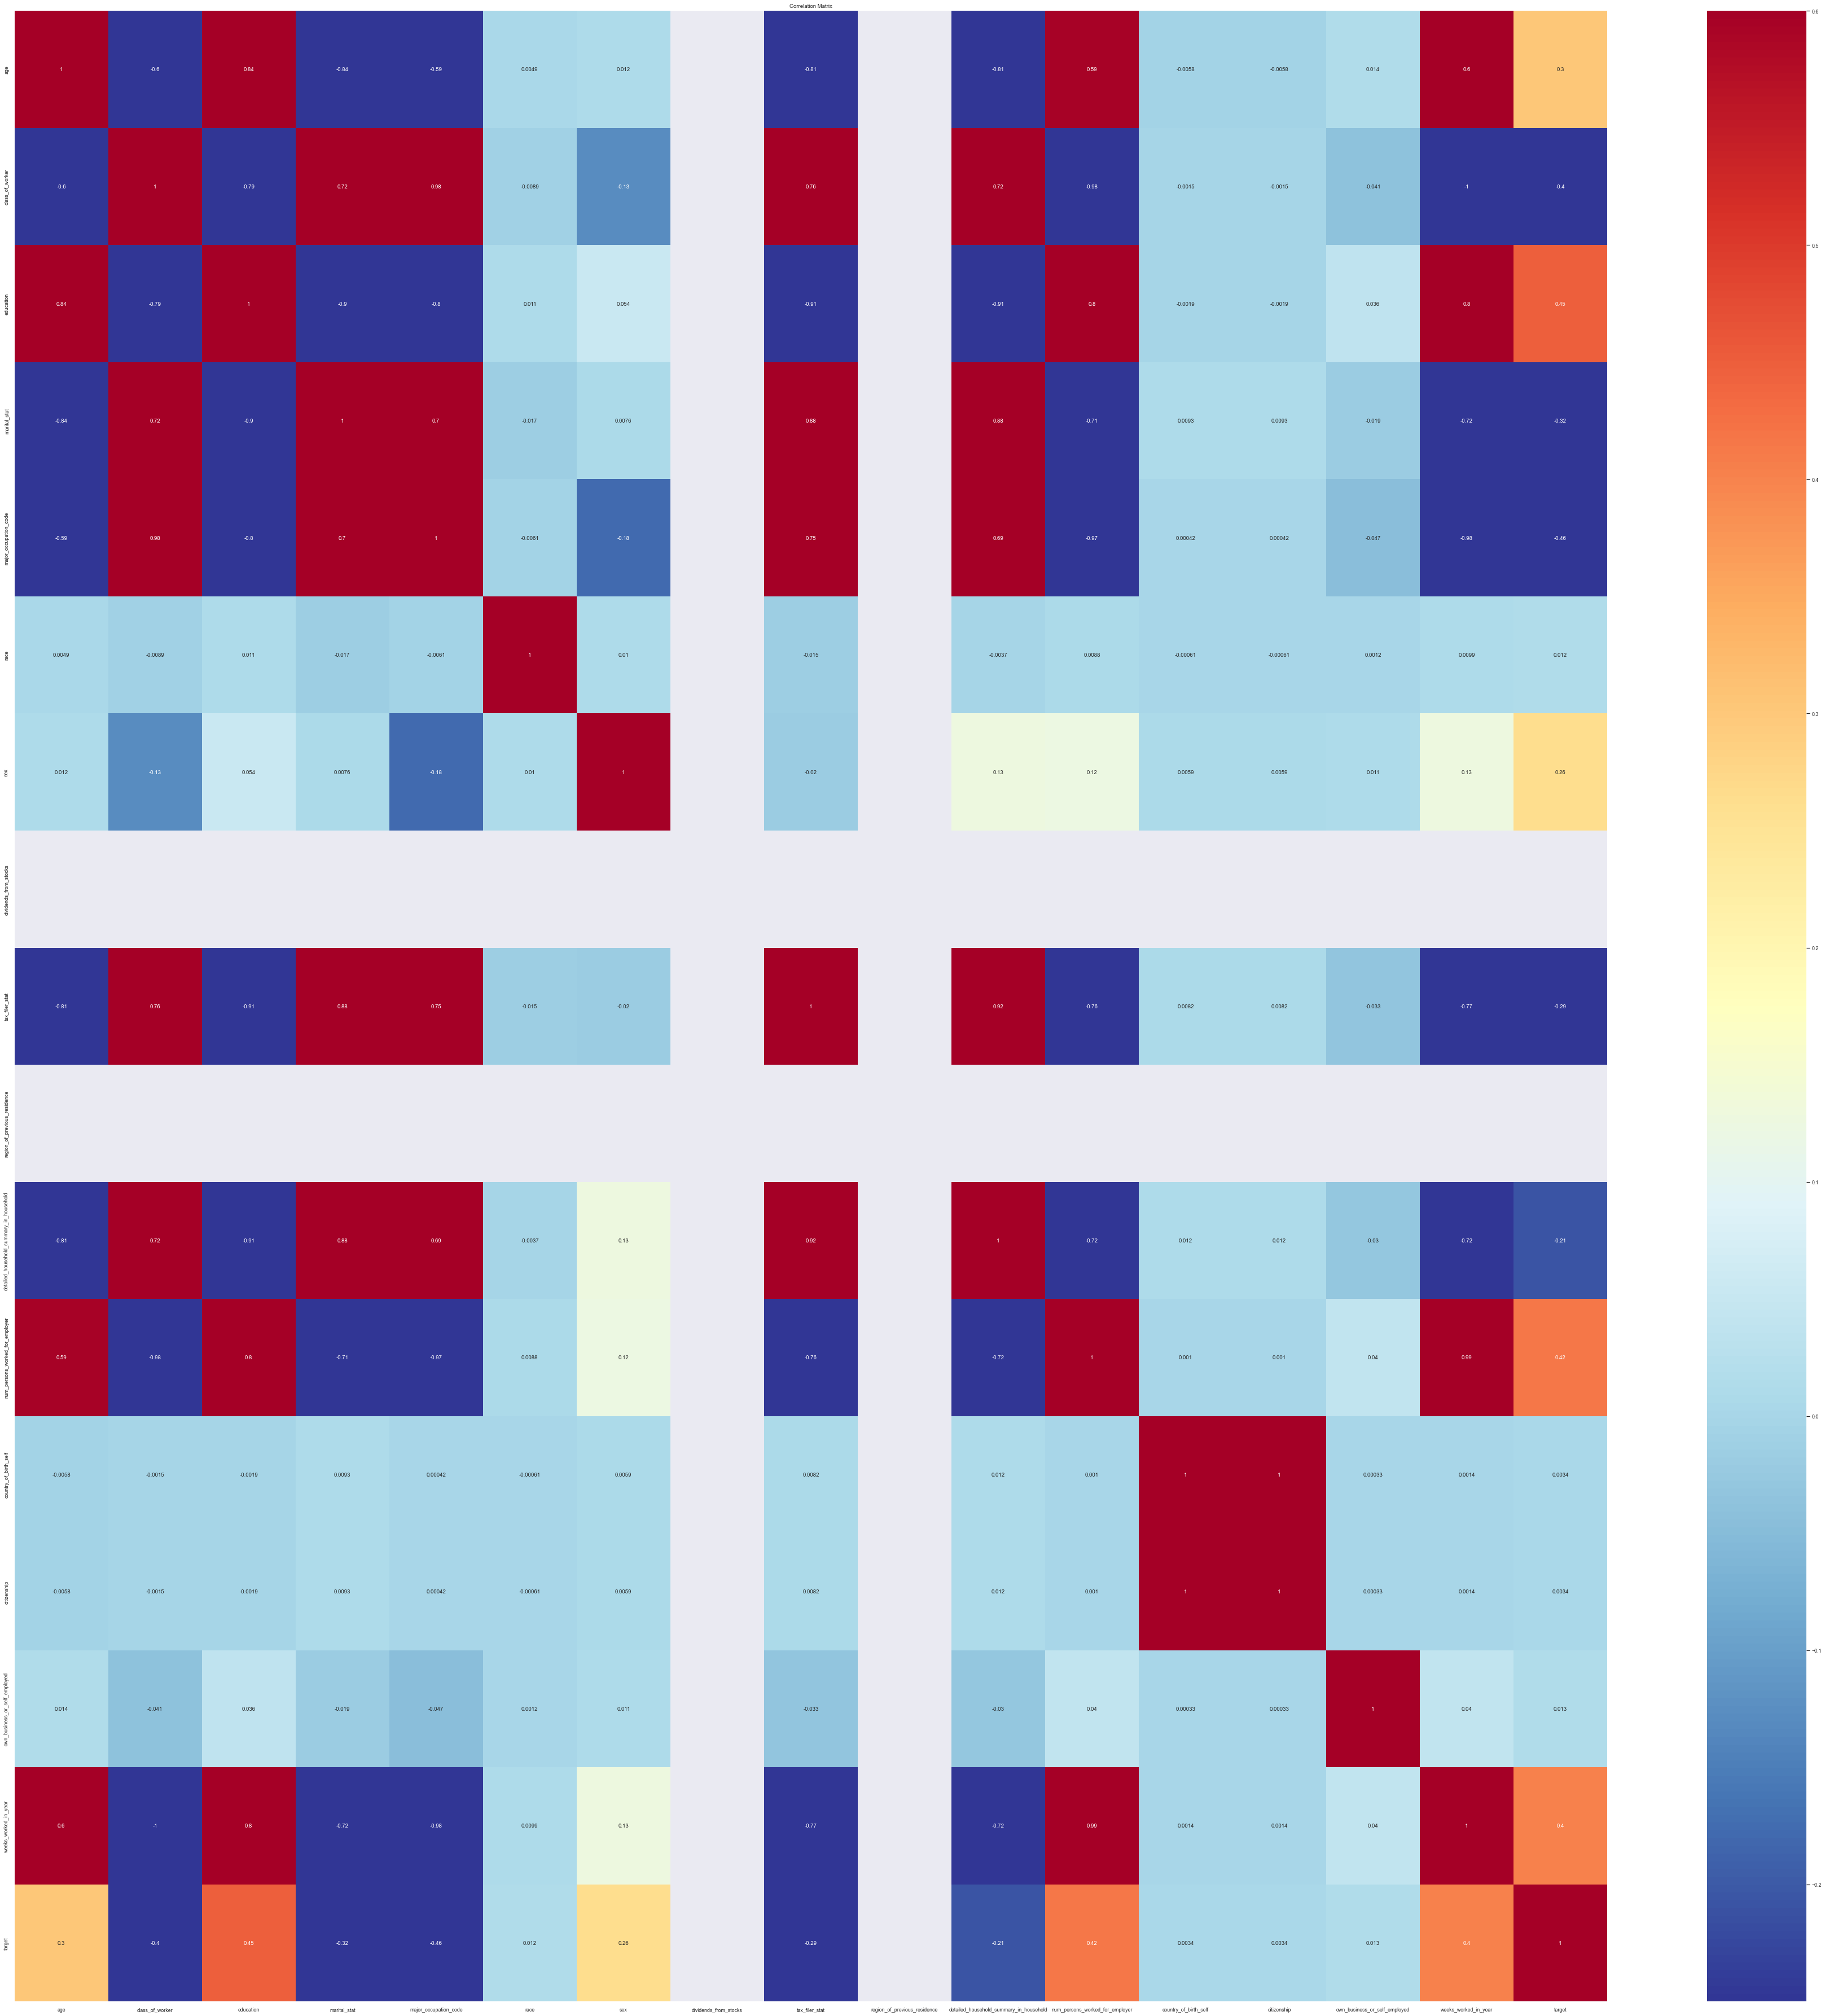

In [152]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [153]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 8
The number of features remaining: 8


In [154]:
del_features

array(['age', 'citizenship', 'class_of_worker',
       'detailed_household_summary_in_household', 'marital_stat',
       'num_persons_worked_for_employer', 'tax_filer_stat',
       'weeks_worked_in_year'], dtype='<U39')

In [155]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 8


In [156]:
sorted(count_features)

['country_of_birth_self',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [157]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [158]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [159]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       1
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [160]:
sorted(synt_data['country_of_birth_self'].unique()) 

['Mexico', 'United-States']

In [161]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [162]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, inpl

In [163]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 234 ms
Wall time: 219 ms


In [164]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.915 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.919 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.917 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.920 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.925 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.929 total time=   0.4s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.933 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.926 total time=   0.5s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.925 total time=   0.7s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.936 total time=   0.3s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.928 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.931 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.925 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.924 total time=   1.7s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.936 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.928 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.931 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.925 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.923 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.936 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.928 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.931 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.925 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.923 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.936 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.928 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.931 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.925 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.923 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.936 total time=   1.8s
CPU times: total: 42.2 s
Wall time: 43.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [165]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9297546040666264
LogisticRegression(C=0.001, solver='saga')


In [166]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [167]:
res_test21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test21, res_test_real21],axis=0)

In [168]:
res_test21

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Synth test           0.929752   

     Recall  Precision   ROC_AUC  
0  0.997423   0.333333  0.929752

In [169]:
res_test_real21

Model    Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Real test           0.788189   

     Recall  Precision   ROC_AUC  
0  0.804233   0.191798  0.788189

In [170]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 328 ms
Wall time: 310 ms


In [171]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.898 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.905 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.894 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.900 total time=   0.4s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.901 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.923 total time=   1.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.937 total time=   1.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.926 total time=   1.7s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.935 total time=   2.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.929 total time=   1.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.931 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.939 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.931 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.936 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.935 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.933 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.938 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.932 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.934 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.936 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.933 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.938 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.932 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.934 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.936 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.933 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.938 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.932 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.934 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.936 total time=   2.2s
CPU times: total: 57.5 s
Wall time: 58.8 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [172]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9347740907797177
LogisticRegression(C=1, solver='saga')


In [173]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [174]:
res_test22 = pd.DataFrame([['LogRegression GPT2xl real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real22 = pd.DataFrame([['LogRegression GPT2xl real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test22, res_test_real22],axis=0)

In [175]:
res_test22

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl real features  Synth test           0.932842   

     Recall  Precision   ROC_AUC  
0  0.984536   0.364156  0.932842

In [176]:
res_test_real22

Model    Dataset  Balanced_accuracy    Recall  \
0  LogRegression GPT2xl real features  Real test           0.808114  0.761905   

   Precision   ROC_AUC  
0   0.260163  0.808114

## Cerebras classification

### Data preprocessing 

In [177]:
synt_data = synt_data_cerebras.copy()

In [178]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [179]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [180]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [181]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [182]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' 'High school graduate' 'Bachelors degree(BA AB BS)'
 '10th grade' '9th grade' 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Some college but no degree' '11th grade'
 'Associates degree-occup /vocational' '7th and 8th grade'
 'Prof school degree (MD DDS DVM LLB JD)'
 'Associates degree-academic program' '5th or 6th grade'
 'Doctorate degree(PhD EdD)'] 14


In [183]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [184]:
to_encode_synt = to_encode.copy() 

In [185]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ class_of_worker
+ sex
+ region_of_previous_residence
+ own_business_or_self_employed


In [186]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ marital_stat
+ major_occupation_code
+ race
+ tax_filer_stat
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship


In [187]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [188]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [189]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000         0.620222   0.836186   
class_of_worker                          0.620222         1.000000   0.817988   
education                                0.836186         0.817988   1.000000   
marital_stat                            -0.840559        -0.747479  -0.902091   
major_occupation_code                   -0.612462        -0.976434  -0.818760   
race                                     0.023776         0.011415   0.020587   
sex                                     -0.016550         0.077595   0.022991   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.810419        -0.783344  -0.914000   
region_of_previous_residence                  NaN              NaN        NaN   
detailed_household_summary_in_household -0.805371        -0.753032  -0.908789   
num_persons_worked_for_employer          0.617332         0.989131   0.817274   
country_of_birth_self                   -0.013587         0.008552  -0.005907   
citizenship                             -0.013587         0.008552  -0.005907   
own_business_or_self_employed            0.016305         0.044717   0.044193   
weeks_worked_in_year                     0.623096         0.994849   0.819451   
target                                   0.306147         0.401902   0.452104   

                                         marital_stat  major_occupation_code  \
age                                         -0.840559              -0.612462   
class_of_worker                             -0.747479              -0.976434   
education                                   -0.902091              -0.818760   
marital_stat                                 1.000000               0.728670   
major_occupation_code                        0.728670               1.000000   
race                                        -0.024655              -0.013595   
sex                                          0.029985              -0.131607   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                               0.885819               0.770639   
region_of_previous_residence                      NaN                    NaN   
detailed_household_summary_in_household      0.890099               0.721715   
num_persons_worked_for_employer             -0.744722              -0.967795   
country_of_birth_self                        0.009534              -0.008400   
citizenship                                  0.009534              -0.008400   
own_business_or_self_employed               -0.015145              -0.052118   
weeks_worked_in_year                        -0.751185              -0.977013   
target                                      -0.325704              -0.453572   

                                             race       sex  \
age                                      0.023776 -0.016550   
class_of_worker                          0.011415  0.077595   
education                                0.020587  0.022991   
marital_stat                            -0.024655  0.029985   
major_occupation_code                   -0.013595 -0.131607   
race                                     1.000000  0.008942   
sex                                      0.008942  1.000000   
dividends_from_stocks                         NaN       NaN   
tax_filer_stat                          -0.015340  0.021036   
region_of_previous_residence                  NaN       NaN   
detailed_household_summary_in_household -0.020226  0.156261   
num_persons_worked_for_employer          0.010616  0.077945   
country_of_birth_self                   -0.000578  0.005811   
citizenship                             -0.000578  0.005811   
own_business_or_self_employed            0.001325  0.005729   
weeks_worked_in_year                     0.011585  0.079998   
target                                   0.011795  0.272063   

           

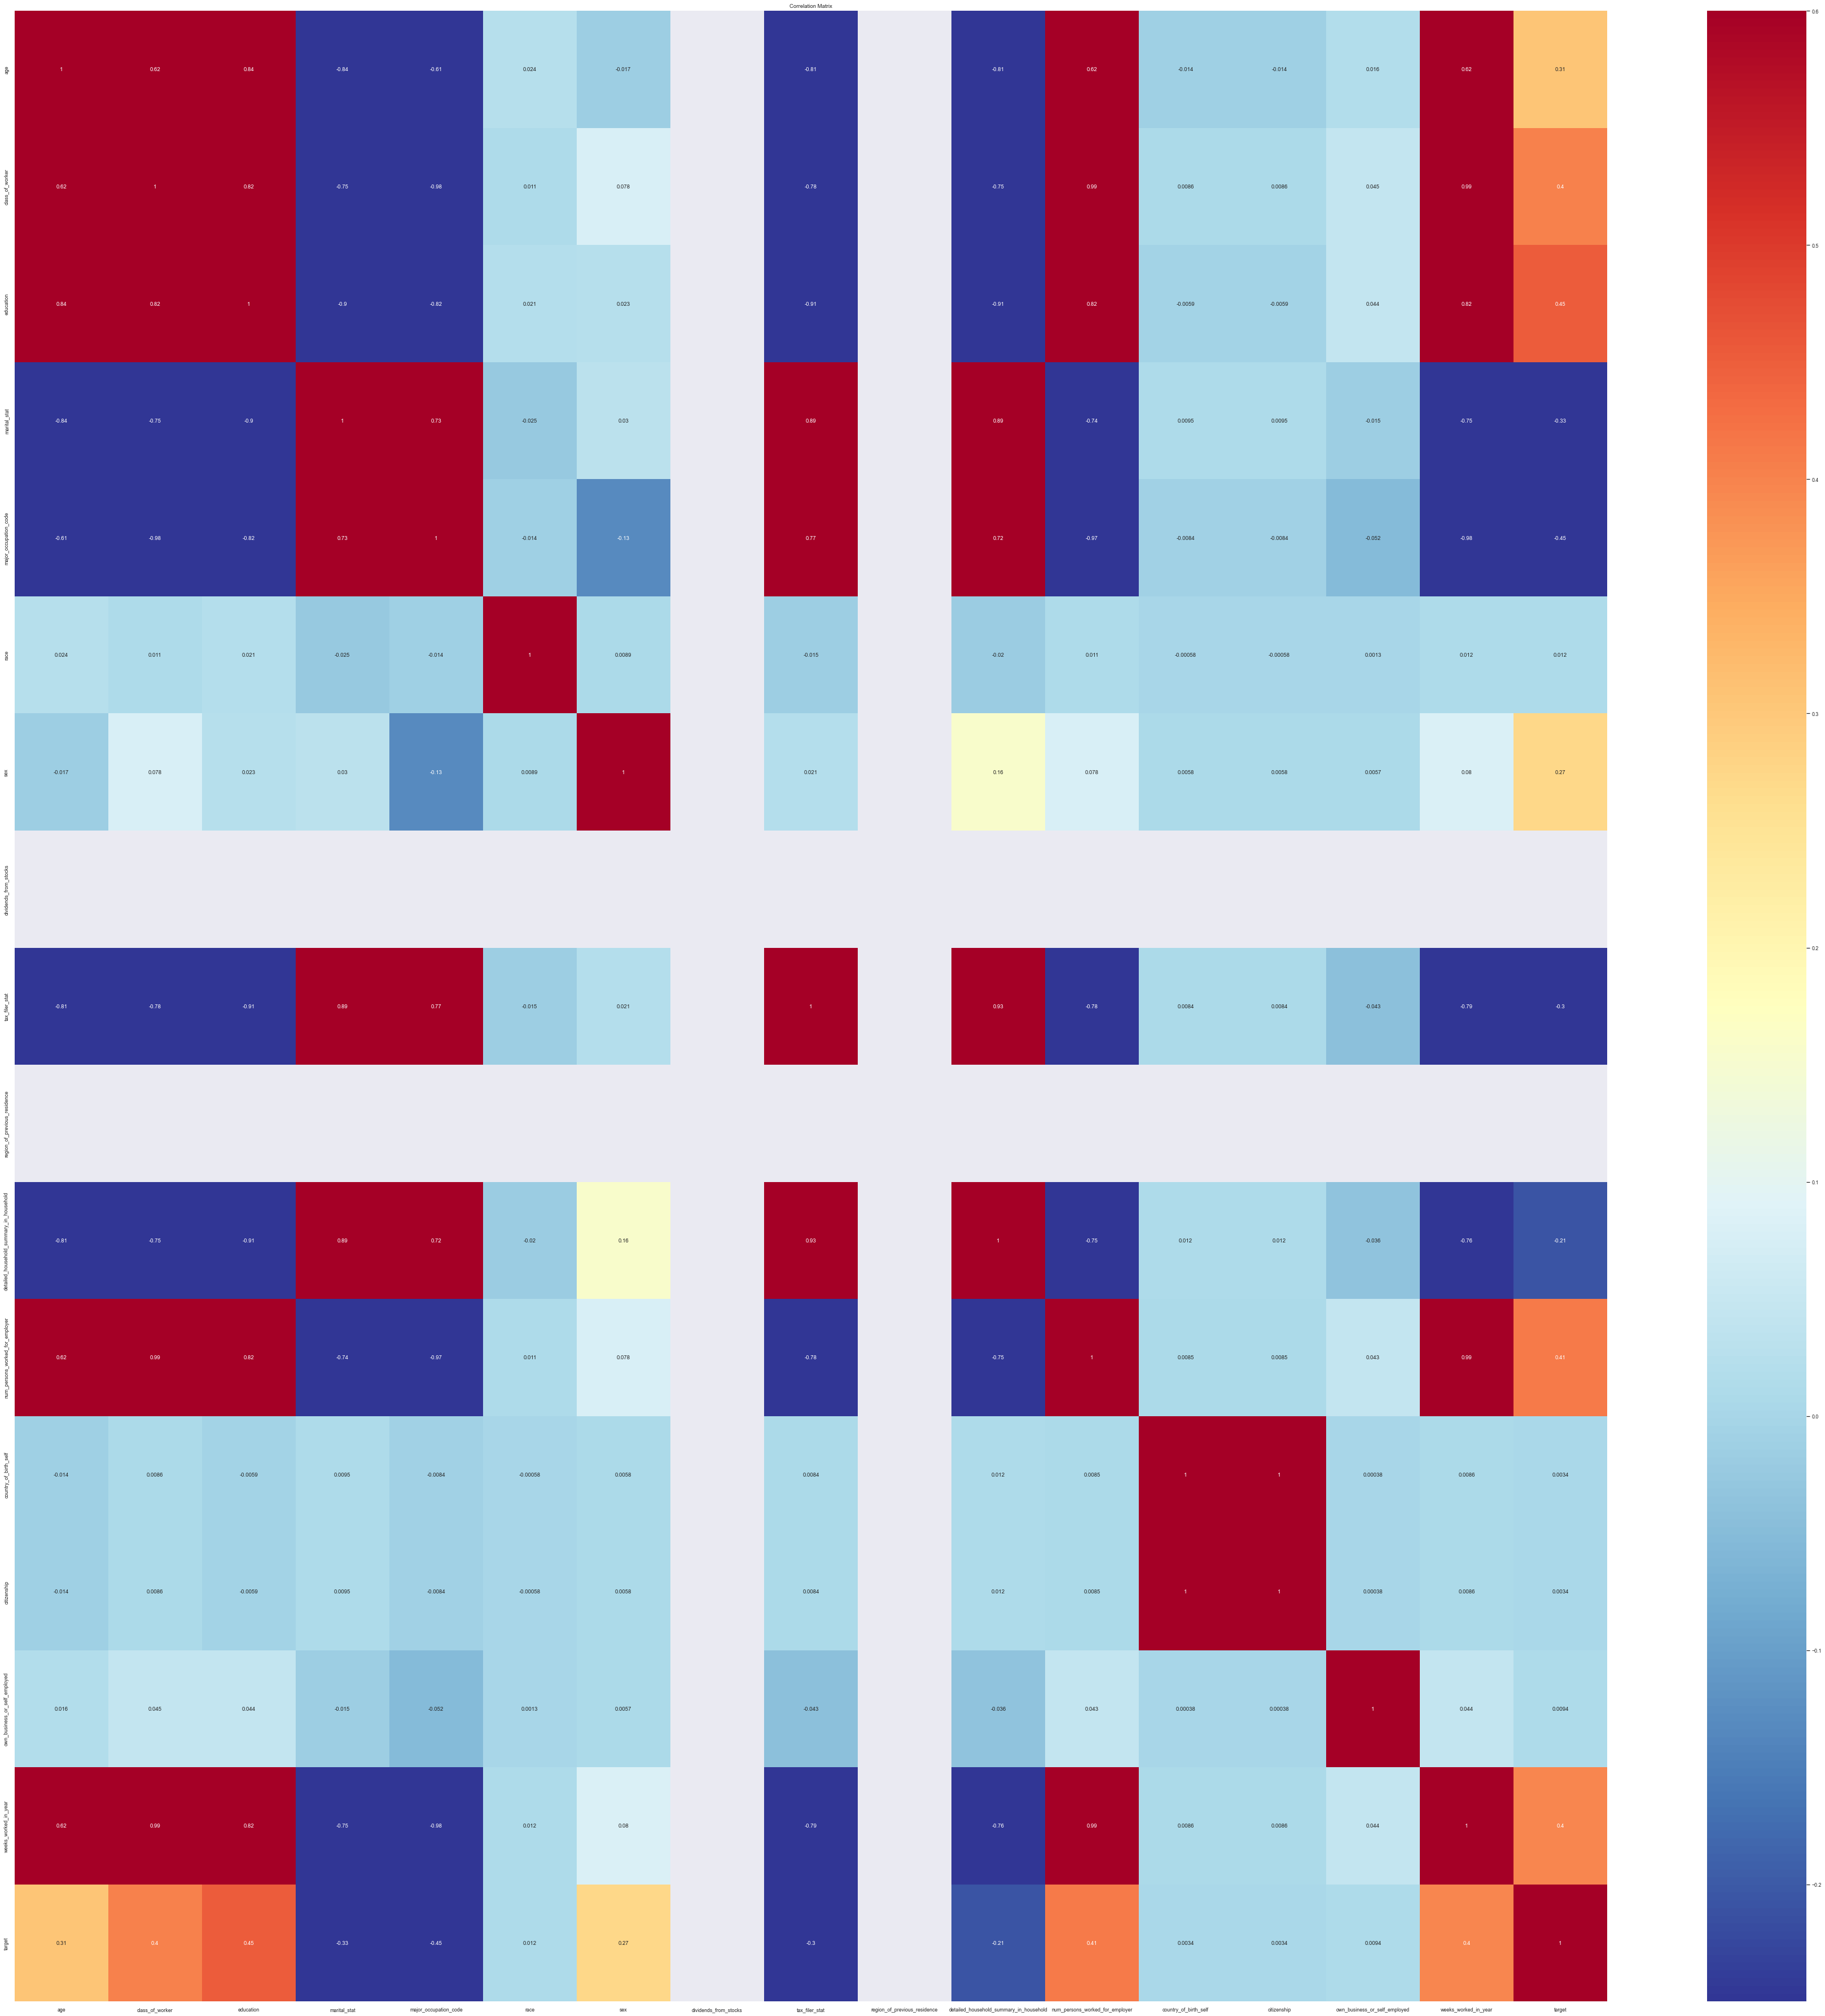

In [190]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [191]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 9
The number of features remaining: 7


In [192]:
del_features

array(['age', 'citizenship', 'class_of_worker',
       'detailed_household_summary_in_household', 'education',
       'marital_stat', 'num_persons_worked_for_employer',
       'tax_filer_stat', 'weeks_worked_in_year'], dtype='<U39')

In [193]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 7


In [194]:
sorted(count_features)

['country_of_birth_self',
 'dividends_from_stocks',
 'major_occupation_code',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [195]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [196]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [197]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                                66
race                                       348
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household      5
country_of_birth_self                      488
citizenship                                662
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [198]:
sorted(synt_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S', 'Native- Born in the United States']

In [199]:
sorted(real_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [200]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, inpl

In [201]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 469 ms
Wall time: 468 ms


In [202]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.943 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.919 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.932 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.934 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.932 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.943 total time=   0.3s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.915 total time=   0.5s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.933 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.935 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.932 total time=   0.4s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.943 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.915 total time=   1.6s
[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.933 total time=   0.9s
[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.934 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.932 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.943 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.915 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.933 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.934 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.932 total time=   1.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.943 total time=   1.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.915 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.933 total time=   1.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.934 total time=   1.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.932 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.943 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.915 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.933 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.934 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.932 total time=   1.5s
CPU times: total: 34.4 s
Wall time: 35 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [203]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.932334475721374
LogisticRegression(C=0.0001, solver='saga')


In [204]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [205]:
res_test31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test31, res_test_real31],axis=0)

In [206]:
res_test31

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Synth test            0.93347   

     Recall  Precision  ROC_AUC  
0  0.976923   0.381764  0.93347

In [207]:
res_test_real31

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Real test           0.732823   

     Recall  Precision   ROC_AUC  
0  0.690476   0.171148  0.732823

In [208]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 344 ms
Wall time: 346 ms


In [209]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.912 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.922 total time=   0.5s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.917 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.913 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.914 total time=   0.5s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.934 total time=   1.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.928 total time=   1.7s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.937 total time=   0.9s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.934 total time=   0.9s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.936 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.945 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.936 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.947 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.938 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.948 total time=   2.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.945 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.936 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.947 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.937 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.948 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.946 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.936 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.947 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.937 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.948 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.946 total time=   1.8s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.936 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.947 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.937 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.948 total time=   1.8s
CPU times: total: 55.3 s
Wall time: 57.1 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [210]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9426876660182477
LogisticRegression(C=0.01, solver='saga')


In [211]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [212]:
res_test32 = pd.DataFrame([['LogRegression Cerebras real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real32 = pd.DataFrame([['LogRegression Cerebras real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test32, res_test_real32],axis=0)

In [213]:
res_test32

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Synth test           0.936055   

     Recall  Precision   ROC_AUC  
0  0.976923   0.393189  0.936055

In [214]:
res_test_real32

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Real test           0.776746   

     Recall  Precision   ROC_AUC  
0  0.693122   0.250239  0.776746

## Phi1.5 classification

### Data preprocessing 

In [215]:
synt_data = synt_data_phi.copy()

In [216]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [217]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [218]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [219]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [220]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' 'High school graduate' 'Bachelors degree(BA AB BS)'
 'Some college but no degree' '11th grade' '9th grade' '7th and 8th grade'
 'Associates degree-occup /vocational'
 'Masters degree(MA MS MEng MEd MSW MBA)' '5th or 6th grade' '10th grade'
 'Associates degree-academic program' 'Doctorate degree(PhD EdD)'
 'Prof school degree (MD DDS DVM LLB JD)' '12th grade no diploma'
 '1st 2nd 3rd or 4th grade'] 16


In [221]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [222]:
to_encode_synt = to_encode.copy() 

In [223]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ sex
+ region_of_previous_residence


In [224]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ race
+ tax_filer_stat
+ detailed_household_summary_in_household
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [225]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [226]:
#X_tr.fillna(0,inplace=True)

In [227]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [228]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.616517   0.834912   
class_of_worker                         -0.616517         1.000000  -0.810133   
education                                0.834912        -0.810133   1.000000   
marital_stat                            -0.844323         0.737430  -0.893166   
major_occupation_code                   -0.607090         0.976584  -0.812444   
race                                     0.015851        -0.015751   0.015116   
sex                                      0.021932        -0.105923   0.046659   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.808672         0.785109  -0.911958   
region_of_previous_residence                  NaN              NaN        NaN   
detailed_household_summary_in_household -0.805359         0.752605  -0.909498   
num_persons_worked_for_employer          0.611492        -0.980565   0.811035   
country_of_birth_self                   -0.010616         0.003958  -0.008035   
citizenship                             -0.010616         0.003959  -0.008035   
own_business_or_self_employed           -0.012951         0.041605  -0.035756   
weeks_worked_in_year                     0.617294        -0.995174   0.813617   
target                                   0.302981        -0.373897   0.435155   

                                         marital_stat  major_occupation_code  \
age                                         -0.844323              -0.607090   
class_of_worker                              0.737430               0.976584   
education                                   -0.893166              -0.812444   
marital_stat                                 1.000000               0.718728   
major_occupation_code                        0.718728               1.000000   
race                                        -0.018284              -0.016119   
sex                                         -0.009241              -0.155247   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                               0.874613               0.771535   
region_of_previous_residence                      NaN                    NaN   
detailed_household_summary_in_household      0.882696               0.721459   
num_persons_worked_for_employer             -0.731275              -0.966052   
country_of_birth_self                        0.015910               0.007005   
citizenship                                  0.015910               0.007006   
own_business_or_self_employed                0.000372               0.045311   
weeks_worked_in_year                        -0.739225              -0.976276   
target                                      -0.317999              -0.433020   

                                             race       sex  \
age                                      0.015851  0.021932   
class_of_worker                         -0.015751 -0.105923   
education                                0.015116  0.046659   
marital_stat                            -0.018284 -0.009241   
major_occupation_code                   -0.016119 -0.155247   
race                                     1.000000  0.009071   
sex                                      0.009071  1.000000   
dividends_from_stocks                         NaN       NaN   
tax_filer_stat                          -0.020970 -0.017574   
region_of_previous_residence                  NaN       NaN   
detailed_household_summary_in_household -0.012350  0.124884   
num_persons_worked_for_employer          0.015089  0.098441   
country_of_birth_self                    0.050327  0.011405   
citizenship                              0.050325  0.011404   
own_business_or_self_employed           -0.001384 -0.001368   
weeks_worked_in_year                     0.015592  0.103212   
target                                   0.012628  0.258657   

           

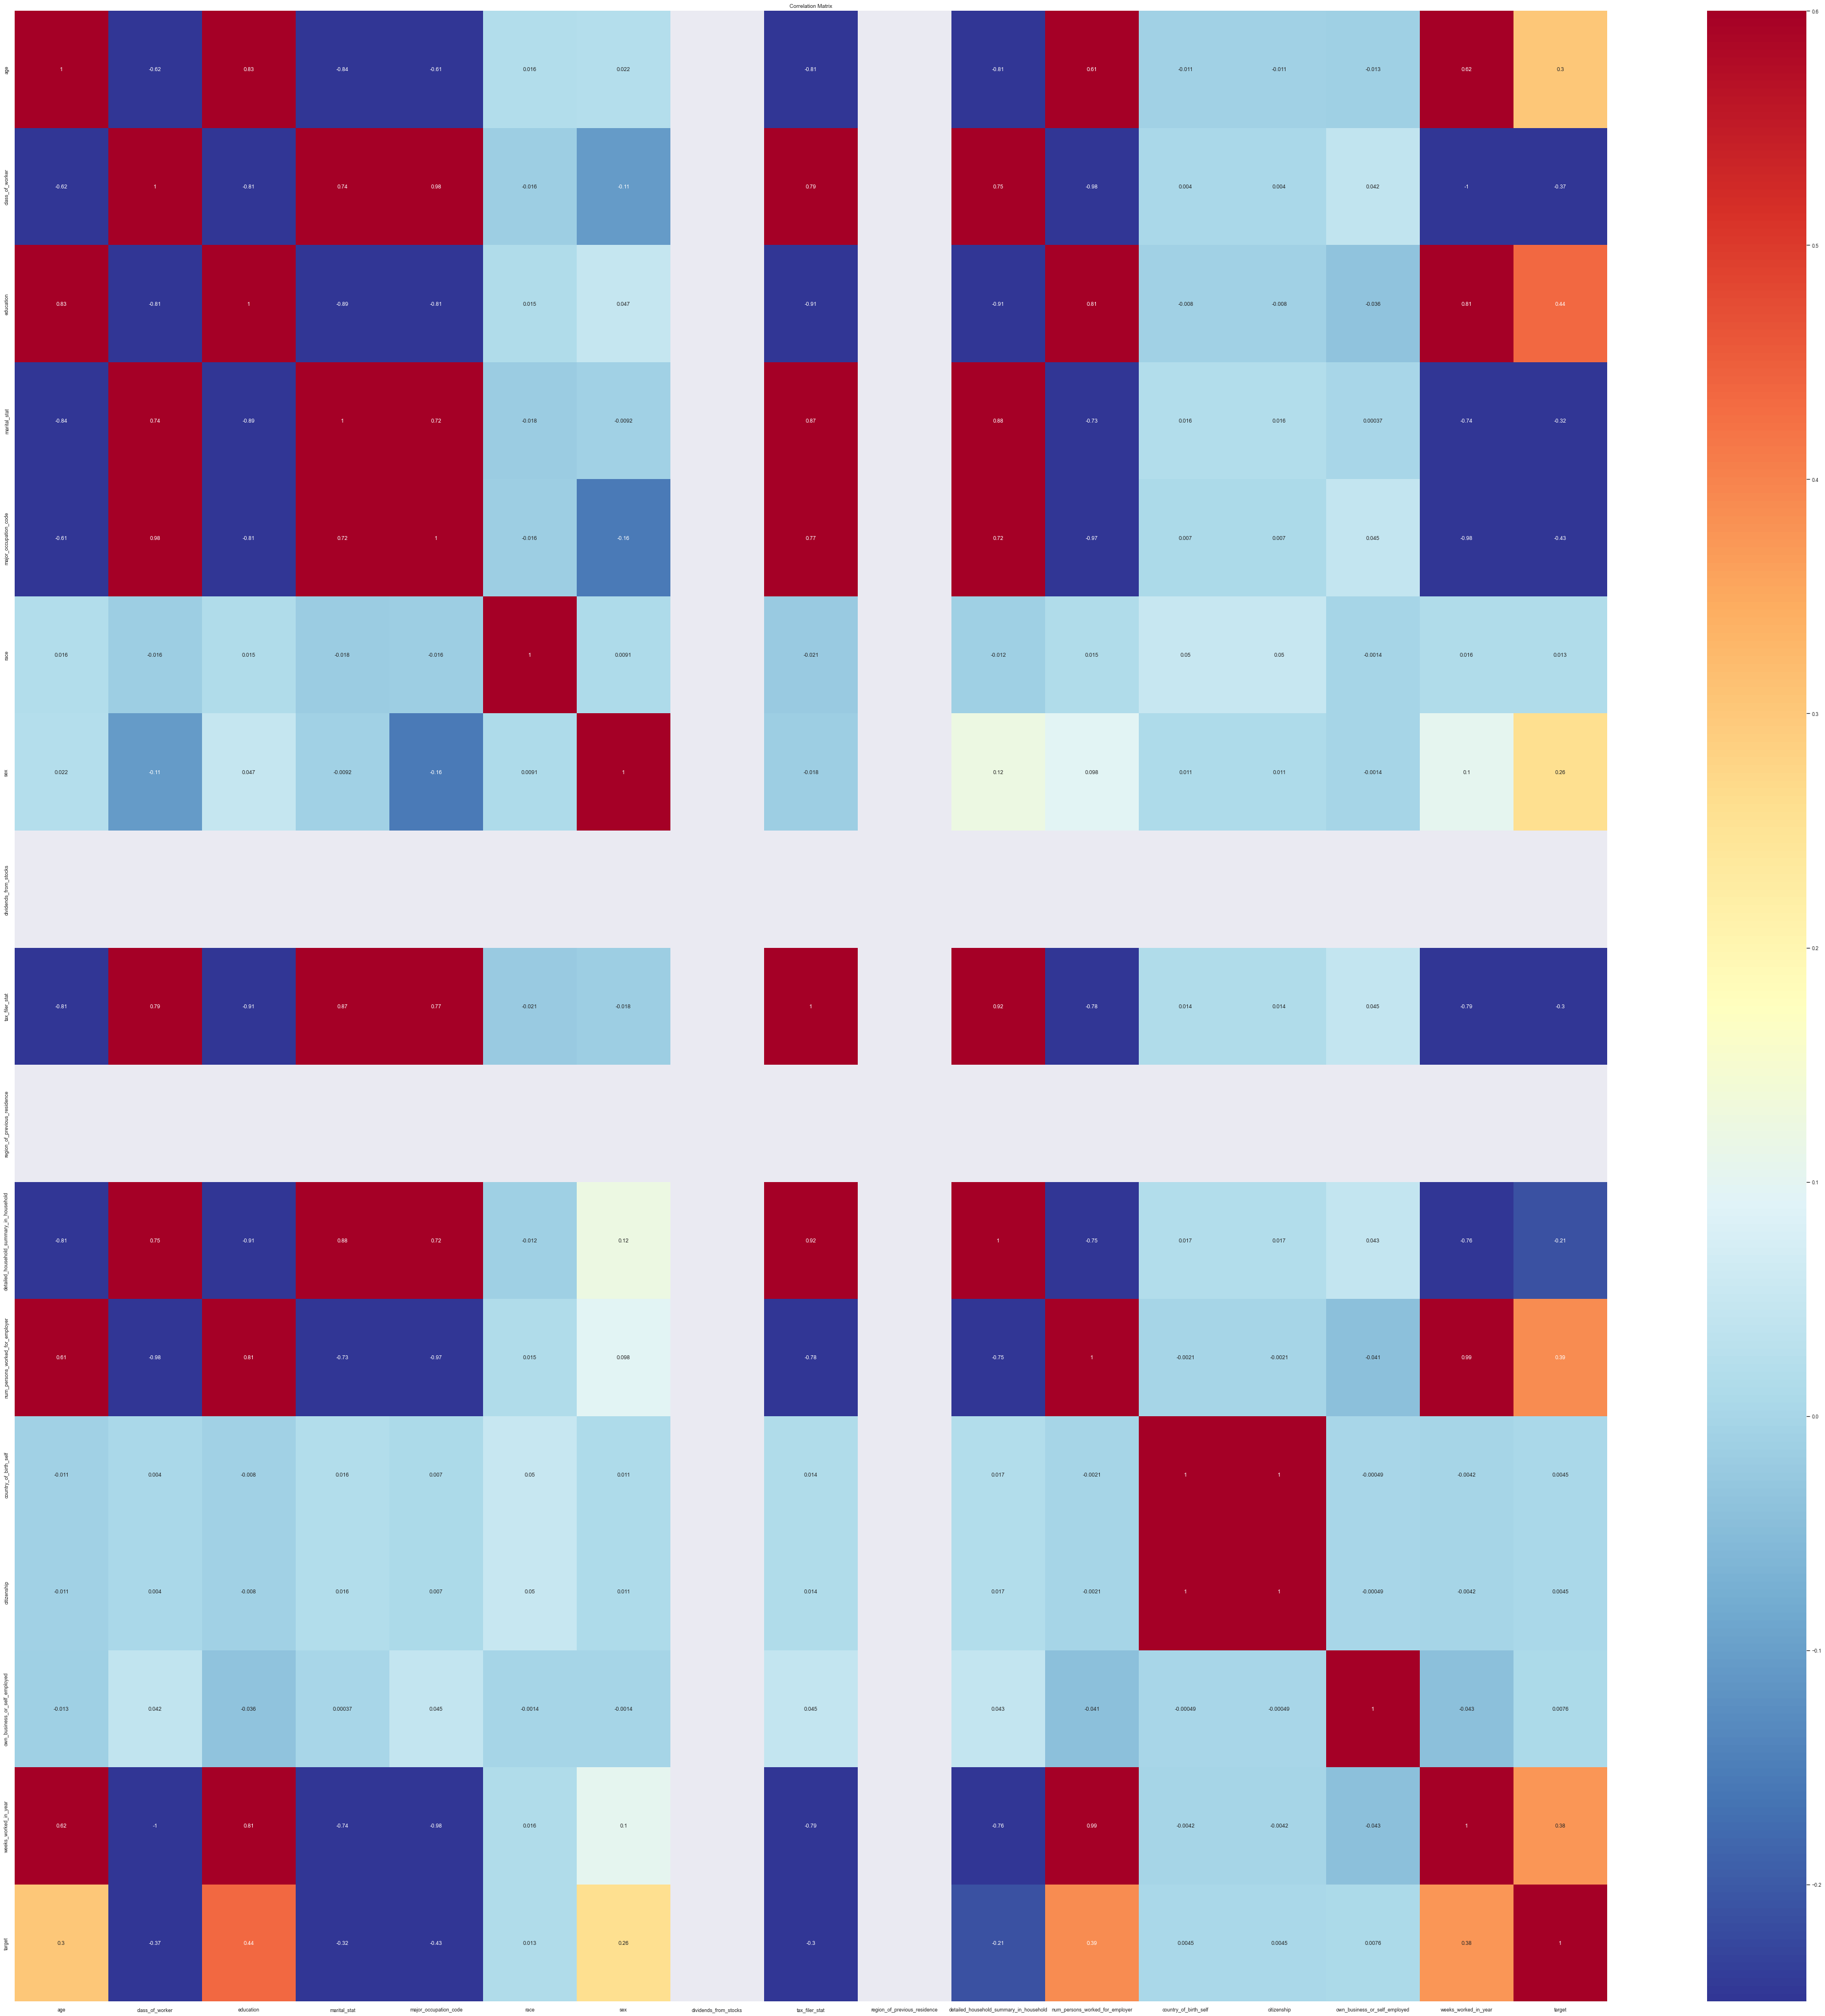

In [229]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [230]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 9
The number of features remaining: 7


In [231]:
del_features

array(['age', 'citizenship', 'class_of_worker',
       'detailed_household_summary_in_household', 'major_occupation_code',
       'marital_stat', 'num_persons_worked_for_employer',
       'tax_filer_stat', 'weeks_worked_in_year'], dtype='<U39')

In [232]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 7


In [233]:
sorted(count_features)

['country_of_birth_self',
 'dividends_from_stocks',
 'education',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [234]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [235]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [236]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [237]:
sorted(synt_data['country_of_birth_self'].unique()) 

['Mexico', 'United-States']

In [238]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [239]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0, inpl

In [240]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 250 ms
Wall time: 248 ms


In [241]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.905 total time=   0.1s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.901 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.906 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.893 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.909 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.908 total time=   0.1s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.903 total time=   0.1s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.909 total time=   0.1s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.896 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.912 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.910 total time=   0.5s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.897 total time=   1.4s
[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.913 total time=   0.5s
[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.910 total time=   1.2s
[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.904 total time=   1.0s
[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.911 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.898 total time=   1.3s
[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.913 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.910 total time=   1.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.904 total time=   1.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.911 total time=   1.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.898 total time=   1.4s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.913 total time=   1.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.910 total time=   1.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.904 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.911 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.898 total time=   1.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.913 total time=   1.6s
CPU times: total: 28.3 s
Wall time: 29.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [242]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9073348993891805
LogisticRegression(C=0.1, solver='saga')


In [243]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [244]:
res_test41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test41, res_test_real41],axis=0)

In [245]:
res_test41

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Synth test           0.913499   

     Recall  Precision   ROC_AUC  
0  0.989744   0.297152  0.913499

In [246]:
res_test_real41

Model    Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Real test           0.730512   

     Recall  Precision   ROC_AUC  
0  0.669312   0.177669  0.730512

In [247]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 344 ms
Wall time: 354 ms


In [248]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.869 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.872 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.871 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.864 total time=   0.4s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.870 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.909 total time=   0.7s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.903 total time=   0.8s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.915 total time=   0.8s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.886 total time=   1.9s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.908 total time=   0.7s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.911 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .......LR__C=0.01, LR__solver=saga;, score=0.912 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .......LR__C=0.01, LR__solver=saga;, score=0.918 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .......LR__C=0.01, LR__solver=saga;, score=0.891 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .......LR__C=0.01, LR__solver=saga;, score=0.912 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ........LR__C=0.1, LR__solver=saga;, score=0.911 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ........LR__C=0.1, LR__solver=saga;, score=0.912 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ........LR__C=0.1, LR__solver=saga;, score=0.919 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ........LR__C=0.1, LR__solver=saga;, score=0.895 total time=   1.9s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ........LR__C=0.1, LR__solver=saga;, score=0.912 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.911 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.912 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.919 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.895 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.912 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.911 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.912 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.919 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.895 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.912 total time=   2.0s
CPU times: total: 52.1 s
Wall time: 54.7 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [249]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9098416890877822
LogisticRegression(C=1, solver='saga')


In [250]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [251]:
res_test42 = pd.DataFrame([['LogRegression Phi1.5 real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real42 = pd.DataFrame([['LogRegression Phi1.5 real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test42, res_test_real42],axis=0)

In [252]:
res_test42

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 real features  Synth test           0.917832   

     Recall  Precision   ROC_AUC  
0  0.987179   0.311741  0.917832

In [253]:
res_test_real42

Model    Dataset  Balanced_accuracy    Recall  \
0  LogRegression Phi1.5 real features  Real test           0.739306  0.650794   

   Precision   ROC_AUC  
0   0.202636  0.739306

## Modelling result

In [254]:
model_results

Model     Dataset  Balanced_accuracy  \
0                      LogRegression Real data   Real test           0.845280   
0  LogRegression DistillGPT synthetic features  Synth test           0.746531   
0  LogRegression DistillGPT synthetic features   Real test           0.737641   
0       LogRegression DistillGPT real features  Synth test           0.724572   
0       LogRegression DistillGPT real features   Real test           0.742647   
0      LogRegression GPT2xl synthetic features  Synth test           0.929752   
0      LogRegression GPT2xl synthetic features   Real test           0.788189   
0           LogRegression GPT2xl real features  Synth test           0.932842   
0           LogRegression GPT2xl real features   Real test           0.808114   
0    LogRegression Cerebras synthetic features  Synth test           0.933470   
0    LogRegression Cerebras synthetic features   Real test           0.732823   
0         LogRegression Cerebras real features  Synth test           0.936055   
0         LogRegression Cerebras real features   Real test           0.776746   
0      LogRegression Phi1.5 synthetic features  Synth test           0.913499   
0      LogRegression Phi1.5 synthetic features   Real test           0.730512   
0           LogRegression Phi1.5 real features  Synth test           0.917832   
0           LogRegression Phi1.5 real features   Real test           0.739306   

     Recall  Precision   ROC_AUC  
0  0.888889   0.231564  0.845280  
0  0.820513   0.148354  0.746531  
0  0.791005   0.144166  0.737641  
0  0.817949   0.133585  0.724572  
0  0.743386   0.162240  0.742647  
0  0.997423   0.333333  0.929752  
0  0.804233   0.191798  0.788189  
0  0.984536   0.364156  0.932842  
0  0.761905   0.260163  0.808114  
0  0.976923   0.381764  0.933470  
0  0.690476   0.171148  0.732823  
0  0.976923   0.393189  0.936055  
0  0.693122   0.250239  0.776746  
0  0.989744   0.297152  0.913499  
0  0.669312   0.177669  0.730512  
0  0.987179   0.311741  0.917832  
0  0.650794   0.202636  0.739306

In [255]:
model_results.to_csv('model_results_shortincome_temp0.3.csv')

# Privacy metrics

In [256]:
from pandas import DataFrame, Series
from typing import List, Tuple, Dict, Callable
import scipy.stats as ss
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mannwhitneyu, chisquare, ks_2samp



In [257]:
privacy_results = pd.DataFrame(columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median'])

In [258]:
# bound value to determine quantiles
dcr_quantile = 0.95
# how many bins should be created for privacy histograms
privacy_number_of_bins = 30
#to avoid devision by zero
smoothing_factor = 1e-8
#test sample ratio
ratio = 0.3
control_size = 9000

random_state = 12*13*99*17-1

In [259]:
tgt_train = real_dataset.copy()

In [260]:
tgt_test = control_dataset.copy()

In [261]:
def create_hamming (df, columns) :
    hamming = dict()
    for i,col in enumerate(columns) :
        hamming[col] = create_hamming_dic(df, col)
    return hamming

def create_hamming_dic (df, column):
    hamming_dic = dict()
    keys = sorted(df[column].unique())
    for i, key in enumerate(keys):
        code = i+1
        hamming_dic[key] = code
    return hamming_dic    

def map_column_humming(df, column, hamming) :
    df[column] = df[column].map(hamming[column])  
    return df[column]

def map_humming (df, hamming) :
    keys = hamming.keys()
    for col in df.columns :
        if col in keys:
            df[col] = map_column_humming(df, col, hamming)
    df.fillna(0) 
    return df
def normal_coeff (df, columns) :
    coeff = list()
    for col in columns :
        coeff.append(df[col].max())
    return coeff

In [262]:
for_hmm_columns = categs.copy()
for_hmm_columns.append('target')
for_norm_columns = numeric.copy()
hmm_train = tgt_train.copy()
hmm_train = hmm_train[for_norm_columns+for_hmm_columns]
hmm_test = tgt_test.copy()
hmm_test = hmm_test[for_norm_columns+for_hmm_columns]

In [263]:
hmm = create_hamming(hmm_train, for_hmm_columns)

In [264]:
hmm_train = map_humming(hmm_train,hmm)

In [265]:
norm_weights = normal_coeff(hmm_train, for_norm_columns)  

In [266]:
norm_weights

[90, 99999, 6, 52]

In [267]:
def get_mixed_distance (x,y, norm_weights) :
    distance = 0
    for i in range(len(norm_weights)) :  #first numeric fields  
        distance += abs(x[i]-y[i])/norm_weights[i]
    for i in range(len(norm_weights), len(x)) :  # next categorical fields
        if x[i] != y[i] :
            distance += 1
    return distance        

In [268]:
def get_2_neighbors_for_vector (vector, base, norm_weights) :
    k1 = -1 
    k2 = -1
    d1 = -1
    d2 = -1
    for i, basis in enumerate(base) :
        curr_distance = get_mixed_distance (vector, basis, norm_weights)
        if k1 < 0 :
            k1 = i
            d1 = curr_distance
        elif k2 < 0 :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            else :
                k2 = i
                d2 = curr_distance
        else :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            elif curr_distance < d2 :
                k2 = i
                d2 = curr_distance
    return np.array([[k1,k2],[d1,d2]])

In [269]:
def get_2_neighbors_mixed (vectors, base, norm_weights, trace = 0) :
    neighbors = list()
    if trace > 0 :
        print(len(vectors),':', end='')
    for i, vector in enumerate(vectors):
        neighbors.append(get_2_neighbors_for_vector (vector, base, norm_weights)) 
        if trace > 0 and i%trace == 0 :
            print(i, '-' , end='')
    print (len(vectors))
    return np.array(neighbors)

## Real data privacy

In [270]:
hmm_test = map_humming(hmm_test,hmm)

In [271]:
nbs = get_2_neighbors_mixed(vectors=hmm_test.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [272]:
print('Stats : mean, std, max, min, amount')
dcr_real = np.array([d[0] for d in [x[1] for x in [i for i in nbs]]])
dcr2_real = np.array([d[1] for d in [x[1] for x in [i for i in nbs]]])
nndr_real = dcr_real / np.maximum(dcr2_real, smoothing_factor) 
print('NNDR stats', nndr_real.mean(), nndr_real.std(), nndr_real.max(), nndr_real.min(), len (nndr_real))
baseline_dcr = dcr_real
bound = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
dcr_real_norm = np.where(dcr_real <= bound, dcr_real / bound, 1)
print('nDCR stats', dcr_real_norm.mean(), dcr_real_norm.std(), dcr_real_norm.max(), dcr_real_norm.min(), len(dcr_real_norm))
print('DCR Bound',dcr_quantile,'% =',bound)

Stats : mean, std, max, min, amount
NNDR stats 0.48010248609410033 0.4123699359575158 1.0 0.0 9000
nDCR stats 0.22862066371959058 0.31746840509738666 1.0 0.0 9000
DCR Bound 0.95 % = 2.1444444444444444


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for RealData'}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for RealData'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for RealData'}>]],
      dtype=object)

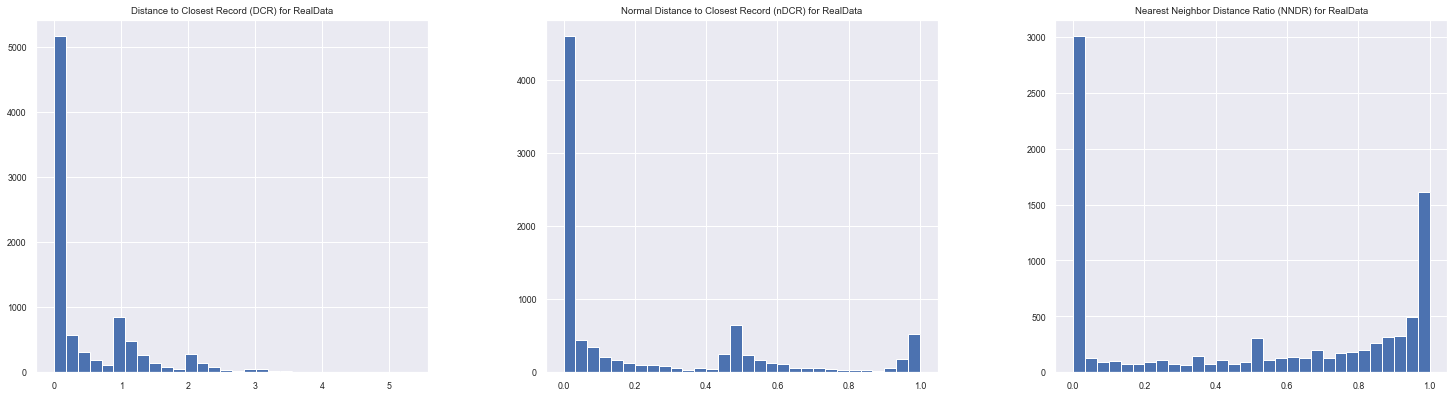

In [273]:
real_privacy = pd.DataFrame(zip(dcr_real,dcr_real_norm,nndr_real),columns=['Distance to Closest Record (DCR) for RealData','Normal Distance to Closest Record (nDCR) for RealData','Nearest Neighbor Distance Ratio (NNDR) for RealData'])
real_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

In [274]:
def calc_dcr_ratio(real_dcr:np.array, synt_dcr:np.array):
    med_real = np.median(real_dcr) 
    ordered_synt = np.sort(synt_dcr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [275]:
def calc_nndr_ratio(real_nndr:np.array, synt_nndr:np.array):
    med_real = np.median(real_nndr) 
    ordered_synt = np.sort(synt_nndr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [276]:
calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy())

1.0

In [277]:
calc_nndr_ratio(nndr_real,nndr_real.copy())

1.0

In [278]:
res_privacy = pd.DataFrame([['Real dataset', bound,
                        calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy()),
                        calc_nndr_ratio(nndr_real,nndr_real.copy()),
                        np.median(dcr_real_norm),
                        np.median(nndr_real),
                        dcr_real_norm.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_804\106412619.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  privacy_results = pd.concat([privacy_results, res_privacy],axis=0)


## DistillGPT2 privacy

In [279]:
syn_test1 = synt_data_distilgpt2.sample(n=control_size) 

In [280]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [281]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [282]:
nbs1 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy()[:10000],base=hmm_train.to_numpy()[:10000],norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [283]:
print('Stats : mean, std, max, min, amount')
dcr_synt1 = np.array([d[0] for d in [x[1] for x in [i for i in nbs1]]])
dcr2_synt1 = np.array([d[1] for d in [x[1] for x in [i for i in nbs1]]])
nndr_synt1 = dcr_synt1 / np.maximum(dcr2_synt1, smoothing_factor) 
print('NNDR stats', nndr_synt1.mean(), nndr_synt1.std(), nndr_synt1.max(), nndr_synt1.min(), len (nndr_synt1))
dcr_synt_norm1 = np.where(dcr_synt1 <= bound, dcr_synt1 / bound, 1)
print('nDCR stats', dcr_synt_norm1.mean(), dcr_synt_norm1.std(), dcr_synt_norm1.max(), dcr_synt_norm1.min(), len(dcr_synt_norm1))

baseline_dcr = dcr_synt1
bound1 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound1)

Stats : mean, std, max, min, amount
NNDR stats 0.2606202306968908 0.369688525779644 1.0 0.0 9000
nDCR stats 0.03926422005551263 0.11453379845732778 1.0 0.0 9000
DCR Bound 0.95 % = 0.8957264957264957


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for DistillGPT synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for DistillGPT synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'}>]],
      dtype=object)

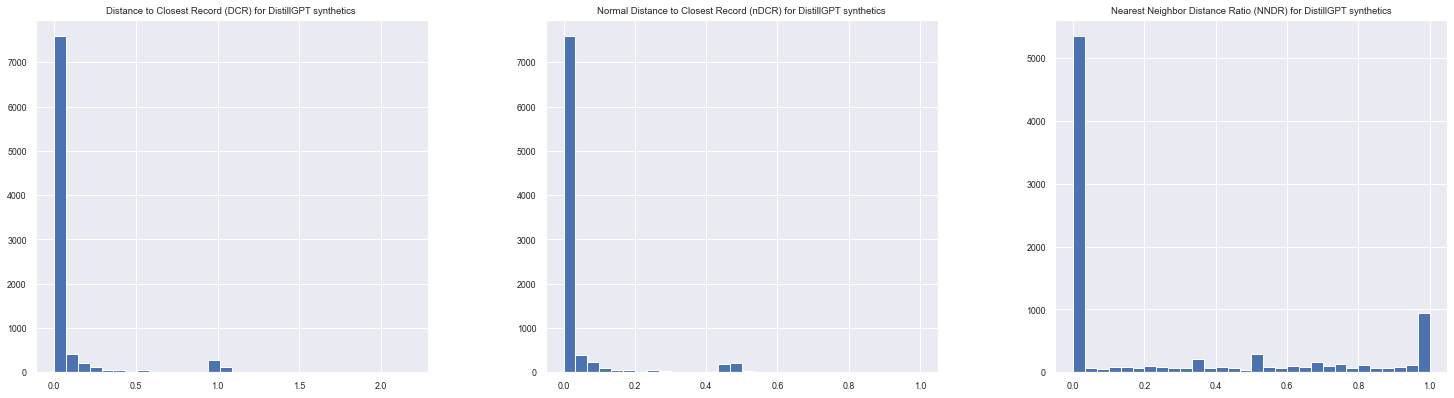

In [284]:
synt_privacy = pd.DataFrame(zip(dcr_synt1,dcr_synt_norm1,nndr_synt1),columns=['Distance to Closest Record (DCR) for DistillGPT synthetics ','Normal Distance to Closest Record (nDCR) for DistillGPT synthetics','Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

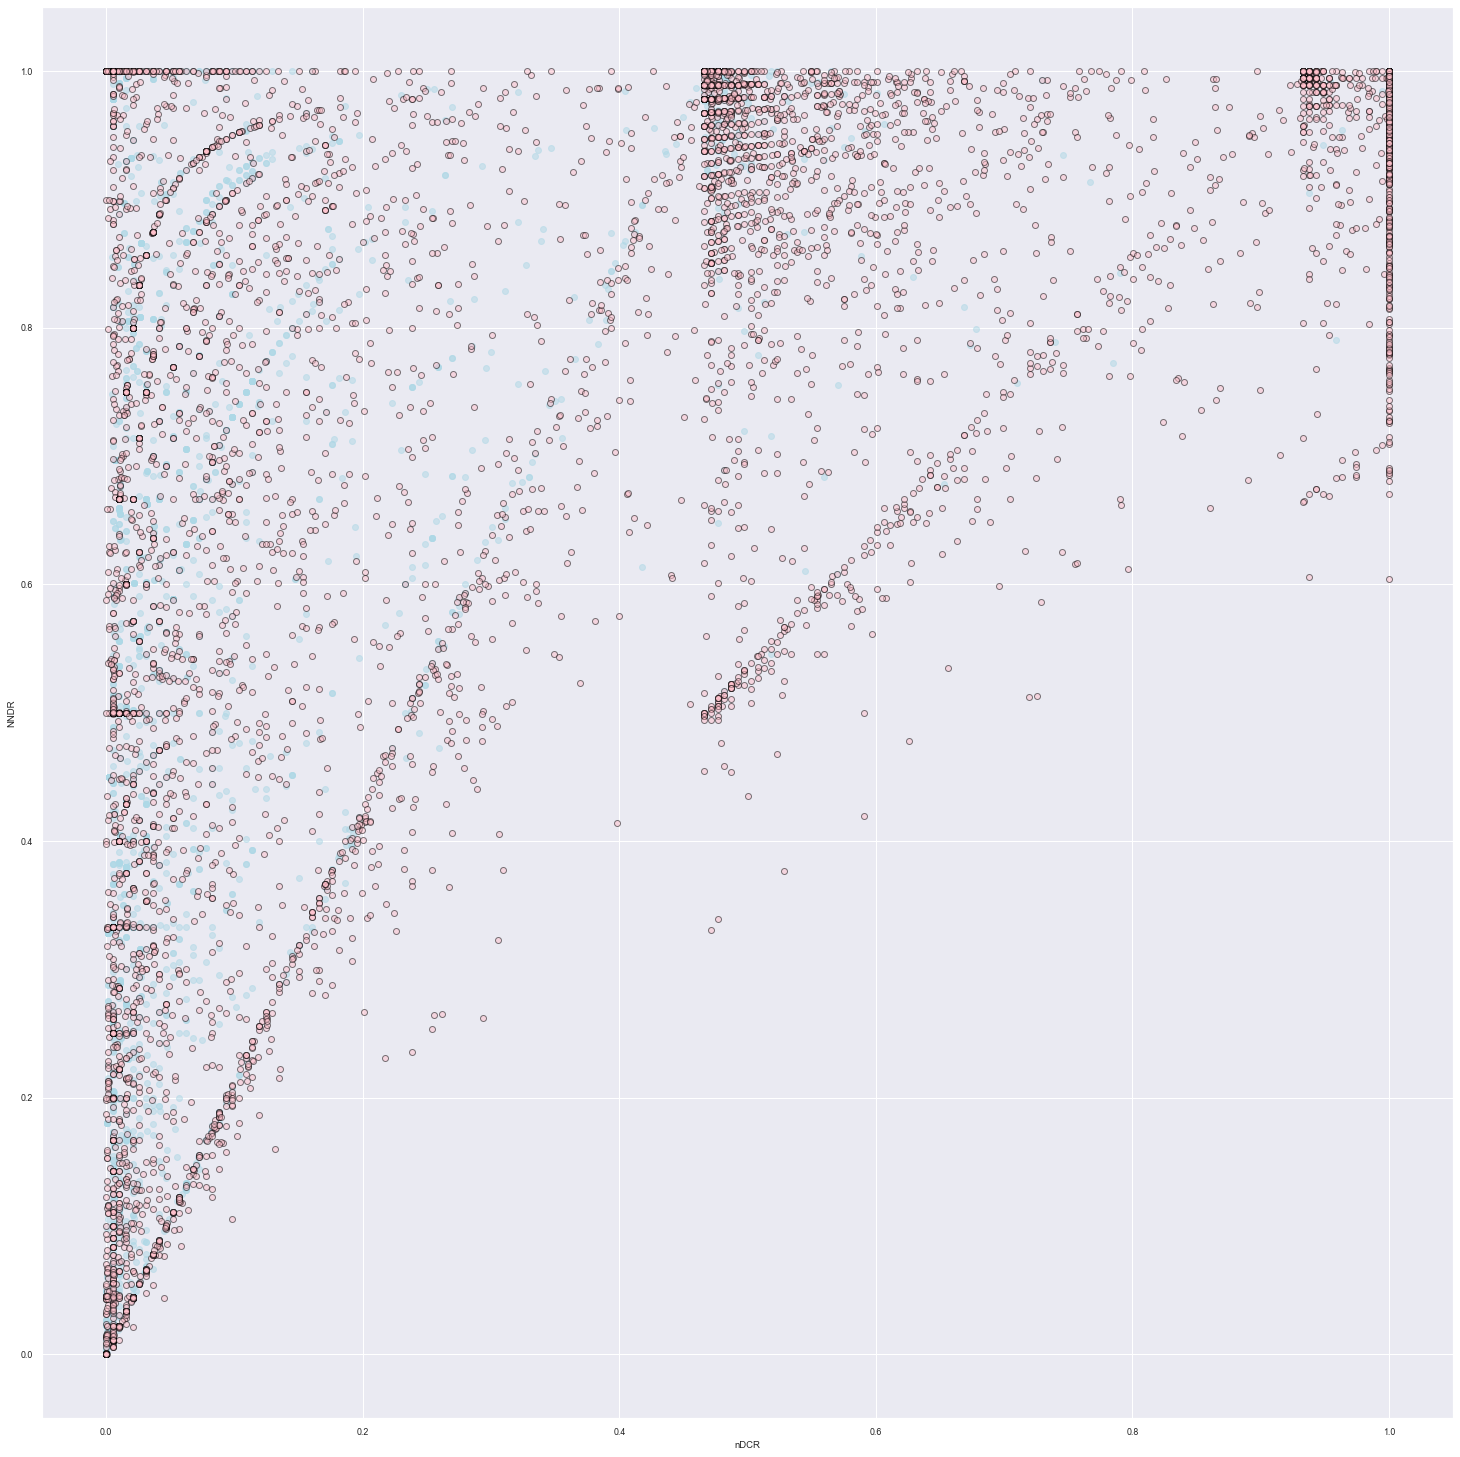

In [285]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
#ax.scatter(cols_compare['Longitude']['gpt2xl'], cols_compare['Latitude']['gpt2xl'],c='lightgreen', label='gpt2xl', alpha=0.1, edgecolors='lightgreen')
#ax.scatter(cols_compare['Longitude']['cerebras'], cols_compare['Latitude']['cerebras'],c='cyan', label='cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [286]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1)

0.2106537530266344

In [287]:
calc_nndr_ratio(nndr_real,nndr_synt1)

0.32919805050952594

In [288]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm1)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt1)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm1)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt1)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=56486431.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=52398377.000000, p-value=0.000000
 Kolmogorov-Smirnov Test for nDCR: statistic=0.33255556, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.263222, p-value=0.000000


In [289]:
res_privacy = pd.DataFrame([['DistillGPT2', bound1,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1),
                        calc_nndr_ratio(nndr_real,nndr_synt1),
                        np.median(dcr_synt_norm1),
                        np.median(nndr_synt1),
                        dcr_synt_norm1.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## GPT2XL privacy

In [290]:
syn_test1 = synt_data_gpt2xl.sample(n=control_size) 

In [291]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [292]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [293]:
nbs2 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [294]:
print('Stats : mean, std, max, min, amount')
dcr_synt2 = np.array([d[0] for d in [x[1] for x in [i for i in nbs2]]])
dcr2_synt2 = np.array([d[1] for d in [x[1] for x in [i for i in nbs2]]])
nndr_synt2 = dcr_synt2 / np.maximum(dcr2_synt2, smoothing_factor) 
print('NNDR stats', nndr_synt2.mean(), nndr_synt2.std(), nndr_synt2.max(), nndr_synt2.min(), len (nndr_synt2))
dcr_synt_norm2 = np.where(dcr_synt2 <= bound, dcr_synt2 / bound, 1)
print('nDCR stats', dcr_synt_norm2.mean(), dcr_synt_norm2.std(), dcr_synt_norm2.max(), dcr_synt_norm2.min(), len (dcr_synt_norm2))

baseline_dcr = dcr_synt2
bound2 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound2)

Stats : mean, std, max, min, amount
NNDR stats 0.1028253722776466 0.2695669926005862 1.0 0.0 9000
nDCR stats 0.0028135385200005847 0.02191200326531435 0.5025906735751295 0.0 9000
DCR Bound 0.95 % = 0.022222222222222223


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for GPTxl synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for GPTxl synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'}>]],
      dtype=object)

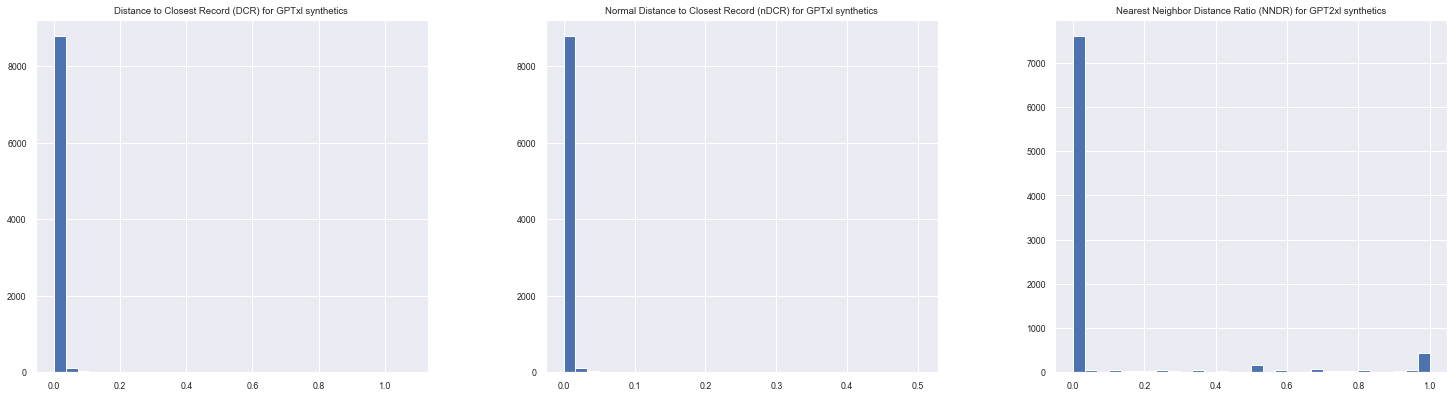

In [295]:
synt_privacy = pd.DataFrame(zip(dcr_synt2,dcr_synt_norm2,nndr_synt2),columns=['Distance to Closest Record (DCR) for GPTxl synthetics ','Normal Distance to Closest Record (nDCR) for GPTxl synthetics','Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

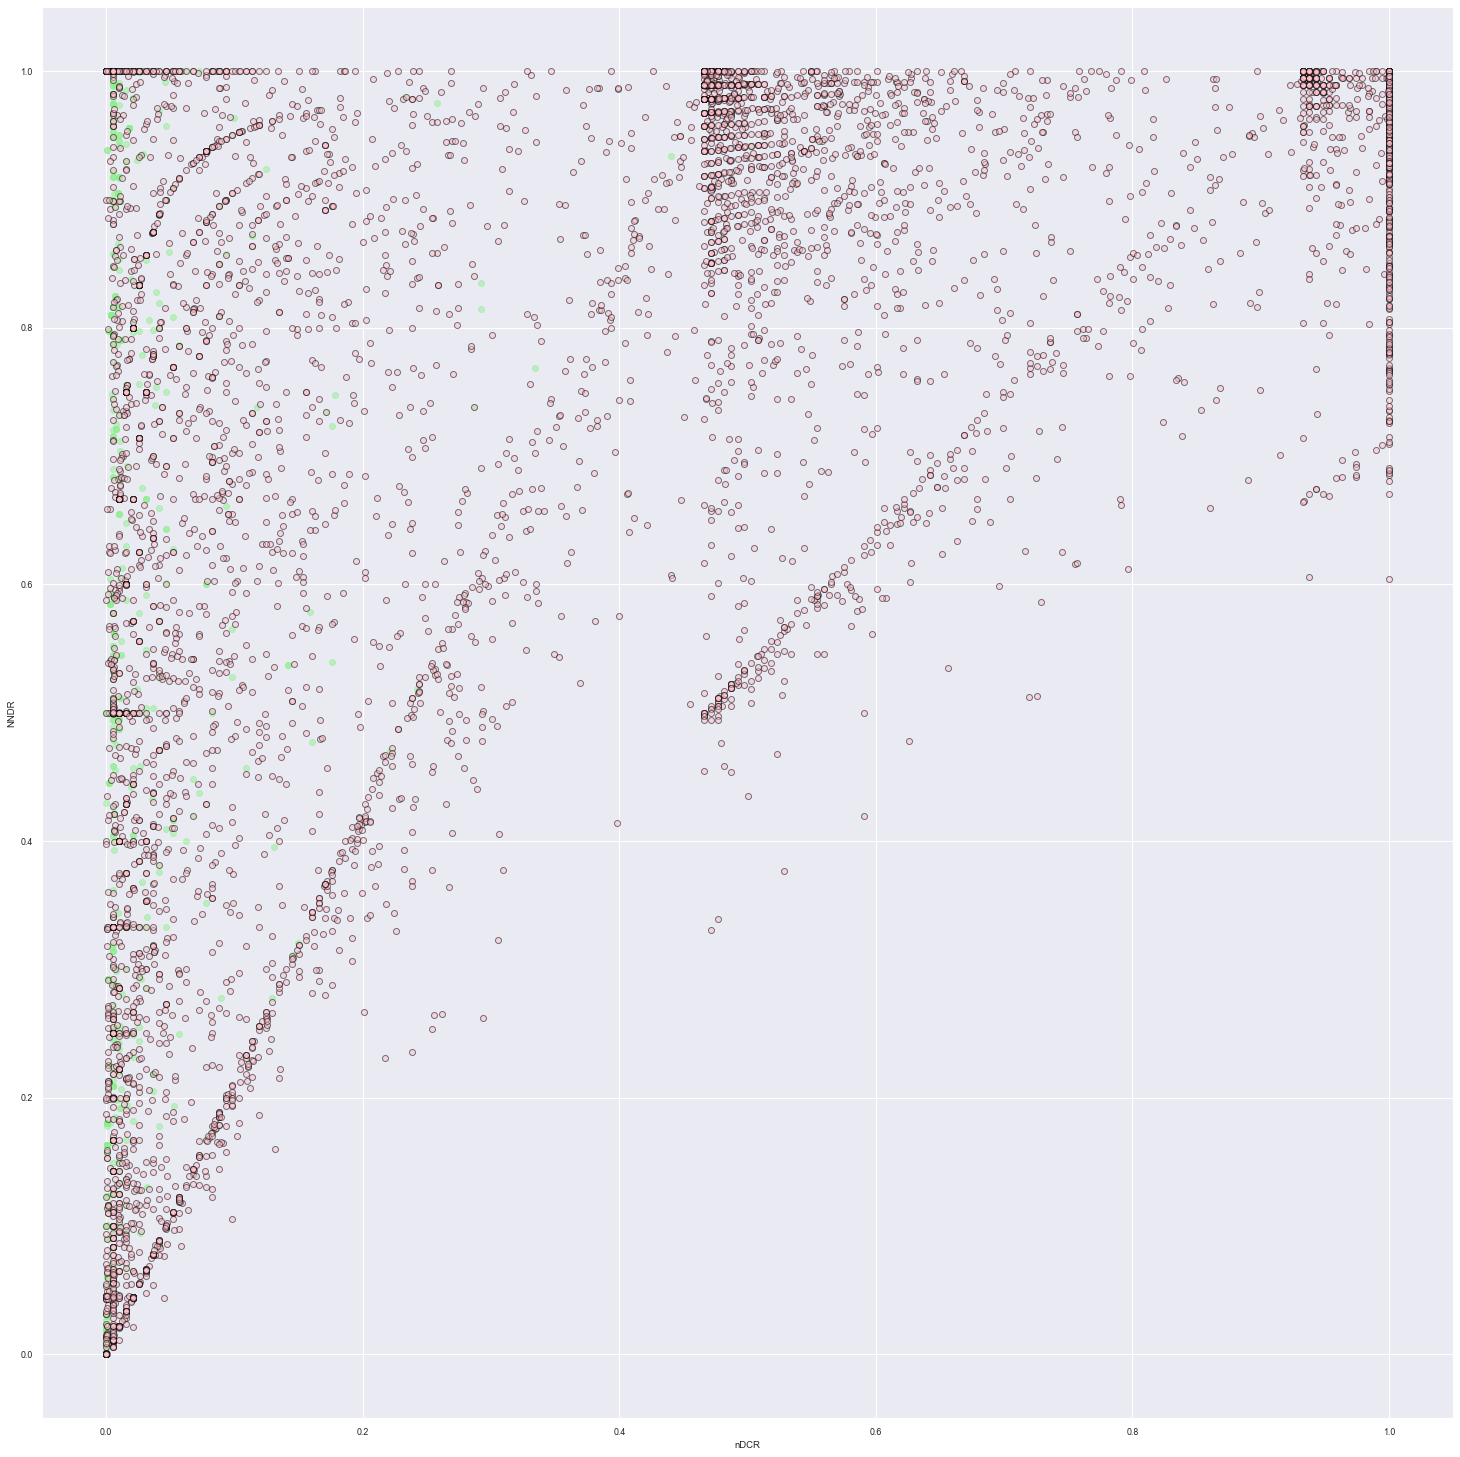

In [296]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [297]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2)

0.015686717074822255

In [298]:
calc_nndr_ratio(nndr_real,nndr_synt2)

0.10687492313368589

In [299]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm2)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt2)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm2)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt2)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=64741559.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=61674468.500000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.53100000, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.517667, p-value=0.000000


In [300]:
res_privacy = pd.DataFrame([['GPT2xl', bound2,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2),
                        calc_nndr_ratio(nndr_real,nndr_synt2),
                        np.median(dcr_synt_norm2),
                        np.median(nndr_synt2),
                        dcr_synt_norm2.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Cerebras privacy

In [301]:
syn_test1 = synt_data_cerebras.sample(n=control_size) 

In [302]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [303]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [304]:
nbs3 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [305]:
print('Stats : mean, std, max, min, amount')
dcr_synt3 = np.array([d[0] for d in [x[1] for x in [i for i in nbs3]]])
dcr2_synt3 = np.array([d[1] for d in [x[1] for x in [i for i in nbs3]]])
nndr_synt3 = dcr_synt3 / np.maximum(dcr2_synt3, smoothing_factor) 
print('NNDR stats', nndr_synt3.mean(), nndr_synt3.std(), nndr_synt3.max(), nndr_synt3.min(), len (nndr_synt3))
dcr_synt_norm3 = np.where(dcr_synt3 <= bound, dcr_synt3 / bound, 1)
print('nDCR stats', dcr_synt_norm3.mean(), dcr_synt_norm3.std(), dcr_synt_norm3.max(), dcr_synt_norm3.min(), len (dcr_synt_norm3))

baseline_dcr = dcr_synt3
bound3 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound3)

Stats : mean, std, max, min, amount
NNDR stats 0.10629376684841275 0.275421084637392 1.0 0.0 9000
nDCR stats 0.0026045894476481634 0.0200264096577212 0.5595854922279793 0.0 9000
DCR Bound 0.95 % = 0.022222222222222223


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Cerebras synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Cerebras synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'}>]],
      dtype=object)

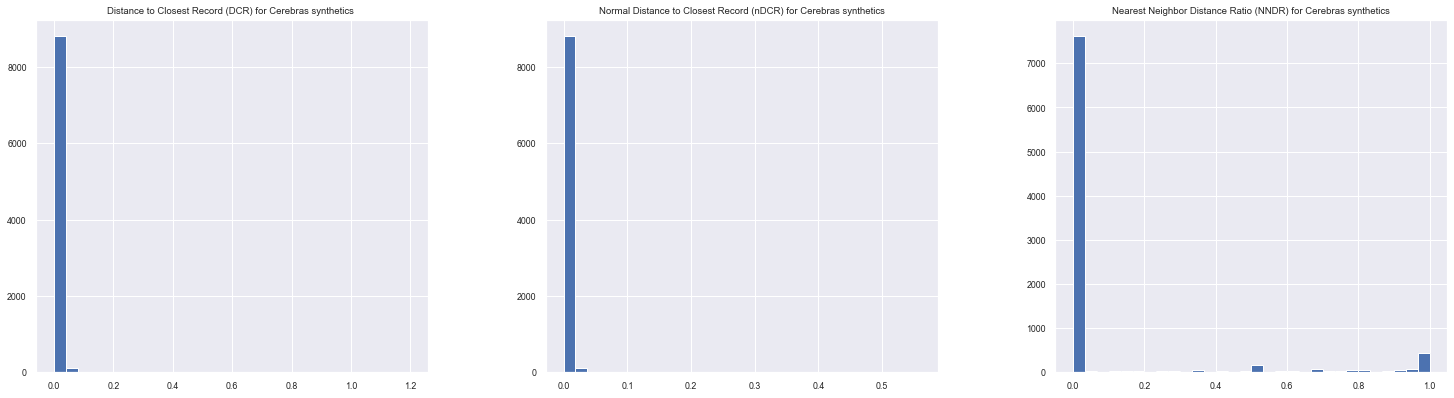

In [306]:
synt_privacy = pd.DataFrame(zip(dcr_synt3,dcr_synt_norm3,nndr_synt3),columns=['Distance to Closest Record (DCR) for Cerebras synthetics ','Normal Distance to Closest Record (nDCR) for Cerebras synthetics','Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

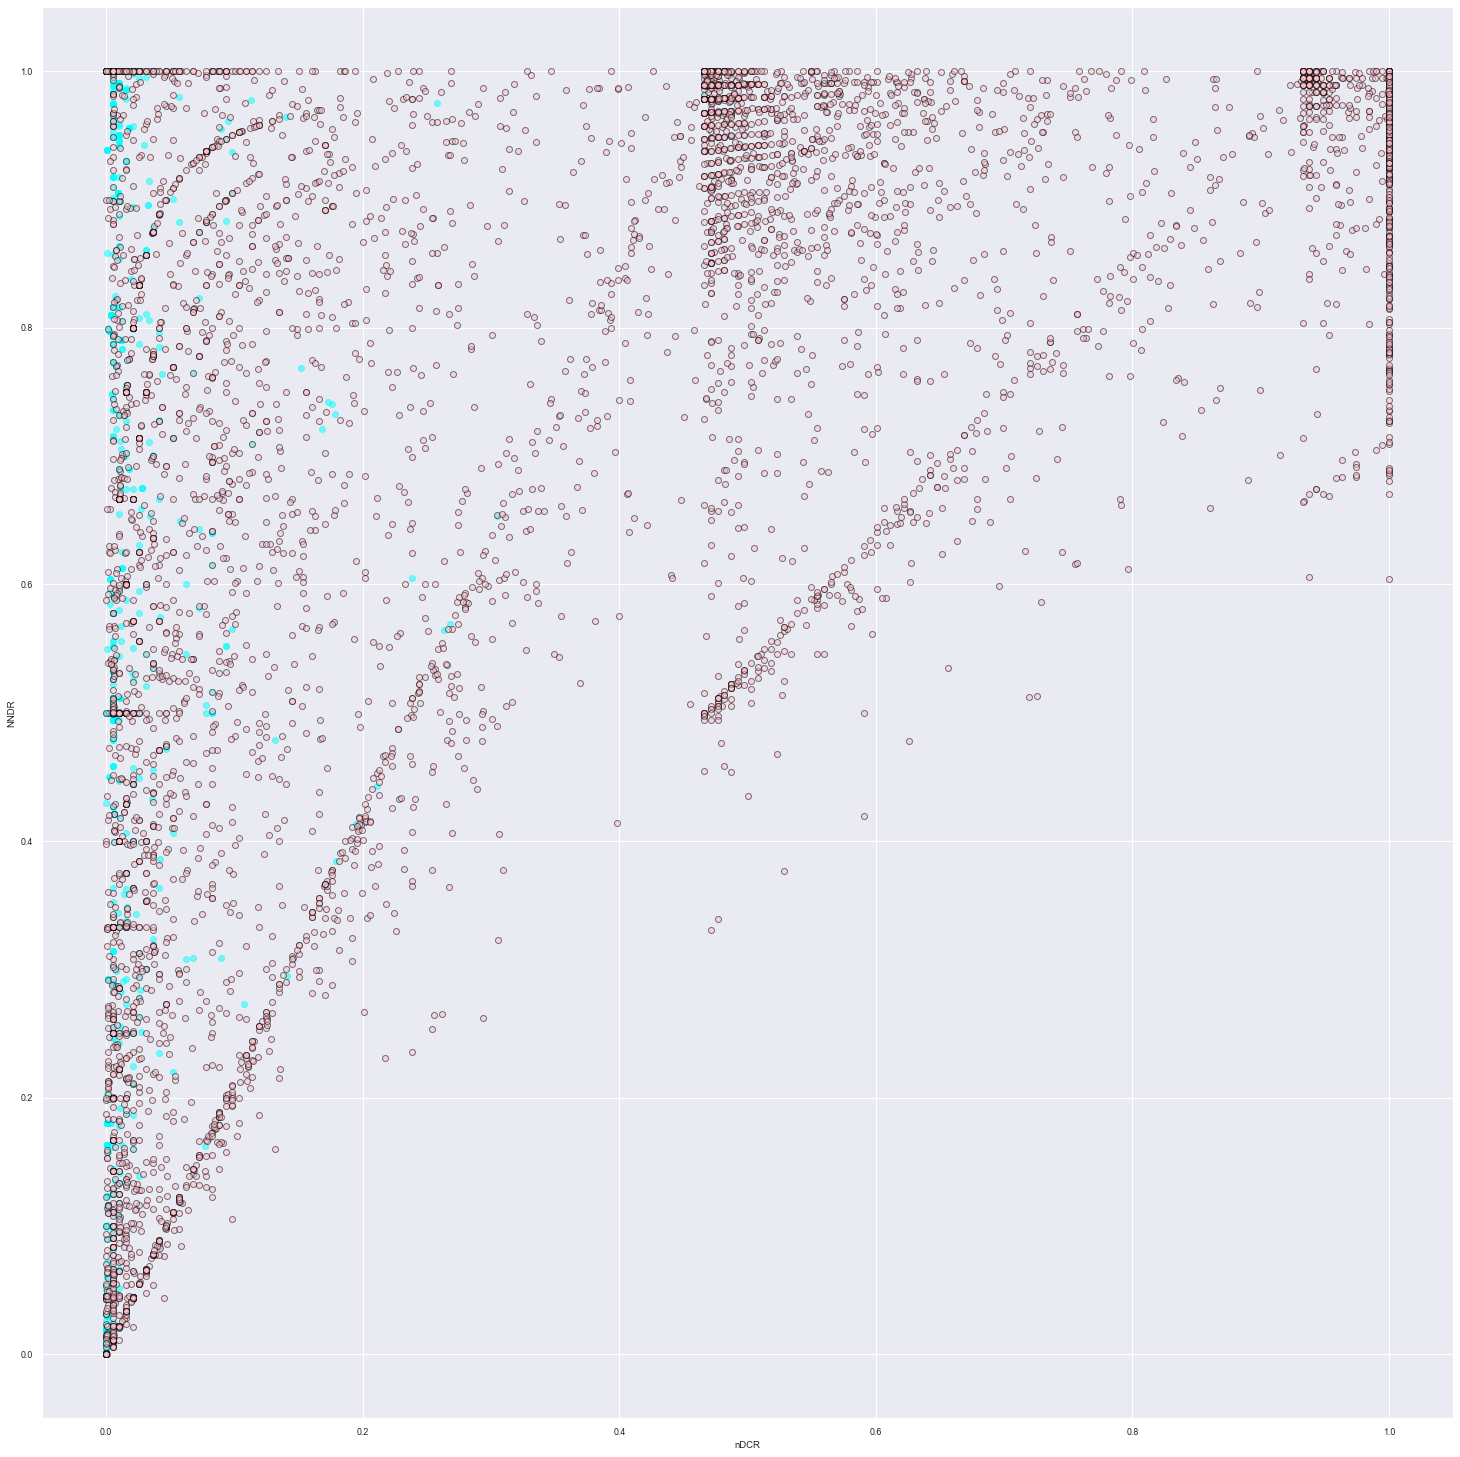

In [307]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [308]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3)

0.013741833746339265

In [309]:
calc_nndr_ratio(nndr_real,nndr_synt3)

0.11344797723617468

In [310]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm3)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt3)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm3)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt3)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=64745062.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=61528286.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.53077778, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.517444, p-value=0.000000


In [311]:
res_privacy = pd.DataFrame([['Cerebras', bound3,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3),
                        calc_nndr_ratio(nndr_real,nndr_synt3),
                        np.median(dcr_synt_norm3),
                        np.median(nndr_synt3),
                        dcr_synt_norm3.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Phi-1.5 privacy

In [312]:
syn_test1 = synt_data_phi.sample(n=control_size) 

In [313]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [314]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [315]:
nbs4 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [316]:
print('Stats : mean, std, max, min, amount')
dcr_synt4 = np.array([d[0] for d in [x[1] for x in [i for i in nbs4]]])
dcr2_synt4 = np.array([d[1] for d in [x[1] for x in [i for i in nbs4]]])
nndr_synt4 = dcr_synt4 / np.maximum(dcr2_synt4, smoothing_factor) 
print('NNDR stats', nndr_synt4.mean(), nndr_synt4.std(), nndr_synt4.max(), nndr_synt4.min(), len (nndr_synt4))
dcr_synt_norm4 = np.where(dcr_synt4 <= bound, dcr_synt4 / bound, 1)
print('nDCR stats', dcr_synt_norm4.mean(), dcr_synt_norm4.std(), dcr_synt_norm4.max(), dcr_synt_norm4.min(), len (dcr_synt_norm4))

baseline_dcr = dcr_synt4
bound4 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound4)

Stats : mean, std, max, min, amount
NNDR stats 0.11629207969321861 0.28697085036466546 1.0 0.0 9000
nDCR stats 0.0035468068710180927 0.026210597903880896 0.5699481865284974 0.0 9000
DCR Bound 0.95 % = 0.022222222222222223


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Phi1.5 synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'}>]],
      dtype=object)

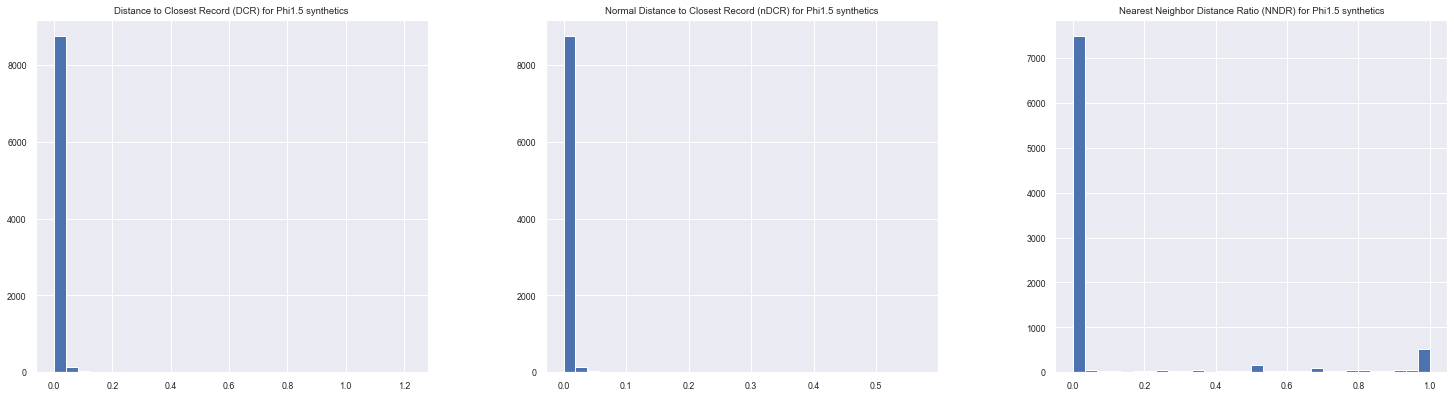

In [317]:
synt_privacy = pd.DataFrame(zip(dcr_synt4,dcr_synt_norm4,nndr_synt4),columns=['Distance to Closest Record (DCR) for Phi1.5 synthetics ','Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics','Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

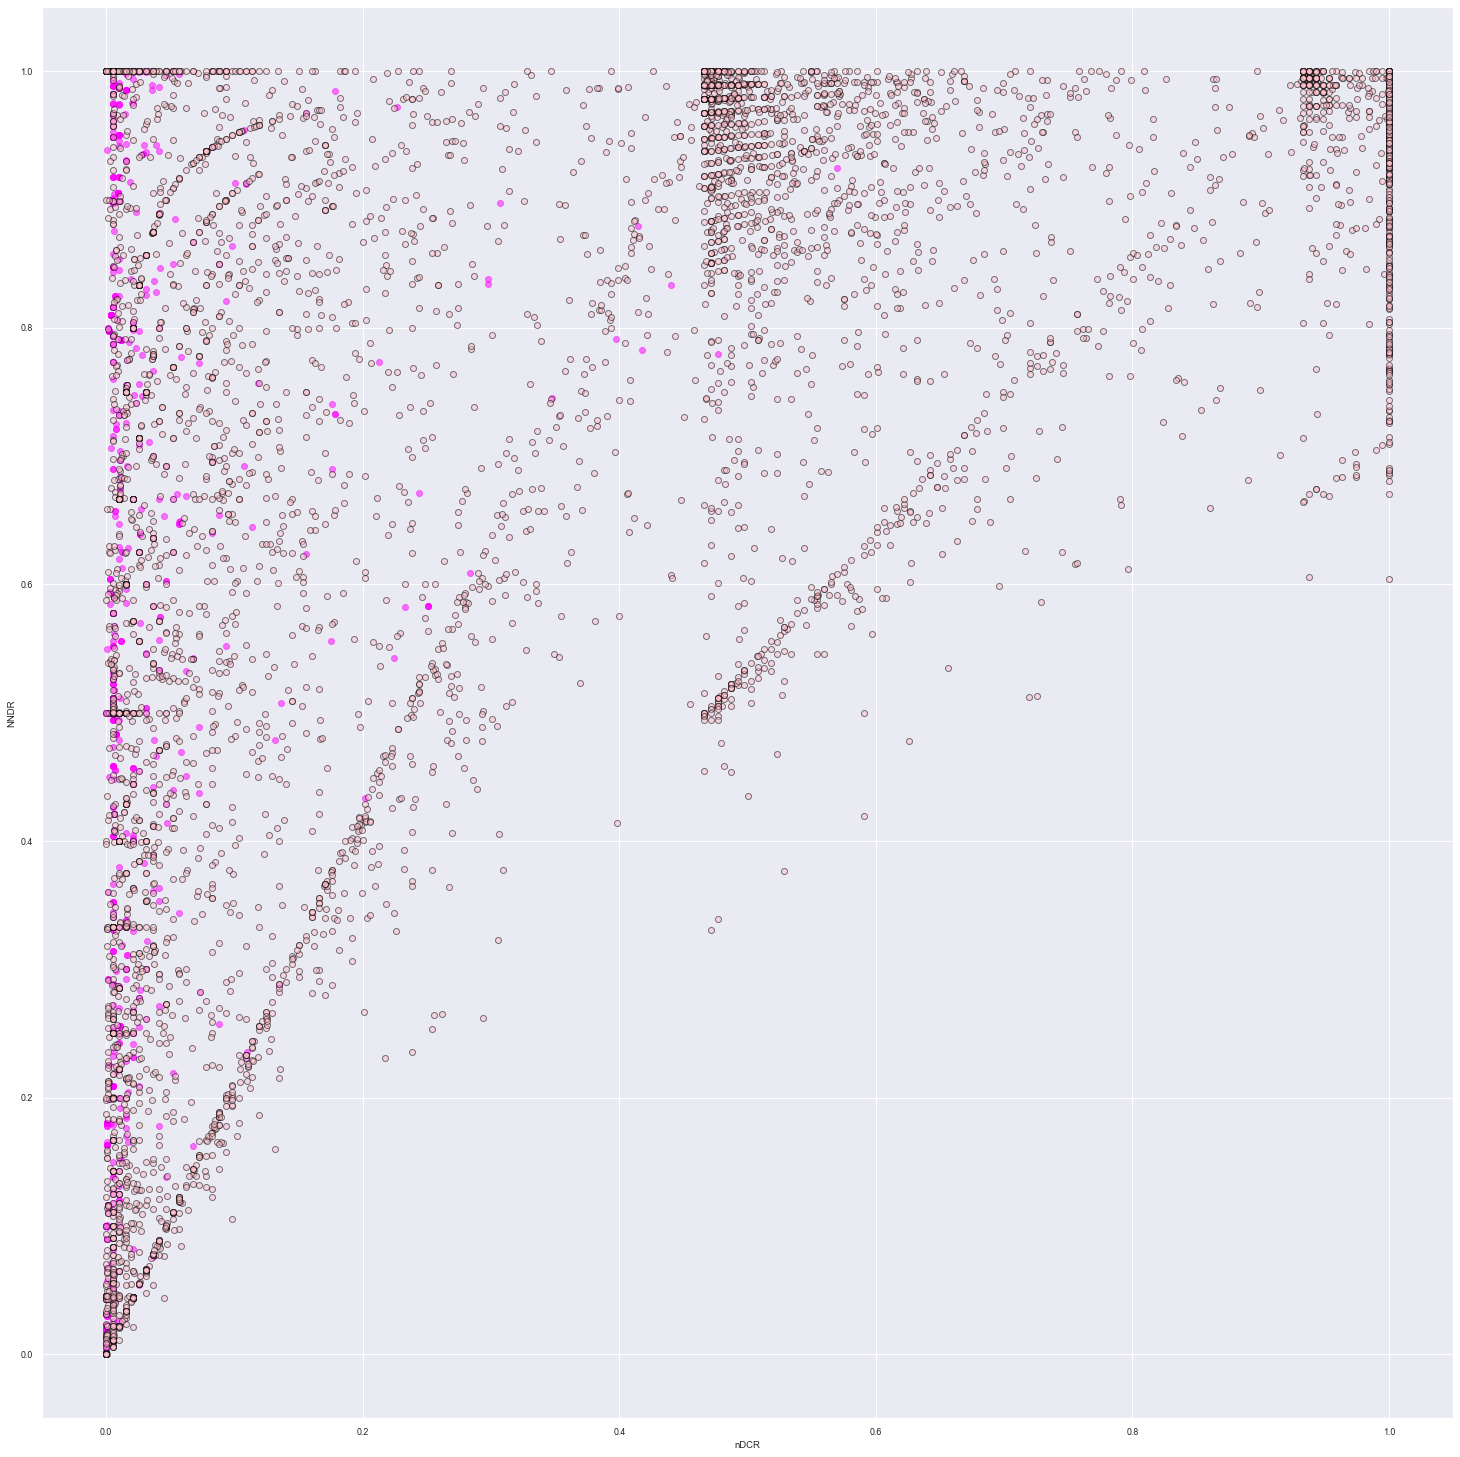

In [318]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [319]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4)

0.018791034638895178

In [320]:
calc_nndr_ratio(nndr_real,nndr_synt4)

0.12471882029492627

In [321]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm4)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt4)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm4)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt4)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=64386444.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=60862607.500000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.52244444, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.502667, p-value=0.000000


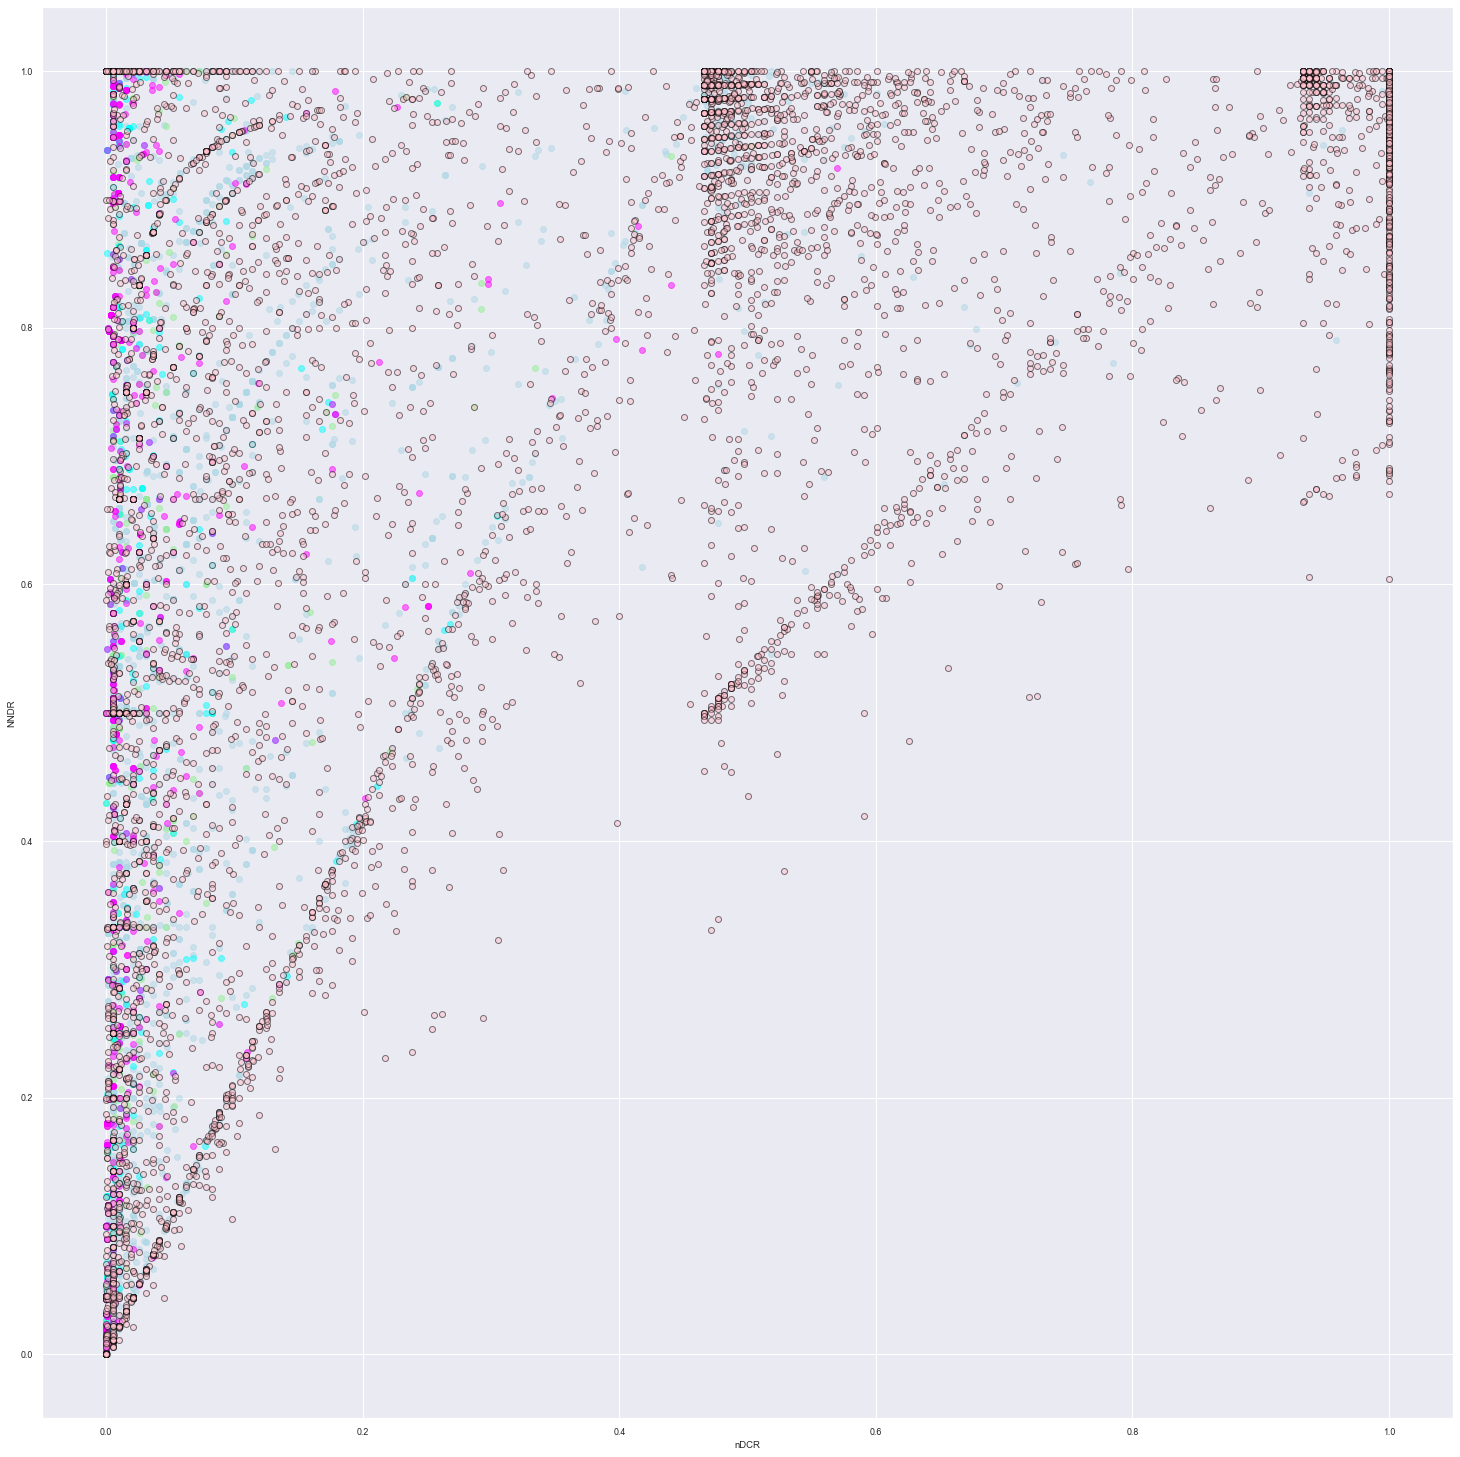

In [322]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi-1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [323]:
res_privacy = pd.DataFrame([['Phi1.5', bound4,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4),
                        calc_nndr_ratio(nndr_real,nndr_synt4),
                        np.median(dcr_synt_norm4),
                        np.median(nndr_synt4),
                        dcr_synt_norm4.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

### Privacy calculation results 

In [324]:
privacy_results

Model  95% bound  DCRn ratio  NNDR ratio  DCRn median  NNDR median  \
0  Real dataset   2.144444    1.000000    1.000000     0.026871     0.507562   
0   DistillGPT2   0.895726    0.210654    0.329198     0.000000     0.000000   
0        GPT2xl   0.022222    0.015687    0.106875     0.000000     0.000000   
0      Cerebras   0.022222    0.013742    0.113448     0.000000     0.000000   
0        Phi1.5   0.022222    0.018791    0.124719     0.000000     0.000000   

   Minimal distance  
0               0.0  
0               0.0  
0               0.0  
0               0.0  
0               0.0

In [325]:
privacy_results.to_csv('privacy_results_shortincome_temp0.3.csv')